In [ ]:
Добавление нужной метрике к кривой обучения catboost
eval_weights_validation = df_validation['weight'].get_values()
class CustomMetric(object):
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        # approxes - list of list-like objects (one object per approx dimension)
        # target - list-like object
        # weight - list-like object, can be None

        p = np.array(approxes[0])
        y = np.array(target)
        print(type(weight))
        if weight is not None:
            res = scoring.rejection90(y, p, sample_weight = np.array(weight))
        else:
            res = scoring.rejection90(y, p, sample_weight = eval_weights_validation)

        return res, res

m = catboost.CatBoostClassifier(iterations=10000, max_depth=8, 
                                thread_count=30, verbose=True, 
                                custom_loss = ['Logloss', 'AUC','Precision','Recall','F1'],
                                eval_metric = CustomMetric(),
                                loss_function='CrossEntropy')

# custom_metric
eval_set = (df_validation[features1], 
            df_validation[target])
#             df_train_part[:1000]['weight'])

m.fit(df_train_part[features1], 
      df_train_part[target], 
      eval_set = eval_set,
      sample_weight=np.abs(df_train_part['weight']),
    plot = True)

ПЛАН:
 - Отослать посылку по задаче С
     - Посмотреть на сколько сложно работать со скоростью
 - Добавить признаков
    (каких?)
    - Точка пересечения траектории частицы с линией ускоритель 
        Или расстояние от прямой траектории до прямой ускоритель
    - Апроксимация траектории параболой (есть две точки) -> ускорение частицы
    - Там есть ошибка MatchedHit_D{X,Y,Z}[N], значит для угла и ошибки от траетории можно построить оценку сверху и 
        оценку снизу
    - Скорости 

In [5]:
import scoring

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
# from matplotlib import pyplot as plt
# %matplotlib inline

In [6]:
# from xgboost import XGBClassifier
import catboost

Путь к выборке

In [4]:
path = '../data/'

In [4]:
# from imblearn.under_sampling import RandomUnderSampler


In [5]:
# rus = RandomUnderSampler(sampling_strategy='all')

In [6]:
# %%time
# df_train = pd.read_csv(path+'train_v2_merged.csv')
# df_test  = pd.read_csv(path+'test_public_v2.csv')

# # df_small = pd.read_csv(path+'advanced_baseline_train.csv', nrows=3000)


In [7]:
# df_small['label'].describe()

In [8]:
# df_small.iloc[df_small['label'] < 1.0].describe()

In [9]:
# tmp = rus.fit_resample(df_small, df_small['label'])

In [10]:
# pd.DataFrame(tmp[0], columns=df_small.columns)['label'].describe()

In [7]:
%%time
# df_train = pd.read_csv(path+'train_v2_merged.csv')
# df_test  = pd.read_csv(path+'test_public_v2.csv')

df_train = pd.read_csv(path+'advanced_baseline_train.csv')
df_test  = pd.read_csv(path+'advanced_baseline_test.csv')

CPU times: user 1min 30s, sys: 4.94 s, total: 1min 35s
Wall time: 1min 35s


In [9]:
df_train.keys()

Index(['Unnamed: 0', 'ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'avg_cs[0]',
       'avg_cs[1]', 'avg_cs[2]', 'avg_cs[3]', 'ndof', 'MatchedHit_TYPE[0]',
       'MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]',
       'MatchedHit_X[0]', 'MatchedHit_X[1]', 'MatchedHit_X[2]',
       'MatchedHit_X[3]', 'MatchedHit_Y[0]', 'MatchedHit_Y[1]',
       'MatchedHit_Y[2]', 'MatchedHit_Y[3]', 'MatchedHit_Z[0]',
       'MatchedHit_Z[1]', 'MatchedHit_Z[2]', 'MatchedHit_Z[3]',
       'MatchedHit_DX[0]', 'MatchedHit_DX[1]', 'MatchedHit_DX[2]',
       'MatchedHit_DX[3]', 'MatchedHit_DY[0]', 'MatchedHit_DY[1]',
       'MatchedHit_DY[2]', 'MatchedHit_DY[3]', 'MatchedHit_DZ[0]',
       'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]',
       'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_T[2]',
       'MatchedHit_T[3]', 'MatchedHit_DT[0]', 'MatchedHit_DT[1]',
       'MatchedHit_DT[2]', 'MatchedHit_DT[3]', 'Lextra_X[0]', 'Lextra_X[1]',
       'Lextra_X[2]', 'Lextra_X[3]', 'Lextra_Y

In [26]:
from tqdm import tqdm_notebook

In [ ]:
df_train['MatchedHit_TYPE'] = df_train['MatchedHit_TYPE[0]'].astype(str)+\
                              df_train['MatchedHit_TYPE[1]'].astype(str)+\
                              df_train['MatchedHit_TYPE[2]'].astype(str)+\
                              df_train['MatchedHit_TYPE[3]'].astype(str)

In [30]:

            
df_train['HitFirstZero'] = [(i+'0').index('0') for i in tqdm_notebook(df_train['MatchedHit_TYPE'])]
df_train['HitHasTwoZero'] = ['00' in i for i in  tqdm_notebook(df_train['MatchedHit_TYPE'])]

def foo_speed(s):
    i1,i2,i3,i4 = [int(i) for i in s]
    return i4+i3*3+i2*3*2+i1**3*2*2

def foo_speed_revert(s):
    i1,i2,i3,i4 = [int(i) for i in s]
    return i4*3*3*2+i3*3*2+i2*2+i1

def foo_speed_xor1(s):
    i1,i2,i3,i4 = [((int(i)+1)%3) for i in s]
    return i4+i3*3+i2*3*2+i1**3*2*2

def foo_speed_xor2(s):
    i1,i2,i3,i4 = [((int(i)+2)%3) for i in s]
    return i4+i3*3+i2*3*2+i1**3*2*2

def foo_speed_xor1_revert(s):
    i1,i2,i3,i4 = [((int(i)+1)%3) for i in s]
    return i4*3*3*2+i3*3*2+i2*2+i1


def foo_speed_xor2_revert(s):
    i1,i2,i3,i4 = [((int(i)+2)%3) for i in s]
    return i4*3*3*2+i3*3*2+i2*2+i1

        
df_train['HitSpeed'] = [foo_speed(i) for i in tqdm_notebook(df_train['MatchedHit_TYPE'])]
df_train['HitSpeedRev'] = [foo_speed_revert(i) for i in tqdm_notebook(df_train['MatchedHit_TYPE'])]

df_train['HitSpeedXor1'] = [foo_speed_xor1(i) for i in tqdm_notebook(df_train['MatchedHit_TYPE'])]
df_train['HitSpeedRevXor1'] = [foo_speed_xor1_revert(i) for i in tqdm_notebook(df_train['MatchedHit_TYPE'])]


df_train['HitSpeedXor2'] = [foo_speed_xor2(i) for i in tqdm_notebook(df_train['MatchedHit_TYPE'])]
df_train['HitSpeedRevXor2'] = [foo_speed_xor2_revert(i) for i in tqdm_notebook(df_train['MatchedHit_TYPE'])]


# Последний перед нулем

HBox(children=(IntProgress(value=0, max=5445705), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5445705), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5445705), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5445705), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5445705), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5445705), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5445705), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5445705), HTML(value='')))

In [18]:
df_train['MatchedHit_TYPE'].unique()

array(['2222', '2221', '2211', '1102', '1222', '2200', '2212', '1211',
       '2111', '1100', '2112', '2202', '2220', '2121', '1122', '1220',
       '2102', '1212', '2101', '1101', '2201', '2122', '1111', '1120',
       '2120', '1221', '1202', '1121', '1112', '2110', '1201', '2210',
       '1110', '1200', '2100', '1210'], dtype=object)

In [25]:
df_train['MatchedHit_TYPE[2]'].unique()

array([2, 1, 0])

In [8]:
print(list(df_test.keys()))

['id', 'ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'avg_cs[0]', 'avg_cs[1]', 'avg_cs[2]', 'avg_cs[3]', 'ndof', 'MatchedHit_TYPE[0]', 'MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]', 'MatchedHit_X[0]', 'MatchedHit_X[1]', 'MatchedHit_X[2]', 'MatchedHit_X[3]', 'MatchedHit_Y[0]', 'MatchedHit_Y[1]', 'MatchedHit_Y[2]', 'MatchedHit_Y[3]', 'MatchedHit_Z[0]', 'MatchedHit_Z[1]', 'MatchedHit_Z[2]', 'MatchedHit_Z[3]', 'MatchedHit_DX[0]', 'MatchedHit_DX[1]', 'MatchedHit_DX[2]', 'MatchedHit_DX[3]', 'MatchedHit_DY[0]', 'MatchedHit_DY[1]', 'MatchedHit_DY[2]', 'MatchedHit_DY[3]', 'MatchedHit_DZ[0]', 'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]', 'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_T[2]', 'MatchedHit_T[3]', 'MatchedHit_DT[0]', 'MatchedHit_DT[1]', 'MatchedHit_DT[2]', 'MatchedHit_DT[3]', 'Lextra_X[0]', 'Lextra_X[1]', 'Lextra_X[2]', 'Lextra_X[3]', 'Lextra_Y[0]', 'Lextra_Y[1]', 'Lextra_Y[2]', 'Lextra_Y[3]', 'NShared', 'Mextra_DX2[0]', 'Mextra_DX2[1]', 'Mextra_DX2[2]',

In [12]:
if "Unnamed: 0" in df_train.columns:
    print('df_train contain Unnamed: 0')
    del df_train['Unnamed: 0']

df_train contain Unnamed: 0


In [13]:
print(df_test.keys())

Index(['id', 'ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'avg_cs[0]', 'avg_cs[1]',
       'avg_cs[2]', 'avg_cs[3]', 'ndof', 'MatchedHit_TYPE[0]',
       'MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]',
       'MatchedHit_X[0]', 'MatchedHit_X[1]', 'MatchedHit_X[2]',
       'MatchedHit_X[3]', 'MatchedHit_Y[0]', 'MatchedHit_Y[1]',
       'MatchedHit_Y[2]', 'MatchedHit_Y[3]', 'MatchedHit_Z[0]',
       'MatchedHit_Z[1]', 'MatchedHit_Z[2]', 'MatchedHit_Z[3]',
       'MatchedHit_DX[0]', 'MatchedHit_DX[1]', 'MatchedHit_DX[2]',
       'MatchedHit_DX[3]', 'MatchedHit_DY[0]', 'MatchedHit_DY[1]',
       'MatchedHit_DY[2]', 'MatchedHit_DY[3]', 'MatchedHit_DZ[0]',
       'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]',
       'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_T[2]',
       'MatchedHit_T[3]', 'MatchedHit_DT[0]', 'MatchedHit_DT[1]',
       'MatchedHit_DT[2]', 'MatchedHit_DT[3]', 'Lextra_X[0]', 'Lextra_X[1]',
       'Lextra_X[2]', 'Lextra_X[3]', 'Lextra_Y[0]', 'L

In [34]:
print(df_train.keys())

Index(['ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'avg_cs[0]', 'avg_cs[1]',
       'avg_cs[2]', 'avg_cs[3]', 'ndof', 'MatchedHit_TYPE[0]',
       'MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]',
       'MatchedHit_X[0]', 'MatchedHit_X[1]', 'MatchedHit_X[2]',
       'MatchedHit_X[3]', 'MatchedHit_Y[0]', 'MatchedHit_Y[1]',
       'MatchedHit_Y[2]', 'MatchedHit_Y[3]', 'MatchedHit_Z[0]',
       'MatchedHit_Z[1]', 'MatchedHit_Z[2]', 'MatchedHit_Z[3]',
       'MatchedHit_DX[0]', 'MatchedHit_DX[1]', 'MatchedHit_DX[2]',
       'MatchedHit_DX[3]', 'MatchedHit_DY[0]', 'MatchedHit_DY[1]',
       'MatchedHit_DY[2]', 'MatchedHit_DY[3]', 'MatchedHit_DZ[0]',
       'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]',
       'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_T[2]',
       'MatchedHit_T[3]', 'MatchedHit_DT[0]', 'MatchedHit_DT[1]',
       'MatchedHit_DT[2]', 'MatchedHit_DT[3]', 'Lextra_X[0]', 'Lextra_X[1]',
       'Lextra_X[2]', 'Lextra_X[3]', 'Lextra_Y[0]', 'Lextra_

Разделим на train и validation

In [ ]:
%%time
df_train_part, df_validation = train_test_split(df_train, test_size=0.25, shuffle=True, random_state = 42)

In [17]:
from functions_050218_ import get_dataframe_pair_diff_ncl, get_mean_count_points, get_len_div_dt

In [18]:
%%time
temp = get_dataframe_pair_diff_ncl(df_validation)

CPU times: user 94 ms, sys: 136 ms, total: 230 ms
Wall time: 222 ms


In [19]:
temp

diff_ncl_0_1  diff_ncl_1_2  diff_ncl_2_3
3479269           -93           -16             7
2277850           -33            -2             6
3855171           -41            -1            -5
3311447           -49           -37            10
983196            -36            -4             2
3289639           -53            -3             7
1964379           -21           -33            -5
270606            -13            -8             1
4134314           -27            18           -14
214463            -32            -3             0
3064139           -15            -2             7
1130609           -29             0             6
140369            -53             7            -9
442812            -46            -2             1
2241961           -51            16           -17
2532555           -74           -25            25
5174092           -27            -6             5
4660969           -11            -3             5
1733112           -19           -10            -1
1856927           -18           -35             1
5237557           -10           -10            -1
5298193           -61           -31            10
5175634           -46            -5             2
4048705          -134           -24            -4
5357324           -32            -7             1
3659905           -73           -19             7
1036473           -47            -3            -1
4268128           -91            -6            -8
1327464          -112            -6             8
3995242           -43           -27             7
...               ...           ...           ...
2782778           -29            -7             2
3420368           -33            -4            -7
1586103           -54            -4            10
997581            -32             8             5
1019399           -30            -4             1
5123543           -84            -4            -4
626561            -59            -4             8
103588            -61             6           -10
96377             -83            -7            -3
522183            -36            -8            -1
3672067           -81            -8           -12
2413536           -36           -13            -2
3874083           -77            -2             5
5147151           -39           -13            -2
1309775          -115             5           -18
4169706           -21           -23            13
3597538           -69            -6             0
587609            -55            -9           -15
3268266           -37            -6             9
3816983           -44            -1            12
2735701            -8            -8             0
1177613           -30           -76            -2
4906227           -35            -4            12
4132167           -12             4             4
4229588           -58            -4            -3
2530737          -104           -14            -6
2541155           -20             1             2
2559177           -51            -5            -2
3948616           -22            -3             5
4689153           -29            -9            -7

[1361427 rows x 3 columns]

In [20]:
# def calculate_angle(df):
#     """ 
#         params: 
#             df - df with keys MatchedHit_{X, Y, Z}[{0,1 , 2}]
#         return 
#             np.array
#     """
#     x1 = (df['MatchedHit_X[1]'] - df['MatchedHit_X[0]'],\
#           df['MatchedHit_Y[1]'] - df['MatchedHit_Y[0]'],\
#           df['MatchedHit_Z[1]'] - df['MatchedHit_Z[0]'])

#     x2 = (df['MatchedHit_X[2]'] - df['MatchedHit_X[1]'],\
#           df['MatchedHit_Y[2]'] - df['MatchedHit_Y[1]'],\
#           df['MatchedHit_Z[2]'] - df['MatchedHit_Z[1]'])

#     scalar12 = np.sum([i*j for i,j in zip(x1, x2)], axis = 0)
#     scalar11 = np.sum([i**2 for i in x1], axis = 0)
#     scalar22 = np.sum([i**2 for i in x2], axis = 0)

#     return np.arccos(scalar12/np.sqrt(scalar11*scalar22))*180/np.pi


# def calc_ind_closure(ind, start_ind=0):
#     def calculate_angle_ind(df):
#         """ 
#             params: 
#                 df - df with keys MatchedHit_{X, Y, Z}[{0,1 , 2}]
#             return 
#                 np.array
#         """
#         i0 = start_ind
#         i1 = start_ind + 1
#         i2 = start_ind + 2
#         x1 = (df['MatchedHit_X[%i]' % i1] - df['MatchedHit_X[%i]' % i0],\
#               df['MatchedHit_Y[%i]' % i1] - df['MatchedHit_Y[%i]' % i0],\
#               df['MatchedHit_Z[%i]' % i1] - df['MatchedHit_Z[%i]' % i0])

#         x2 = (df['MatchedHit_X[%i]' % i2] - df['MatchedHit_X[%i]' % i1],\
#               df['MatchedHit_Y[%i]' % i2] - df['MatchedHit_Y[%i]' % i1],\
#               df['MatchedHit_Z[%i]' % i2] - df['MatchedHit_Z[%i]' % i1])

#         scalar12 = np.sum([i*j for i,j in zip(x1, x2)], axis = 0)
#         scalar11 = np.sum([i**2 for i in x1], axis = 0)
#         scalar22 = np.sum([i**2 for i in x2], axis = 0)

#         return np.arccos(scalar12/np.sqrt(scalar11*scalar22))*180/np.pi
#     return calculate_angle_ind

    

# def get_column_lengths_trajectory(data):
#     """
#       Длинна траектории, чтобы это не значило
#     """
#     lengths = np.ones(len(data)) * 4
#     for i in range(3, -1, -1):
#         indices = np.where(data['MatchedHit_Z[{}]'.format(i)] < -9800)[0]
#         lengths[indices] = i 
#     return lengths

# def calc_diff_btw_trajectory_and_extr(data):
#     diff_columns = {}
#     res = np.zeros(len(data))
#     for i in range(4):
#         diff_columns[i] = {}
#         for l in ['X', 'Y']:
#             diff_columns[i][l] = (data["MatchedHit_%s[%i]"%(l, i)] - data["Lextra_%s[%i]"%(l, i)])**2
#         res += np.sqrt(diff_columns[i]['X'] + diff_columns[i]['Y'])
#     return res

# # FEATURES

def calculate_angle(df):
    """
        params:
            df - df with keys MatchedHit_{X, Y, Z}[{0,1 , 2}]
        return
            np.array
    """
    x1 = (df['MatchedHit_X[1]'] - df['MatchedHit_X[0]'],\
          df['MatchedHit_Y[1]'] - df['MatchedHit_Y[0]'],\
          df['MatchedHit_Z[1]'] - df['MatchedHit_Z[0]'])

    x2 = (df['MatchedHit_X[2]'] - df['MatchedHit_X[1]'],\
          df['MatchedHit_Y[2]'] - df['MatchedHit_Y[1]'],\
          df['MatchedHit_Z[2]'] - df['MatchedHit_Z[1]'])

    scalar12 = np.sum([i*j for i,j in zip(x1, x2)], axis = 0)
    scalar11 = np.sum([i**2 for i in x1], axis = 0)
    scalar22 = np.sum([i**2 for i in x2], axis = 0)

    return ['angle'], [np.arccos(scalar12/np.sqrt(scalar11*scalar22))*180/np.pi]

def calculate_angle_ind(df, start_ind=1):
    """ 
        params: 
            df - df with keys MatchedHit_{X, Y, Z}[{0,1 , 2}]
        return 
            np.array
    """
    i0 = (start_ind     ) % 3
    i1 = (start_ind + 1 ) % 3
    i2 = (start_ind + 2 ) % 3
    
    x1 = (df['MatchedHit_X[%i]' % i1] - df['MatchedHit_X[%i]' % i0],\
          df['MatchedHit_Y[%i]' % i1] - df['MatchedHit_Y[%i]' % i0],\
          df['MatchedHit_Z[%i]' % i1] - df['MatchedHit_Z[%i]' % i0])

    x2 = (df['MatchedHit_X[%i]' % i2] - df['MatchedHit_X[%i]' % i1],\
          df['MatchedHit_Y[%i]' % i2] - df['MatchedHit_Y[%i]' % i1],\
          df['MatchedHit_Z[%i]' % i2] - df['MatchedHit_Z[%i]' % i1])

    scalar12 = np.sum([i*j for i,j in zip(x1, x2)], axis = 0)
    scalar11 = np.sum([i**2 for i in x1], axis = 0)
    scalar22 = np.sum([i**2 for i in x2], axis = 0)

    return  ['angle%d'%start_ind], [np.arccos(scalar12/np.sqrt(scalar11*scalar22))*180/np.pi]

def calculate_angle_0(data):
    return calculate_angle_ind(data, start_ind=0)

def calculate_angle_1(data):
    return calculate_angle_ind(data, start_ind=1)

def calculate_angle_2(data):
    return calculate_angle_ind(data, start_ind=2)

def get_column_lengths_trajectory(data):
    """
      Длинна траектории, чтобы это не значило
    """
    lengths = np.ones(len(data)) * 4
    for i in range(3, -1, -1):
        indices = np.where(data['MatchedHit_Z[{}]'.format(i)] < -9800)[0]
        lengths[indices] = i
    return ['traj_len'], [lengths]


def calc_diff_btw_trajectory_and_extr(data):
    diff_columns = {}
    res = np.zeros(len(data))
    for i in range(4):
        diff_columns[i] = {}
        for l in ['X', 'Y']:
            diff_columns[i][l] = (data["MatchedHit_%s[%i]"%(l, i)] - data["Lextra_%s[%i]"%(l, i)])**2
        res += np.sqrt(diff_columns[i]['X'] + diff_columns[i]['Y'])
    return ['deff_exp_ext'], [res]

# 3 колонки
def get_pair_diff_ncl(data):
    names = ['diff_ncl_0_1', 'diff_ncl_1_2', 'diff_ncl_2_3']
    serieses = []
    for i in range(3):
        diff = data['ncl[{}]'.format(i+1)] - data['ncl[{}]'.format(i)]
        serieses.append(diff)
    return names, serieses


# 7 колонок
def get_mean_count_points(data):
    prod_columns = ['mean_count_p_0', 'mean_count_p_1', 'mean_count_p_2', 'mean_count_p_3']
    diff_columns = ['diff_c_p_0_1', 'diff_c_p_1_2', 'diff_c_p_2_3']
    serieses = []
    for i in range(4):
        prod = data['ncl[{}]'.format(i)] * data['avg_cs[{}]'.format(i)]
        indices = np.where(data['MatchedHit_Z[{}]'.format(i)] < -9800)[0]
        prod.iloc[indices] = 0
        serieses.append(prod)

    for i in range(3):
        diff = serieses[i+1] - serieses[i]
        serieses.append(diff)

    return prod_columns + diff_columns, serieses
# get_mean_count_points(df_train_part)  # for debug

# 4 колонки
def get_len_div_dt(data):
    # in case someone wants to recalculate MEANS
    # MEANS_MH_Z = [train_data['MatchedHit_Z[{}]'.format(i)].mean() for i in range(4)]
    MEANS_MH_Z = [15261.270799160593, 16467.120796929295, 17203.93227585082, 18349.625745344583]

    names = []
    serieses = []
    for i in range(4):
        name = 'len_div_dt_[{}]'.format(i)
        names.append(name)
#         print(type(data[['MatchedHit_Z[{}]'.format(i)]].values))
#         print(data[['MatchedHit_Z[{}]'.format(i)]].values[:,0])
        div = None
#         print(data['MatchedHit_T[{}]'.format(i)].values.shape)
        div = (data[['MatchedHit_Z[{}]'.format(i)]].values[:,0] - MEANS_MH_Z[i]) / data['MatchedHit_T[{}]'.format(i)].values
        serieses.append(pd.Series(div))
    return names, serieses

# get_len_div_dt(df_train_part)  # for debug

In [21]:
# def calculate_angle(df):
#     """ 
#         params: 
#             df - df with keys MatchedHit_{X, Y, Z}[{0,1 , 2}]
#         return 
#             np.array
#     """
#     x1 = (df['MatchedHit_X[1]'] - df['MatchedHit_X[0]'],\
#           df['MatchedHit_Y[1]'] - df['MatchedHit_Y[0]'],\
#           df['MatchedHit_Z[1]'] - df['MatchedHit_Z[0]'])

#     x2 = (df['MatchedHit_X[2]'] - df['MatchedHit_X[1]'],\
#           df['MatchedHit_Y[2]'] - df['MatchedHit_Y[1]'],\
#           df['MatchedHit_Z[2]'] - df['MatchedHit_Z[1]'])

#     scalar12 = np.sum([i*j for i,j in zip(x1, x2)], axis = 0)
#     scalar11 = np.sum([i**2 for i in x1], axis = 0)
#     scalar22 = np.sum([i**2 for i in x2], axis = 0)
#     return np.arccos(scalar12/np.sqrt(scalar11*scalar22))*180/np.pi
# #     return pd.Series({'angle' : np.arccos(scalar12/np.sqrt(scalar11*scalar22))*180/np.pi})


# def calculate_angle_ind(df, start_ind=1):
#     """ 
#         params: 
#             df - df with keys MatchedHit_{X, Y, Z}[{0,1 , 2}]
#         return 
#             np.array
#     """
#     i0 = (start_ind     ) % 3
#     i1 = (start_ind + 1 ) % 3
#     i2 = (start_ind + 2 ) % 3
    
#     x1 = (df['MatchedHit_X[%i]' % i1] - df['MatchedHit_X[%i]' % i0],\
#           df['MatchedHit_Y[%i]' % i1] - df['MatchedHit_Y[%i]' % i0],\
#           df['MatchedHit_Z[%i]' % i1] - df['MatchedHit_Z[%i]' % i0])

#     x2 = (df['MatchedHit_X[%i]' % i2] - df['MatchedHit_X[%i]' % i1],\
#           df['MatchedHit_Y[%i]' % i2] - df['MatchedHit_Y[%i]' % i1],\
#           df['MatchedHit_Z[%i]' % i2] - df['MatchedHit_Z[%i]' % i1])

#     scalar12 = np.sum([i*j for i,j in zip(x1, x2)], axis = 0)
#     scalar11 = np.sum([i**2 for i in x1], axis = 0)
#     scalar22 = np.sum([i**2 for i in x2], axis = 0)

#     return  np.arccos(scalar12/np.sqrt(scalar11*scalar22))*180/np.pi
# #     return pd.Series({'angle%d'%(start_ind) : np.arccos(scalar12/np.sqrt(scalar11*scalar22))*180/np.pi})

# def calculate_angle_0(data):
#     return calculate_angle(data)

In [22]:
# %%time
# _ = calculate_angle(df_validation)

In [23]:
# %%time
# _ = calculate_angle_0(df_validation)

In [24]:
# t = calculate_angle(df_validation)
# tt = calculate_angle_0(df_validation)
# # print(t.shape)
# # # pd.Series({'column_lenght_trajectory':t}).keys()
# # print(type(t))
# t['angle']-tt['anglE']

In [25]:
# df_train.to_csv('../data/df_train(adam_file_3)1902101722.csv')

In [26]:
print(1)

1


In [27]:
# dct = dict(df_train.dtypes)
# print(set(dct.values()))

In [23]:
features = list(df_train.keys())
features.remove('label')
# features.remove('weight')
features.remove('particle_type')
target = ['label']

In [24]:
# model.steps[0][1].transform(df_test)

In [25]:
# temp = model.transform(df_train[features])
# print(temp.keys())

In [26]:
'weight' in features

True

In [35]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           125G         92G         25G        544M        7.6G         31G
Swap:            0B          0B          0B


In [36]:
from sklearn.base import TransformerMixin, ClassifierMixin
class FeatureTransformer(TransformerMixin):
    SIMPLE_FEATURES = ['ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'avg_cs[0]',
                       'avg_cs[1]', 'avg_cs[2]', 'avg_cs[3]', 'ndof', 'MatchedHit_TYPE[0]',
                       'MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]',
                       'MatchedHit_X[0]', 'MatchedHit_X[1]', 'MatchedHit_X[2]',
                       'MatchedHit_X[3]', 'MatchedHit_Y[0]', 'MatchedHit_Y[1]',
                       'MatchedHit_Y[2]', 'MatchedHit_Y[3]', 'MatchedHit_Z[0]',
                       'MatchedHit_Z[1]', 'MatchedHit_Z[2]', 'MatchedHit_Z[3]',
                       'MatchedHit_DX[0]', 'MatchedHit_DX[1]', 'MatchedHit_DX[2]',
                       'MatchedHit_DX[3]', 'MatchedHit_DY[0]', 'MatchedHit_DY[1]',
                       'MatchedHit_DY[2]', 'MatchedHit_DY[3]', 'MatchedHit_DZ[0]',
                       'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]',
                       'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_T[2]',
                       'MatchedHit_T[3]', 'MatchedHit_DT[0]', 'MatchedHit_DT[1]',
                       'MatchedHit_DT[2]', 'MatchedHit_DT[3]', 'Lextra_X[0]', 'Lextra_X[1]',
                       'Lextra_X[2]', 'Lextra_X[3]', 'Lextra_Y[0]', 'Lextra_Y[1]',
                       'Lextra_Y[2]', 'Lextra_Y[3]', 'NShared', 'Mextra_DX2[0]',
                       'Mextra_DX2[1]', 'Mextra_DX2[2]', 'Mextra_DX2[3]', 'Mextra_DY2[0]',
                       'Mextra_DY2[1]', 'Mextra_DY2[2]', 'Mextra_DY2[3]', 'FOI_hits_N', 'PT', 'P',
                       'weight'] + ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
                                    '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']

    CREATE_NEW_FEATURES = True

    def create_new_features(self, data):
        features_old = list(data.keys())
        functions = [calculate_angle_0,
                     calculate_angle_1,
                     calculate_angle_2,
                     get_column_lengths_trajectory,
                     calc_diff_btw_trajectory_and_extr
                     
#             calculate_angle,
#             calc_diff_btw_trajectory_and_extr,
#             get_len_div_dt, # MemoryError
#             get_mean_count_points,
#             get_pair_diff_ncl
        ]
        
        functions_many = [get_dataframe_pair_diff_ncl, 
                          get_mean_count_points
#                           get_len_div_dt
                         ]
        
        functions = [calculate_angle,
                     calculate_angle_0,
                     calculate_angle_1,
                     calculate_angle_2,
                     get_column_lengths_trajectory,
                     calc_diff_btw_trajectory_and_extr,
                     get_pair_diff_ncl,
                     get_mean_count_points,
                     get_len_div_dt]
        
#         for funct in functions:
#             data = funct(data)
#             print(funct, data.keys())
            
        for funct in functions:
            print(funct)
            names, rstls = funct(data)
            for name, rslt in zip(names, rstls):
                data[name] = rslt.copy()
                
        new_features = list(set(list(data.keys()))-set(features_old))
        print("new_features:"+', '.join(new_features))
        self.SIMPLE_FEATURES.extend(new_features)
        return data

    def base_transform(self, data, create_new_features):
        if create_new_features:
            data = self.create_new_features(data)

        return data[self.SIMPLE_FEATURES]

    def transform(self, data, y=None):
        if self.CREATE_NEW_FEATURES:
            data = self.create_new_features(data)

        features = self.SIMPLE_FEATURES.copy()
        features.remove('weight')
        return data[features]

#   def fit_transform(self, X, y=None, **fit_params):
    def fit_transform(self, data, y=None, **fit_params):
        if self.CREATE_NEW_FEATURES:
            data = self.create_new_features(data)

        return data[self.SIMPLE_FEATURES]

transformer = FeatureTransformer()


In [37]:
class ModelClass(ClassifierMixin):
    def __init__(self, estimator=None, features = None):
        if estimator is not None:
            self.estimator = estimator
        else:
            self.estimator = catboost.CatBoostClassifier(iterations=550, max_depth=8, thread_count=32, verbose=True)
        self.features = features
        super()
        
    def fit(self, X, y, sample_weights = None):
#         self.estimator = XGBClassifier(n_jobs=30)
        features = list(X.keys())
        if self.features != None:
            features = list(set(features) & set(features))
        if 'weight' in features:
            print('fitting, using weight')
            features.remove('weight')
            self.estimator.fit(X[features], y.label,
                               sample_weight=np.abs(X['weight']), 
                               plot=True)
        else:
            print('fitting with out weight')
            self.estimator.fit(X[features], y.label)
            
        return self
    
    def predict(self, X):
        features = list(X.keys())
        if self.features != None:
            features = list(set(features) & set(features))
            
        if 'weight' in features:
            features.remove('weight')
        
        return self.estimator.predict(X[features])
    
    def predict_proba(self, X):
        features = list(X.keys())
        if self.features != None:
            features = list(set(features) & set(features))
            
        if 'weight' in features:
            features.remove('weight')
        
        return self.estimator.predict_proba(X[features])

clf = ModelClass() # UNCOMMENT! commented since current clf is already fitted

In [38]:
model = Pipeline([('transformer', transformer),
                  ('clf', clf)])

In [39]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           125G         92G         25G        544M        7.6G         31G
Swap:            0B          0B          0B


In [40]:
# temp = model.steps[0][1].fit_transform(df_validation)
print(list(df_validation.keys()))

['ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'avg_cs[0]', 'avg_cs[1]', 'avg_cs[2]', 'avg_cs[3]', 'ndof', 'MatchedHit_TYPE[0]', 'MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]', 'MatchedHit_X[0]', 'MatchedHit_X[1]', 'MatchedHit_X[2]', 'MatchedHit_X[3]', 'MatchedHit_Y[0]', 'MatchedHit_Y[1]', 'MatchedHit_Y[2]', 'MatchedHit_Y[3]', 'MatchedHit_Z[0]', 'MatchedHit_Z[1]', 'MatchedHit_Z[2]', 'MatchedHit_Z[3]', 'MatchedHit_DX[0]', 'MatchedHit_DX[1]', 'MatchedHit_DX[2]', 'MatchedHit_DX[3]', 'MatchedHit_DY[0]', 'MatchedHit_DY[1]', 'MatchedHit_DY[2]', 'MatchedHit_DY[3]', 'MatchedHit_DZ[0]', 'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]', 'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_T[2]', 'MatchedHit_T[3]', 'MatchedHit_DT[0]', 'MatchedHit_DT[1]', 'MatchedHit_DT[2]', 'MatchedHit_DT[3]', 'Lextra_X[0]', 'Lextra_X[1]', 'Lextra_X[2]', 'Lextra_X[3]', 'Lextra_Y[0]', 'Lextra_Y[1]', 'Lextra_Y[2]', 'Lextra_Y[3]', 'NShared', 'Mextra_DX2[0]', 'Mextra_DX2[1]', 'Mextra_DX2[2]', 'Mext

In [90]:
features1 = ['ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'avg_cs[0]', 
             'avg_cs[1]', 'avg_cs[2]', 'avg_cs[3]', 'ndof', 
             'MatchedHit_TYPE[0]', 'MatchedHit_TYPE[1]', 
             'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]', 
             'MatchedHit_X[0]', 'MatchedHit_X[1]', 
             'MatchedHit_X[2]', 'MatchedHit_X[3]', 
             'MatchedHit_Y[0]', 'MatchedHit_Y[1]', 
             'MatchedHit_Y[2]', 'MatchedHit_Y[3]', 'MatchedHit_Z[0]', 
             'MatchedHit_Z[1]', 'MatchedHit_Z[2]', 'MatchedHit_Z[3]', 
             'MatchedHit_DX[0]', 'MatchedHit_DX[1]', 'MatchedHit_DX[2]',
             'MatchedHit_DX[3]', 'MatchedHit_DY[0]', 'MatchedHit_DY[1]', 
             'MatchedHit_DY[2]', 'MatchedHit_DY[3]', 'MatchedHit_DZ[0]', 
             'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]', 
             'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_T[2]',
             'MatchedHit_T[3]', 'MatchedHit_DT[0]', 'MatchedHit_DT[1]', 
             'MatchedHit_DT[2]', 'MatchedHit_DT[3]', 'Lextra_X[0]',
             'Lextra_X[1]', 'Lextra_X[2]', 'Lextra_X[3]', 'Lextra_Y[0]',
             'Lextra_Y[1]', 'Lextra_Y[2]', 'Lextra_Y[3]', 'NShared', 
             'Mextra_DX2[0]', 'Mextra_DX2[1]', 'Mextra_DX2[2]', 'Mextra_DX2[3]', 
             'Mextra_DY2[0]', 'Mextra_DY2[1]', 'Mextra_DY2[2]', 'Mextra_DY2[3]',
             'FOI_hits_N', 'PT', 'P', '0', '1', '2', '3', '4', '5', '6', '7',
             '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
             '19', '20', '21', '22', '23', 'sWeight', 'particle_type', 
             'label', 'kinWeight', 'weight', 'angle', 'angle0', 'angle1', 
             'angle2', 'traj_len', 'deff_exp_ext', 'diff_ncl_0_1', 
             'diff_ncl_1_2', 'diff_ncl_2_3', 'mean_count_p_0', 'mean_count_p_1', 
             'mean_count_p_2', 'mean_count_p_3', 'diff_c_p_0_1', 'diff_c_p_1_2', 
             'diff_c_p_2_3', 'len_div_dt_[0]', 'len_div_dt_[1]', 'len_div_dt_[2]', 
             'len_div_dt_[3]'] 

features1.remove('particle_type')
features1.remove('sWeight')
features1.remove('kinWeight')
features1.remove('label')


In [91]:
df_train = model.steps[0][1].fit_transform(df_train)

<function calculate_angle at 0x7f238ad29f28>
<function calculate_angle_0 at 0x7f238ad29ea0>
<function calculate_angle_1 at 0x7f238ad5e158>
<function calculate_angle_2 at 0x7f238ad5e048>
<function get_column_lengths_trajectory at 0x7f238ad5e510>
<function calc_diff_btw_trajectory_and_extr at 0x7f238ad5e598>
<function get_pair_diff_ncl at 0x7f238ad5e0d0>
<function get_mean_count_points at 0x7f238ad5e268>
<function get_len_div_dt at 0x7f238ad5e620>
new_features:angle1, diff_ncl_2_3, mean_count_p_1, deff_exp_ext, diff_c_p_0_1, angle, len_div_dt_[2], angle2, len_div_dt_[3], mean_count_p_3, mean_count_p_2, diff_c_p_2_3, diff_c_p_1_2, angle0, diff_ncl_0_1, mean_count_p_0, traj_len, len_div_dt_[1], diff_ncl_1_2, len_div_dt_[0]


In [95]:
df_test = model.steps[0][1].fit_transform(df_test)

<function calculate_angle at 0x7f238ad29f28>
<function calculate_angle_0 at 0x7f238ad29ea0>
<function calculate_angle_1 at 0x7f238ad5e158>
<function calculate_angle_2 at 0x7f238ad5e048>
<function get_column_lengths_trajectory at 0x7f238ad5e510>
<function calc_diff_btw_trajectory_and_extr at 0x7f238ad5e598>
<function get_pair_diff_ncl at 0x7f238ad5e0d0>
<function get_mean_count_points at 0x7f238ad5e268>
<function get_len_div_dt at 0x7f238ad5e620>
new_features:angle1, diff_ncl_2_3, mean_count_p_1, deff_exp_ext, diff_c_p_0_1, angle, len_div_dt_[2], angle2, len_div_dt_[3], mean_count_p_3, mean_count_p_2, diff_c_p_2_3, diff_c_p_1_2, angle0, diff_ncl_0_1, mean_count_p_0, traj_len, len_div_dt_[1], diff_ncl_1_2, len_div_dt_[0]


KeyError: "['weight'] not in index"

In [115]:
base_features = list(features_dict.items())[-48:]

zheka_features = ['dist_on_s1']+['deff_exp_ext', 'traj_len', 'angle']

features = [i[0] for i in base_features]+zheka_features

In [116]:
features

['NA1',
 '18',
 'MatchedHit_DY[0]',
 'fz0',
 'MatchedHit_DT[0]',
 'fz10',
 'Mextra_DY2[2]',
 'dif_angle_abs',
 'avg_cs[3]',
 'MatchedHit_DX[1]',
 'tubeangle23',
 'Mextra_DY2[0]',
 'MatchedHit_DZ[1]',
 'MatchedHit_DT[1]',
 'MatchedHit_DY[2]',
 'MatchedHit_DZ[2]',
 'MatchedHit_TYPE[2]',
 'Mextra_DX2[3]',
 'MatchedHit_DZ[3]',
 'avg_cs[1]',
 'dif_angle_ret',
 '23',
 'Mextra_DY2[1]',
 'NA2',
 '20',
 'diff_tubedist_12_23_ret',
 'avg_cs[0]',
 'Mextra_DX2[2]',
 'MatchedHit_DX[3]',
 'MatchedHit_TYPE[0]',
 'ncl[3]',
 'ncl[1]',
 'Mextra_DY2[3]',
 'ncl[0]',
 '19',
 'ncl[2]',
 'P',
 '2',
 'MatchedHit_TYPE[1]',
 '6',
 '5',
 '4',
 'NShared',
 '7',
 '3',
 '1',
 '0',
 'PT',
 'dist_on_s1',
 'deff_exp_ext',
 'traj_len',
 'angle']

In [117]:
print('['+"', '".join(features)+']')

[NA1', '18', 'MatchedHit_DY[0]', 'fz0', 'MatchedHit_DT[0]', 'fz10', 'Mextra_DY2[2]', 'dif_angle_abs', 'avg_cs[3]', 'MatchedHit_DX[1]', 'tubeangle23', 'Mextra_DY2[0]', 'MatchedHit_DZ[1]', 'MatchedHit_DT[1]', 'MatchedHit_DY[2]', 'MatchedHit_DZ[2]', 'MatchedHit_TYPE[2]', 'Mextra_DX2[3]', 'MatchedHit_DZ[3]', 'avg_cs[1]', 'dif_angle_ret', '23', 'Mextra_DY2[1]', 'NA2', '20', 'diff_tubedist_12_23_ret', 'avg_cs[0]', 'Mextra_DX2[2]', 'MatchedHit_DX[3]', 'MatchedHit_TYPE[0]', 'ncl[3]', 'ncl[1]', 'Mextra_DY2[3]', 'ncl[0]', '19', 'ncl[2]', 'P', '2', 'MatchedHit_TYPE[1]', '6', '5', '4', 'NShared', '7', '3', '1', '0', 'PT', 'dist_on_s1', 'deff_exp_ext', 'traj_len', 'angle]


In [43]:
# df_train_part
# https://tech.yandex.com/catboost/doc/dg/concepts/python-usages-examples-docpage/#custom-objective-function

In [44]:
if 'weight' in features1:
    features1.remove('weight')

In [45]:
features1

['ncl[0]',
 'ncl[1]',
 'ncl[2]',
 'ncl[3]',
 'avg_cs[0]',
 'avg_cs[1]',
 'avg_cs[2]',
 'avg_cs[3]',
 'ndof',
 'MatchedHit_TYPE[0]',
 'MatchedHit_TYPE[1]',
 'MatchedHit_TYPE[2]',
 'MatchedHit_TYPE[3]',
 'MatchedHit_X[0]',
 'MatchedHit_X[1]',
 'MatchedHit_X[2]',
 'MatchedHit_X[3]',
 'MatchedHit_Y[0]',
 'MatchedHit_Y[1]',
 'MatchedHit_Y[2]',
 'MatchedHit_Y[3]',
 'MatchedHit_Z[0]',
 'MatchedHit_Z[1]',
 'MatchedHit_Z[2]',
 'MatchedHit_Z[3]',
 'MatchedHit_DX[0]',
 'MatchedHit_DX[1]',
 'MatchedHit_DX[2]',
 'MatchedHit_DX[3]',
 'MatchedHit_DY[0]',
 'MatchedHit_DY[1]',
 'MatchedHit_DY[2]',
 'MatchedHit_DY[3]',
 'MatchedHit_DZ[0]',
 'MatchedHit_DZ[1]',
 'MatchedHit_DZ[2]',
 'MatchedHit_DZ[3]',
 'MatchedHit_T[0]',
 'MatchedHit_T[1]',
 'MatchedHit_T[2]',
 'MatchedHit_T[3]',
 'MatchedHit_DT[0]',
 'MatchedHit_DT[1]',
 'MatchedHit_DT[2]',
 'MatchedHit_DT[3]',
 'Lextra_X[0]',
 'Lextra_X[1]',
 'Lextra_X[2]',
 'Lextra_X[3]',
 'Lextra_Y[0]',
 'Lextra_Y[1]',
 'Lextra_Y[2]',
 'Lextra_Y[3]',
 'NShared',
 'M

In [126]:
df_train_zheka = pd.read_csv('../data/hulls_features.csv')

In [127]:
del df_train_zheka['Unnamed: 0']

In [128]:
df_train_zheka.keys()

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], dtype='object')

In [129]:
df_train_zheka = df_train_zheka.rename(columns = {str(i):'fz'+str(i) for i in df_train.keys()})

In [130]:
df_train_zheka = pd.concat([df_train, df_train_zheka], axis = 1)

In [134]:
# df_train_zheka

In [137]:
import sys
features = list(df_train_zheka.keys())
for bad_feat in ['particle_type', 'label', 'sWeight', 'kinWeight', 'weight']:
    if bad_feat in features:
        features.remove(bad_feat)
    else:
        sys.stdout.write(bad_feat+', ')

particle_type, label, sWeight, kinWeight, 

In [138]:
del df_train

In [139]:
import pickle
df_15_new = pickle.load(open('../data/df_train_15_new.pickle', 'rb'))

In [140]:
df_train = pd.concat([df_train_zheka, df_15_new], axis = 1)

In [141]:
del df_train_zheka

In [142]:
# df_train

In [143]:
df_distance = pd.read_csv('../data/distance_btw_MH_and_FOI.csv')

In [144]:
df_train = pd.concat([df_train, df_distance], axis = 1)

In [145]:
features = list(df_train.keys())
for bad_feat in ['particle_type', 'label', 'sWeight', 'kinWeight', 'weight']:
    if bad_feat in features:
        features.remove(bad_feat)
    else:
        sys.stdout.write(bad_feat+', ')

particle_type, label, sWeight, kinWeight, 

In [146]:
print(len(features))

160


In [147]:
df_train

ncl[0]  ncl[1]  ncl[2]  ncl[3]  avg_cs[0]  avg_cs[1]  avg_cs[2]  \
0            47      31      13      15   2.000000   1.580645   1.153846   
1            92      19      11      26   2.750000   2.789474   1.363636   
2           100      21      11      12   2.930000   2.428571   1.181818   
3            74      27      13      20   3.067568   2.518518   1.923077   
4            18      22       8       8   1.833333   1.954546   1.125000   
5            29      18      10      11   1.413793   2.222222   1.100000   
6            25      10       3       3   1.720000   3.100000   2.333333   
7            26       6       5       8   2.000000   1.833333   1.200000   
8            42      16       4       6   3.476191   3.687500   1.000000   
9            61      13       5      10   3.540984   1.692308   1.200000   
10           82      58      29      10   2.573171   2.775862   1.448276   
11           50       8       3      21   1.860000   1.375000   1.000000   
12           59      29       9       7   2.440678   2.448276   2.222222   
13           85      19      22      12   3.647059   3.000000   2.181818   
14           56      12       7       9   2.125000   1.750000   1.285714   
15           49      40       7      13   2.081633   3.125000   1.571428   
16           77      67      36      27   4.155844   4.134328   1.888889   
17           34       5      15      13   2.382353   1.600000   1.733333   
18           21       3       3       8   3.047619   1.333333   1.000000   
19           40       3       3       4   2.150000   1.000000   1.000000   
20           78      34      16      19   3.243590   3.176471   1.250000   
21           32      11       8       7   1.593750   1.363636   2.000000   
22           18       8      11       5   1.777778   2.750000   1.272727   
23           67       9       6      10   2.179105   2.111111   1.333333   
24           22      14       3      19   1.681818   1.142857   1.000000   
25           36       8      17      11   1.777778   1.625000   1.117647   
26           65      23      27      17   2.476923   3.913043   1.518519   
27          102      24      16      18   3.147059   1.875000   1.437500   
28           98      30      20      21   2.836735   3.433333   1.650000   
29          121      21      14      15   2.685951   3.190476   1.642857   
...         ...     ...     ...     ...        ...        ...        ...   
5445675      60       9       5      11   2.483333   1.111111   1.200000   
5445676     130      58      27      16   2.884615   3.120690   1.481481   
5445677      94      36      16      15   2.255319   2.861111   1.187500   
5445678      94      12       6      11   2.159574   1.166667   1.500000   
5445679     126      19      10       9   2.531746   3.105263   2.100000   
5445680     129      19      17      20   3.418605   2.157895   1.882353   
5445681      66      40      18      19   2.136364   3.600000   1.555556   
5445682      44       8       4      14   1.522727   1.375000   1.250000   
5445683      51      18      22      12   1.764706   1.833333   1.818182   
5445684      33       4       8      16   1.878788   1.750000   1.625000   
5445685      32       5       3       6   1.968750   1.200000   2.000000   
5445686      44       5      27      13   4.545454   2.400000   1.481481   
5445687     108      40      20      22   3.444444   3.000000   1.700000   
5445688      18       6       2      10   1.888889   1.333333   1.000000   
5445689      37      19       9      33   2.378378   1.421053   1.333333   
5445690      76      17      19       8   3.236842   2.529412   2.000000   
5445691      36      28       8      11   1.583333   1.892857   1.250000   
5445692      90      20      17      20   2.533333   1.500000   1.352941   
5445693      23       4      12       9   1.782609   1.750000   1.416667   
5445694      96      22      34      20   3.343750   2.772727   1.323529   
5445695     112      25      12      15   3.267857   1.96

In [148]:
%%time
pickle.dump(df_train, open('../data/dirty_train_all(1).pickle', 'wb'))

CPU times: user 3.52 s, sys: 10.9 s, total: 14.4 s
Wall time: 18.4 s


In [149]:
df_train_part.shape, df_validation.shape

((4084278, 130), (1361427, 130))

In [150]:
len(features)

160

In [151]:
%%time
df_train_part, df_validation = train_test_split(df_train, test_size=0.25, shuffle=True, random_state = 42)

CPU times: user 15.7 s, sys: 6.1 s, total: 21.8 s
Wall time: 21.8 s


In [161]:
print(list(df_train_part.keys()))

['ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'avg_cs[0]', 'avg_cs[1]', 'avg_cs[2]', 'avg_cs[3]', 'ndof', 'MatchedHit_TYPE[0]', 'MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]', 'MatchedHit_X[0]', 'MatchedHit_X[1]', 'MatchedHit_X[2]', 'MatchedHit_X[3]', 'MatchedHit_Y[0]', 'MatchedHit_Y[1]', 'MatchedHit_Y[2]', 'MatchedHit_Y[3]', 'MatchedHit_Z[0]', 'MatchedHit_Z[1]', 'MatchedHit_Z[2]', 'MatchedHit_Z[3]', 'MatchedHit_DX[0]', 'MatchedHit_DX[1]', 'MatchedHit_DX[2]', 'MatchedHit_DX[3]', 'MatchedHit_DY[0]', 'MatchedHit_DY[1]', 'MatchedHit_DY[2]', 'MatchedHit_DY[3]', 'MatchedHit_DZ[0]', 'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]', 'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_T[2]', 'MatchedHit_T[3]', 'MatchedHit_DT[0]', 'MatchedHit_DT[1]', 'MatchedHit_DT[2]', 'MatchedHit_DT[3]', 'Lextra_X[0]', 'Lextra_X[1]', 'Lextra_X[2]', 'Lextra_X[3]', 'Lextra_Y[0]', 'Lextra_Y[1]', 'Lextra_Y[2]', 'Lextra_Y[3]', 'NShared', 'Mextra_DX2[0]', 'Mextra_DX2[1]', 'Mextra_DX2[2]', 'Mext

In [152]:
set(features)-set(list(df_train.keys()))

set()

In [153]:
target = ['label']
features = ['NA1', '18', 'MatchedHit_DY[0]', 'fz0', 'MatchedHit_DT[0]', 
            'fz10', 'Mextra_DY2[2]', 'dif_angle_abs', 'avg_cs[3]', 
            'MatchedHit_DX[1]', 'tubeangle23', 'Mextra_DY2[0]', 
            'MatchedHit_DZ[1]', 'MatchedHit_DT[1]', 'MatchedHit_DY[2]', 
            'MatchedHit_DZ[2]', 'MatchedHit_TYPE[2]', 'Mextra_DX2[3]',
            'MatchedHit_DZ[3]', 'avg_cs[1]', 'dif_angle_ret', '23', 
            'Mextra_DY2[1]', 'NA2', '20', 'diff_tubedist_12_23_ret', 
            'avg_cs[0]', 'Mextra_DX2[2]', 'MatchedHit_DX[3]', 
            'MatchedHit_TYPE[0]', 'ncl[3]', 'ncl[1]', 'Mextra_DY2[3]', 
            'ncl[0]', '19', 'ncl[2]', 'P', '2', 'MatchedHit_TYPE[1]', 
            '6', '5', '4', 'NShared', '7', '3', '1', '0', 'PT', 
            'dist_on_s1', 'deff_exp_ext', 'traj_len', 'angle']

In [159]:
df_train_part['label']

KeyError: 'label'

In [156]:
%%time
# eval_weights_validation = df_validation['weight'].get_values()

class CustomMetric(object):
    global_iter = 0
    last_metric = 0
    eval_eriod = 20
    
    eval_weights_validation = df_validation['weight'].get_values()
    eval_weight_train = df_train['weight'].get_values()
    
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        # approxes - list of list-like objects (one object per approx dimension)
        # target - list-like object
        # weight - list-like object, can be None
        self.global_iter += 1
        if (self.last_metric != 0) and (self.global_iter % 20 == 0):
            return self.last_metric, self.last_metric
        
        self.global_iter += 1
        p = np.array(approxes[0])
        y = np.array(target)
        #print(type(weight))
        if weight is not None:
#             res = scoring.rejection90(y, p, sample_weight = np.array(weight))
            res = scoring.rejection90(y, p, sample_weight = self.eval_weight_train)
        else:
            res = scoring.rejection90(y, p, sample_weight = self.eval_weights_validation)
            
        self.last_metric = res
        return res, res

m = catboost.CatBoostClassifier(iterations=300, max_depth=8,
#                                 learning_rate = 0.2,
                                
                                train_dir='top50_new',
                                thread_count=27, verbose=True, 
                                custom_loss = ['Logloss', 'AUC','Precision','Recall','F1'],
                                eval_metric = CustomMetric(),
                                loss_function='CrossEntropy')

# custom_metric
eval_set = (df_validation[features], 
            df_validation[target])
#             df_train_part[:1000]['weight'])
# eval_set = None

m.fit(df_train_part[features], 
      df_train_part[target], 
      eval_set = eval_set,
#       eval_period = 20,
      sample_weight=np.abs(df_train_part['weight']),
      plot = False)

KeyError: "None of [Index(['label'], dtype='object')] are in the [columns]"

In [257]:
%%time
# eval_weights_validation = df_validation['weight'].get_values()

class CustomMetric(object):
    global_iter = 0
    last_metric = 0
    eval_eriod = 20
    
    eval_weights_validation = df_validation['weight'].get_values()
    
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        # approxes - list of list-like objects (one object per approx dimension)
        # target - list-like object
        # weight - list-like object, can be None
        self.global_iter += 1
        if (self.last_metric != 0) and (self.global_iter % 20 == 0):
            return self.last_metric, self.last_metric
        
        self.global_iter += 1
        p = np.array(approxes[0])
        y = np.array(target)
        #print(type(weight))
        if weight is not None:
            res = scoring.rejection90(y, p, sample_weight = np.array(weight))
        else:
            res = scoring.rejection90(y, p, sample_weight = self.eval_weights_validation)
        self.last_metric = res
        return res, res

m = catboost.CatBoostClassifier(iterations=300, max_depth=8,
                                learning_rate = 0.1,
                                train_dir='eurristic_67_features_other_shrinkage_0_1_period_10',
                                thread_count=15, verbose=True, 
                                custom_loss = ['Logloss', 'AUC','Precision','Recall','F1'],
                                eval_metric = CustomMetric(),
                                loss_function='CrossEntropy')

# custom_metric
eval_set = (df_validation[features_clipped], 
            df_validation[target])
#             df_train_part[:1000]['weight'])
# eval_set = None

m.fit(df_train_part[features_clipped], 
      df_train_part[target], 
      eval_set = eval_set,
#       eval_period = 20,
      sample_weight=np.abs(df_train_part['weight']),
      plot = False)

0:	learn: 0.4351126	test: 0.5616023	best: 0.5616023 (0)	total: 4.82s	remaining: 24m 2s
1:	learn: 0.4711158	test: 0.5916204	best: 0.5916204 (1)	total: 9.68s	remaining: 24m 1s
2:	learn: 0.4981524	test: 0.6480330	best: 0.6480330 (2)	total: 14.7s	remaining: 24m 10s
3:	learn: 0.4965166	test: 0.6446022	best: 0.6480330 (2)	total: 19.8s	remaining: 24m 23s
4:	learn: 0.5079023	test: 0.6510101	best: 0.6510101 (4)	total: 24.9s	remaining: 24m 28s
5:	learn: 0.5130424	test: 0.6519567	best: 0.6519567 (5)	total: 30.1s	remaining: 24m 32s
6:	learn: 0.5152663	test: 0.6593320	best: 0.6593320 (6)	total: 35.3s	remaining: 24m 35s
7:	learn: 0.5190494	test: 0.6633119	best: 0.6633119 (7)	total: 40.5s	remaining: 24m 38s
8:	learn: 0.5253362	test: 0.6714495	best: 0.6714495 (8)	total: 45.7s	remaining: 24m 39s
9:	learn: 0.5286263	test: 0.6750158	best: 0.6750158 (9)	total: 51s	remaining: 24m 39s
10:	learn: 0.5336354	test: 0.6771125	best: 0.6771125 (10)	total: 56.4s	remaining: 24m 40s
11:	learn: 0.5388179	test: 0.68144

91:	learn: 0.5977597	test: 0.7291804	best: 0.7298878 (88)	total: 8m 6s	remaining: 18m 18s
92:	learn: 0.5986774	test: 0.7306008	best: 0.7306008 (92)	total: 8m 11s	remaining: 18m 13s
93:	learn: 0.5982546	test: 0.7307979	best: 0.7307979 (93)	total: 8m 16s	remaining: 18m 8s
94:	learn: 0.5988408	test: 0.7299333	best: 0.7307979 (93)	total: 8m 22s	remaining: 18m 3s
95:	learn: 0.5996146	test: 0.7303032	best: 0.7307979 (93)	total: 8m 27s	remaining: 17m 58s
96:	learn: 0.5993103	test: 0.7299577	best: 0.7307979 (93)	total: 8m 33s	remaining: 17m 53s
97:	learn: 0.5997323	test: 0.7296738	best: 0.7307979 (93)	total: 8m 38s	remaining: 17m 48s
98:	learn: 0.5999847	test: 0.7294146	best: 0.7307979 (93)	total: 8m 43s	remaining: 17m 43s
99:	learn: 0.6001218	test: 0.7293242	best: 0.7307979 (93)	total: 8m 48s	remaining: 17m 37s
100:	learn: 0.6007095	test: 0.7299852	best: 0.7307979 (93)	total: 8m 54s	remaining: 17m 32s
101:	learn: 0.6006757	test: 0.7310702	best: 0.7310702 (101)	total: 8m 59s	remaining: 17m 27s

179:	learn: 0.6277657	test: 0.7457109	best: 0.7460984 (174)	total: 15m 47s	remaining: 10m 31s
180:	learn: 0.6280583	test: 0.7455565	best: 0.7460984 (174)	total: 15m 53s	remaining: 10m 26s
181:	learn: 0.6282095	test: 0.7457282	best: 0.7460984 (174)	total: 15m 58s	remaining: 10m 21s
182:	learn: 0.6287012	test: 0.7460460	best: 0.7460984 (174)	total: 16m 3s	remaining: 10m 16s
183:	learn: 0.6291802	test: 0.7452453	best: 0.7460984 (174)	total: 16m 9s	remaining: 10m 10s
184:	learn: 0.6298130	test: 0.7454641	best: 0.7460984 (174)	total: 16m 14s	remaining: 10m 5s
185:	learn: 0.6305395	test: 0.7467878	best: 0.7467878 (185)	total: 16m 19s	remaining: 10m
186:	learn: 0.6308316	test: 0.7479745	best: 0.7479745 (186)	total: 16m 24s	remaining: 9m 55s
187:	learn: 0.6309891	test: 0.7473483	best: 0.7479745 (186)	total: 16m 30s	remaining: 9m 49s
188:	learn: 0.6314560	test: 0.7469272	best: 0.7479745 (186)	total: 16m 35s	remaining: 9m 44s
189:	learn: 0.6319016	test: 0.7471605	best: 0.7479745 (186)	total: 16m

268:	learn: 0.6625045	test: 0.7475047	best: 0.7520114 (244)	total: 23m 35s	remaining: 2m 43s
269:	learn: 0.6627634	test: 0.7469107	best: 0.7520114 (244)	total: 23m 40s	remaining: 2m 37s
270:	learn: 0.6627939	test: 0.7475736	best: 0.7520114 (244)	total: 23m 46s	remaining: 2m 32s
271:	learn: 0.6629407	test: 0.7465519	best: 0.7520114 (244)	total: 23m 51s	remaining: 2m 27s
272:	learn: 0.6634797	test: 0.7468070	best: 0.7520114 (244)	total: 23m 56s	remaining: 2m 22s
273:	learn: 0.6639327	test: 0.7468509	best: 0.7520114 (244)	total: 24m 2s	remaining: 2m 16s
274:	learn: 0.6645339	test: 0.7472755	best: 0.7520114 (244)	total: 24m 7s	remaining: 2m 11s
275:	learn: 0.6657618	test: 0.7475807	best: 0.7520114 (244)	total: 24m 13s	remaining: 2m 6s
276:	learn: 0.6661177	test: 0.7477290	best: 0.7520114 (244)	total: 24m 18s	remaining: 2m 1s
277:	learn: 0.6663898	test: 0.7472339	best: 0.7520114 (244)	total: 24m 24s	remaining: 1m 55s
278:	learn: 0.6664443	test: 0.7480089	best: 0.7520114 (244)	total: 24m 29s

In [250]:
%%time
# eval_weights_validation = df_validation['weight'].get_values()
class CustomMetric(object):
    eval_weights_validation = df_validation['weight'].get_values()
    
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        # approxes - list of list-like objects (one object per approx dimension)
        # target - list-like object
        # weight - list-like object, can be None

        p = np.array(approxes[0])
        y = np.array(target)
        #print(type(weight))
        if weight is not None:
            res = scoring.rejection90(y, p, sample_weight = np.array(weight))
        else:
            res = scoring.rejection90(y, p, sample_weight = self.eval_weights_validation)

        return res, res

m = catboost.CatBoostClassifier(iterations=2000, max_depth=8,
                                learning_rate = 0.1,
                                train_dir='eurristic_67_features_other_shrinkage_0_1_with_out_custom_loss',
                                thread_count=12, verbose=True, 
                                custom_loss = ['Logloss', 'AUC','Precision','Recall','F1'],
#                                 eval_metric = CustomMetric(),
                                loss_function='CrossEntropy')

# custom_metric
eval_set = (df_validation[features_clipped], 
            df_validation[target])
#             df_train_part[:1000]['weight'])
# eval_set = None

m.fit(df_train_part[features_clipped], 
      df_train_part[target], 
      eval_set = eval_set,
      sample_weight=np.abs(df_train_part['weight']),
      plot = False)

0:	learn: 0.6563730	test: 0.6806396	best: 0.6806396 (0)	total: 932ms	remaining: 31m 3s
1:	learn: 0.6307702	test: 0.6762797	best: 0.6762797 (1)	total: 1.83s	remaining: 30m 29s
2:	learn: 0.6110460	test: 0.6722168	best: 0.6722168 (2)	total: 2.76s	remaining: 30m 35s
3:	learn: 0.5922763	test: 0.6668614	best: 0.6668614 (3)	total: 3.71s	remaining: 30m 51s
4:	learn: 0.5756736	test: 0.6615932	best: 0.6615932 (4)	total: 4.72s	remaining: 31m 21s
5:	learn: 0.5645548	test: 0.6605888	best: 0.6605888 (5)	total: 5.74s	remaining: 31m 46s
6:	learn: 0.5564771	test: 0.6600445	best: 0.6600445 (6)	total: 6.7s	remaining: 31m 47s
7:	learn: 0.5485318	test: 0.6579803	best: 0.6579803 (7)	total: 7.71s	remaining: 31m 59s
8:	learn: 0.5414916	test: 0.6564767	best: 0.6564767 (8)	total: 8.69s	remaining: 32m 1s
9:	learn: 0.5351493	test: 0.6551032	best: 0.6551032 (9)	total: 9.63s	remaining: 31m 56s
10:	learn: 0.5300577	test: 0.6539184	best: 0.6539184 (10)	total: 10.6s	remaining: 31m 59s
11:	learn: 0.5262946	test: 0.6541

92:	learn: 0.4647599	test: 0.6081946	best: 0.6081946 (92)	total: 1m 30s	remaining: 31m 5s
93:	learn: 0.4644001	test: 0.6077523	best: 0.6077523 (93)	total: 1m 31s	remaining: 31m 5s
94:	learn: 0.4642494	test: 0.6072202	best: 0.6072202 (94)	total: 1m 32s	remaining: 31m 4s
95:	learn: 0.4640501	test: 0.6070701	best: 0.6070701 (95)	total: 1m 33s	remaining: 31m 3s
96:	learn: 0.4637355	test: 0.6067159	best: 0.6067159 (96)	total: 1m 34s	remaining: 31m 2s
97:	learn: 0.4636288	test: 0.6065294	best: 0.6065294 (97)	total: 1m 36s	remaining: 31m 4s
98:	learn: 0.4635165	test: 0.6059868	best: 0.6059868 (98)	total: 1m 37s	remaining: 31m 3s
99:	learn: 0.4632254	test: 0.6056859	best: 0.6056859 (99)	total: 1m 38s	remaining: 31m 2s
100:	learn: 0.4630085	test: 0.6055192	best: 0.6055192 (100)	total: 1m 39s	remaining: 31m 1s
101:	learn: 0.4627487	test: 0.6051812	best: 0.6051812 (101)	total: 1m 40s	remaining: 31m
102:	learn: 0.4626409	test: 0.6050165	best: 0.6050165 (102)	total: 1m 40s	remaining: 30m 58s
103:	l

181:	learn: 0.4475702	test: 0.5858610	best: 0.5858610 (181)	total: 2m 58s	remaining: 29m 43s
182:	learn: 0.4473462	test: 0.5856137	best: 0.5856137 (182)	total: 2m 59s	remaining: 29m 42s
183:	learn: 0.4470416	test: 0.5852867	best: 0.5852867 (183)	total: 3m	remaining: 29m 42s
184:	learn: 0.4467961	test: 0.5849995	best: 0.5849995 (184)	total: 3m 1s	remaining: 29m 41s
185:	learn: 0.4463390	test: 0.5844819	best: 0.5844819 (185)	total: 3m 2s	remaining: 29m 41s
186:	learn: 0.4460983	test: 0.5841710	best: 0.5841710 (186)	total: 3m 3s	remaining: 29m 39s
187:	learn: 0.4459401	test: 0.5839301	best: 0.5839301 (187)	total: 3m 4s	remaining: 29m 38s
188:	learn: 0.4457988	test: 0.5837182	best: 0.5837182 (188)	total: 3m 5s	remaining: 29m 37s
189:	learn: 0.4455904	test: 0.5834551	best: 0.5834551 (189)	total: 3m 6s	remaining: 29m 37s
190:	learn: 0.4454201	test: 0.5832357	best: 0.5832357 (190)	total: 3m 7s	remaining: 29m 37s
191:	learn: 0.4452392	test: 0.5829676	best: 0.5829676 (191)	total: 3m 8s	remainin

270:	learn: 0.4312478	test: 0.5666203	best: 0.5666203 (270)	total: 4m 27s	remaining: 28m 29s
271:	learn: 0.4310796	test: 0.5664175	best: 0.5664175 (271)	total: 4m 28s	remaining: 28m 28s
272:	learn: 0.4308718	test: 0.5661625	best: 0.5661625 (272)	total: 4m 29s	remaining: 28m 27s
273:	learn: 0.4306961	test: 0.5659324	best: 0.5659324 (273)	total: 4m 30s	remaining: 28m 27s
274:	learn: 0.4305504	test: 0.5656766	best: 0.5656766 (274)	total: 4m 32s	remaining: 28m 26s
275:	learn: 0.4303823	test: 0.5654643	best: 0.5654643 (275)	total: 4m 33s	remaining: 28m 25s
276:	learn: 0.4302122	test: 0.5653032	best: 0.5653032 (276)	total: 4m 34s	remaining: 28m 24s
277:	learn: 0.4300987	test: 0.5651638	best: 0.5651638 (277)	total: 4m 35s	remaining: 28m 24s
278:	learn: 0.4299416	test: 0.5649890	best: 0.5649890 (278)	total: 4m 36s	remaining: 28m 23s
279:	learn: 0.4297373	test: 0.5647974	best: 0.5647974 (279)	total: 4m 37s	remaining: 28m 22s
280:	learn: 0.4296191	test: 0.5646957	best: 0.5646957 (280)	total: 4m 

359:	learn: 0.4186168	test: 0.5515354	best: 0.5515354 (359)	total: 5m 57s	remaining: 27m 9s
360:	learn: 0.4184727	test: 0.5511427	best: 0.5511427 (360)	total: 5m 58s	remaining: 27m 8s
361:	learn: 0.4183367	test: 0.5509829	best: 0.5509829 (361)	total: 5m 59s	remaining: 27m 6s
362:	learn: 0.4182353	test: 0.5509593	best: 0.5509593 (362)	total: 6m	remaining: 27m 5s
363:	learn: 0.4180819	test: 0.5506727	best: 0.5506727 (363)	total: 6m 1s	remaining: 27m 4s
364:	learn: 0.4179950	test: 0.5505609	best: 0.5505609 (364)	total: 6m 2s	remaining: 27m 4s
365:	learn: 0.4178728	test: 0.5504218	best: 0.5504218 (365)	total: 6m 3s	remaining: 27m 2s
366:	learn: 0.4177172	test: 0.5502591	best: 0.5502591 (366)	total: 6m 4s	remaining: 27m 2s
367:	learn: 0.4176065	test: 0.5501684	best: 0.5501684 (367)	total: 6m 5s	remaining: 27m 1s
368:	learn: 0.4174949	test: 0.5500693	best: 0.5500693 (368)	total: 6m 6s	remaining: 27m
369:	learn: 0.4173840	test: 0.5499782	best: 0.5499782 (369)	total: 6m 7s	remaining: 26m 59s
3

448:	learn: 0.4076605	test: 0.5389519	best: 0.5389069 (447)	total: 7m 26s	remaining: 25m 43s
449:	learn: 0.4075213	test: 0.5388384	best: 0.5388384 (449)	total: 7m 27s	remaining: 25m 42s
450:	learn: 0.4073739	test: 0.5386712	best: 0.5386712 (450)	total: 7m 28s	remaining: 25m 41s
451:	learn: 0.4072329	test: 0.5385583	best: 0.5385583 (451)	total: 7m 29s	remaining: 25m 40s
452:	learn: 0.4071348	test: 0.5384772	best: 0.5384772 (452)	total: 7m 30s	remaining: 25m 39s
453:	learn: 0.4070045	test: 0.5383236	best: 0.5383236 (453)	total: 7m 31s	remaining: 25m 38s
454:	learn: 0.4068836	test: 0.5381785	best: 0.5381785 (454)	total: 7m 32s	remaining: 25m 37s
455:	learn: 0.4067943	test: 0.5380851	best: 0.5380851 (455)	total: 7m 33s	remaining: 25m 36s
456:	learn: 0.4066532	test: 0.5379441	best: 0.5379441 (456)	total: 7m 34s	remaining: 25m 35s
457:	learn: 0.4065252	test: 0.5378018	best: 0.5378018 (457)	total: 7m 35s	remaining: 25m 34s
458:	learn: 0.4063949	test: 0.5377018	best: 0.5377018 (458)	total: 7m 

537:	learn: 0.3977117	test: 0.5279739	best: 0.5279739 (537)	total: 8m 57s	remaining: 24m 21s
538:	learn: 0.3975853	test: 0.5278359	best: 0.5278359 (538)	total: 8m 58s	remaining: 24m 20s
539:	learn: 0.3974834	test: 0.5276470	best: 0.5276470 (539)	total: 8m 59s	remaining: 24m 19s
540:	learn: 0.3973735	test: 0.5275786	best: 0.5275786 (540)	total: 9m	remaining: 24m 18s
541:	learn: 0.3972494	test: 0.5274901	best: 0.5274901 (541)	total: 9m 1s	remaining: 24m 17s
542:	learn: 0.3971220	test: 0.5273440	best: 0.5273440 (542)	total: 9m 2s	remaining: 24m 16s
543:	learn: 0.3970130	test: 0.5272002	best: 0.5272002 (543)	total: 9m 3s	remaining: 24m 15s
544:	learn: 0.3968561	test: 0.5270288	best: 0.5270288 (544)	total: 9m 4s	remaining: 24m 14s
545:	learn: 0.3967093	test: 0.5268670	best: 0.5268670 (545)	total: 9m 5s	remaining: 24m 13s
546:	learn: 0.3966200	test: 0.5267565	best: 0.5267565 (546)	total: 9m 7s	remaining: 24m 13s
547:	learn: 0.3965286	test: 0.5266630	best: 0.5266630 (547)	total: 9m 7s	remaini

626:	learn: 0.3888628	test: 0.5180114	best: 0.5180114 (626)	total: 10m 28s	remaining: 22m 55s
627:	learn: 0.3887547	test: 0.5178916	best: 0.5178916 (627)	total: 10m 29s	remaining: 22m 54s
628:	learn: 0.3886943	test: 0.5178231	best: 0.5178231 (628)	total: 10m 30s	remaining: 22m 53s
629:	learn: 0.3886182	test: 0.5177443	best: 0.5177443 (629)	total: 10m 31s	remaining: 22m 52s
630:	learn: 0.3885170	test: 0.5175207	best: 0.5175207 (630)	total: 10m 32s	remaining: 22m 51s
631:	learn: 0.3884316	test: 0.5174236	best: 0.5174236 (631)	total: 10m 33s	remaining: 22m 50s
632:	learn: 0.3883567	test: 0.5173304	best: 0.5173304 (632)	total: 10m 34s	remaining: 22m 49s
633:	learn: 0.3882247	test: 0.5172505	best: 0.5172505 (633)	total: 10m 35s	remaining: 22m 48s
634:	learn: 0.3881133	test: 0.5171113	best: 0.5171113 (634)	total: 10m 36s	remaining: 22m 47s
635:	learn: 0.3880041	test: 0.5169995	best: 0.5169995 (635)	total: 10m 37s	remaining: 22m 46s
636:	learn: 0.3878862	test: 0.5168658	best: 0.5168658 (636)	

714:	learn: 0.3813682	test: 0.5092749	best: 0.5092749 (714)	total: 11m 57s	remaining: 21m 29s
715:	learn: 0.3813326	test: 0.5091271	best: 0.5091271 (715)	total: 11m 58s	remaining: 21m 28s
716:	learn: 0.3812567	test: 0.5090775	best: 0.5090775 (716)	total: 11m 59s	remaining: 21m 27s
717:	learn: 0.3811681	test: 0.5089166	best: 0.5089166 (717)	total: 12m	remaining: 21m 26s
718:	learn: 0.3810906	test: 0.5088504	best: 0.5088504 (718)	total: 12m 1s	remaining: 21m 25s
719:	learn: 0.3810138	test: 0.5087574	best: 0.5087574 (719)	total: 12m 2s	remaining: 21m 24s
720:	learn: 0.3808419	test: 0.5085633	best: 0.5085633 (720)	total: 12m 3s	remaining: 21m 23s
721:	learn: 0.3807466	test: 0.5084730	best: 0.5084730 (721)	total: 12m 4s	remaining: 21m 22s
722:	learn: 0.3806608	test: 0.5083756	best: 0.5083756 (722)	total: 12m 5s	remaining: 21m 21s
723:	learn: 0.3805628	test: 0.5082874	best: 0.5082874 (723)	total: 12m 6s	remaining: 21m 20s
724:	learn: 0.3804771	test: 0.5081915	best: 0.5081915 (724)	total: 12m

802:	learn: 0.3735109	test: 0.5002421	best: 0.5002421 (802)	total: 13m 27s	remaining: 20m 4s
803:	learn: 0.3733987	test: 0.5000671	best: 0.5000671 (803)	total: 13m 28s	remaining: 20m 3s
804:	learn: 0.3733123	test: 0.4999709	best: 0.4999709 (804)	total: 13m 29s	remaining: 20m 2s
805:	learn: 0.3732279	test: 0.4999141	best: 0.4999141 (805)	total: 13m 30s	remaining: 20m 1s
806:	learn: 0.3731454	test: 0.4998132	best: 0.4998132 (806)	total: 13m 32s	remaining: 20m
807:	learn: 0.3730793	test: 0.4997066	best: 0.4997066 (807)	total: 13m 33s	remaining: 19m 59s
808:	learn: 0.3730120	test: 0.4996296	best: 0.4996296 (808)	total: 13m 33s	remaining: 19m 58s
809:	learn: 0.3729401	test: 0.4995560	best: 0.4995560 (809)	total: 13m 35s	remaining: 19m 57s
810:	learn: 0.3728528	test: 0.4994582	best: 0.4994582 (810)	total: 13m 36s	remaining: 19m 56s
811:	learn: 0.3727651	test: 0.4992929	best: 0.4992929 (811)	total: 13m 37s	remaining: 19m 55s
812:	learn: 0.3726572	test: 0.4991745	best: 0.4991745 (812)	total: 1

890:	learn: 0.3662098	test: 0.4922641	best: 0.4922641 (890)	total: 14m 59s	remaining: 18m 40s
891:	learn: 0.3661304	test: 0.4922216	best: 0.4922216 (891)	total: 15m	remaining: 18m 39s
892:	learn: 0.3660717	test: 0.4921526	best: 0.4921526 (892)	total: 15m 1s	remaining: 18m 38s
893:	learn: 0.3660102	test: 0.4921386	best: 0.4921386 (893)	total: 15m 2s	remaining: 18m 37s
894:	learn: 0.3658953	test: 0.4920038	best: 0.4920038 (894)	total: 15m 4s	remaining: 18m 36s
895:	learn: 0.3658241	test: 0.4918794	best: 0.4918794 (895)	total: 15m 5s	remaining: 18m 35s
896:	learn: 0.3657354	test: 0.4917861	best: 0.4917861 (896)	total: 15m 6s	remaining: 18m 34s
897:	learn: 0.3656587	test: 0.4916953	best: 0.4916953 (897)	total: 15m 7s	remaining: 18m 33s
898:	learn: 0.3655928	test: 0.4916303	best: 0.4916303 (898)	total: 15m 8s	remaining: 18m 32s
899:	learn: 0.3654982	test: 0.4915121	best: 0.4915121 (899)	total: 15m 9s	remaining: 18m 31s
900:	learn: 0.3654081	test: 0.4914285	best: 0.4914285 (900)	total: 15m 1

978:	learn: 0.3595728	test: 0.4850028	best: 0.4850028 (978)	total: 16m 49s	remaining: 17m 33s
979:	learn: 0.3594995	test: 0.4849160	best: 0.4849160 (979)	total: 16m 51s	remaining: 17m 32s
980:	learn: 0.3594101	test: 0.4847974	best: 0.4847974 (980)	total: 16m 53s	remaining: 17m 32s
981:	learn: 0.3593337	test: 0.4846616	best: 0.4846616 (981)	total: 16m 54s	remaining: 17m 31s
982:	learn: 0.3592460	test: 0.4845519	best: 0.4845519 (982)	total: 16m 56s	remaining: 17m 31s
983:	learn: 0.3591801	test: 0.4844816	best: 0.4844816 (983)	total: 16m 57s	remaining: 17m 30s
984:	learn: 0.3591045	test: 0.4843939	best: 0.4843939 (984)	total: 16m 59s	remaining: 17m 30s
985:	learn: 0.3590267	test: 0.4842976	best: 0.4842976 (985)	total: 17m	remaining: 17m 29s
986:	learn: 0.3589746	test: 0.4842423	best: 0.4842423 (986)	total: 17m 2s	remaining: 17m 29s
987:	learn: 0.3589201	test: 0.4841771	best: 0.4841771 (987)	total: 17m 4s	remaining: 17m 28s
988:	learn: 0.3588530	test: 0.4841009	best: 0.4841009 (988)	total:

1065:	learn: 0.3534661	test: 0.4781774	best: 0.4781774 (1065)	total: 19m 4s	remaining: 16m 43s
1066:	learn: 0.3534268	test: 0.4781211	best: 0.4781211 (1066)	total: 19m 6s	remaining: 16m 42s
1067:	learn: 0.3533462	test: 0.4780182	best: 0.4780182 (1067)	total: 19m 7s	remaining: 16m 41s
1068:	learn: 0.3532582	test: 0.4779223	best: 0.4779223 (1068)	total: 19m 9s	remaining: 16m 41s
1069:	learn: 0.3531909	test: 0.4778353	best: 0.4778353 (1069)	total: 19m 10s	remaining: 16m 40s
1070:	learn: 0.3531074	test: 0.4777338	best: 0.4777338 (1070)	total: 19m 12s	remaining: 16m 39s
1071:	learn: 0.3530386	test: 0.4776626	best: 0.4776626 (1071)	total: 19m 14s	remaining: 16m 39s
1072:	learn: 0.3529484	test: 0.4774875	best: 0.4774875 (1072)	total: 19m 15s	remaining: 16m 38s
1073:	learn: 0.3528958	test: 0.4774202	best: 0.4774202 (1073)	total: 19m 17s	remaining: 16m 37s
1074:	learn: 0.3528323	test: 0.4773467	best: 0.4773467 (1074)	total: 19m 18s	remaining: 16m 37s
1075:	learn: 0.3527824	test: 0.4772975	best:

1151:	learn: 0.3476158	test: 0.4717129	best: 0.4717129 (1151)	total: 21m 18s	remaining: 15m 40s
1152:	learn: 0.3475289	test: 0.4715975	best: 0.4715975 (1152)	total: 21m 19s	remaining: 15m 40s
1153:	learn: 0.3474523	test: 0.4715180	best: 0.4715180 (1153)	total: 21m 21s	remaining: 15m 39s
1154:	learn: 0.3474016	test: 0.4714610	best: 0.4714610 (1154)	total: 21m 22s	remaining: 15m 38s
1155:	learn: 0.3473400	test: 0.4713927	best: 0.4713927 (1155)	total: 21m 24s	remaining: 15m 37s
1156:	learn: 0.3472507	test: 0.4712984	best: 0.4712984 (1156)	total: 21m 25s	remaining: 15m 36s
1157:	learn: 0.3471985	test: 0.4711560	best: 0.4711560 (1157)	total: 21m 27s	remaining: 15m 35s
1158:	learn: 0.3471153	test: 0.4710545	best: 0.4710545 (1158)	total: 21m 28s	remaining: 15m 35s
1159:	learn: 0.3470470	test: 0.4709745	best: 0.4709745 (1159)	total: 21m 30s	remaining: 15m 34s
1160:	learn: 0.3469586	test: 0.4708678	best: 0.4708678 (1160)	total: 21m 31s	remaining: 15m 33s
1161:	learn: 0.3469064	test: 0.4708141	b

1237:	learn: 0.3420353	test: 0.4656648	best: 0.4656648 (1237)	total: 23m 32s	remaining: 14m 29s
1238:	learn: 0.3419775	test: 0.4655980	best: 0.4655980 (1238)	total: 23m 34s	remaining: 14m 28s
1239:	learn: 0.3419027	test: 0.4655162	best: 0.4655162 (1239)	total: 23m 35s	remaining: 14m 27s
1240:	learn: 0.3418514	test: 0.4654592	best: 0.4654592 (1240)	total: 23m 37s	remaining: 14m 26s
1241:	learn: 0.3418121	test: 0.4654319	best: 0.4654319 (1241)	total: 23m 39s	remaining: 14m 26s
1242:	learn: 0.3417440	test: 0.4653622	best: 0.4653622 (1242)	total: 23m 40s	remaining: 14m 25s
1243:	learn: 0.3416620	test: 0.4652626	best: 0.4652626 (1243)	total: 23m 42s	remaining: 14m 24s
1244:	learn: 0.3415939	test: 0.4651871	best: 0.4651871 (1244)	total: 23m 43s	remaining: 14m 23s
1245:	learn: 0.3415515	test: 0.4651506	best: 0.4651506 (1245)	total: 23m 45s	remaining: 14m 22s
1246:	learn: 0.3414935	test: 0.4650832	best: 0.4650832 (1246)	total: 23m 46s	remaining: 14m 21s
1247:	learn: 0.3414320	test: 0.4650019	b

1323:	learn: 0.3369880	test: 0.4600841	best: 0.4600841 (1323)	total: 25m 45s	remaining: 13m 9s
1324:	learn: 0.3369151	test: 0.4599875	best: 0.4599875 (1324)	total: 25m 47s	remaining: 13m 8s
1325:	learn: 0.3368713	test: 0.4599333	best: 0.4599333 (1325)	total: 25m 48s	remaining: 13m 7s
1326:	learn: 0.3368064	test: 0.4598642	best: 0.4598642 (1326)	total: 25m 50s	remaining: 13m 6s
1327:	learn: 0.3367500	test: 0.4597867	best: 0.4597867 (1327)	total: 25m 51s	remaining: 13m 5s
1328:	learn: 0.3366887	test: 0.4597381	best: 0.4597381 (1328)	total: 25m 53s	remaining: 13m 4s
1329:	learn: 0.3366289	test: 0.4596624	best: 0.4596624 (1329)	total: 25m 54s	remaining: 13m 3s
1330:	learn: 0.3365537	test: 0.4595728	best: 0.4595728 (1330)	total: 25m 56s	remaining: 13m 2s
1331:	learn: 0.3365015	test: 0.4595236	best: 0.4595236 (1331)	total: 25m 57s	remaining: 13m 1s
1332:	learn: 0.3364433	test: 0.4594622	best: 0.4594622 (1332)	total: 25m 59s	remaining: 13m
1333:	learn: 0.3363780	test: 0.4593856	best: 0.459385

1409:	learn: 0.3318697	test: 0.4543112	best: 0.4543112 (1409)	total: 27m 58s	remaining: 11m 42s
1410:	learn: 0.3318176	test: 0.4542509	best: 0.4542509 (1410)	total: 27m 59s	remaining: 11m 41s
1411:	learn: 0.3317530	test: 0.4541840	best: 0.4541840 (1411)	total: 28m 1s	remaining: 11m 40s
1412:	learn: 0.3316887	test: 0.4541095	best: 0.4541095 (1412)	total: 28m 2s	remaining: 11m 39s
1413:	learn: 0.3316369	test: 0.4540466	best: 0.4540466 (1413)	total: 28m 4s	remaining: 11m 38s
1414:	learn: 0.3315770	test: 0.4539480	best: 0.4539480 (1414)	total: 28m 5s	remaining: 11m 37s
1415:	learn: 0.3315251	test: 0.4538437	best: 0.4538437 (1415)	total: 28m 7s	remaining: 11m 35s
1416:	learn: 0.3314621	test: 0.4537996	best: 0.4537996 (1416)	total: 28m 8s	remaining: 11m 34s
1417:	learn: 0.3314059	test: 0.4537769	best: 0.4537769 (1417)	total: 28m 10s	remaining: 11m 33s
1418:	learn: 0.3313386	test: 0.4536931	best: 0.4536931 (1418)	total: 28m 12s	remaining: 11m 32s
1419:	learn: 0.3312845	test: 0.4536304	best: 0

1495:	learn: 0.3273498	test: 0.4494979	best: 0.4494979 (1495)	total: 30m 11s	remaining: 10m 10s
1496:	learn: 0.3273038	test: 0.4494480	best: 0.4494480 (1496)	total: 30m 13s	remaining: 10m 9s
1497:	learn: 0.3272479	test: 0.4493795	best: 0.4493795 (1497)	total: 30m 14s	remaining: 10m 8s
1498:	learn: 0.3272060	test: 0.4493415	best: 0.4493415 (1498)	total: 30m 16s	remaining: 10m 6s
1499:	learn: 0.3271467	test: 0.4492729	best: 0.4492729 (1499)	total: 30m 17s	remaining: 10m 5s
1500:	learn: 0.3270821	test: 0.4491989	best: 0.4491989 (1500)	total: 30m 19s	remaining: 10m 4s
1501:	learn: 0.3270386	test: 0.4491479	best: 0.4491479 (1501)	total: 30m 20s	remaining: 10m 3s
1502:	learn: 0.3269910	test: 0.4491015	best: 0.4491015 (1502)	total: 30m 22s	remaining: 10m 2s
1503:	learn: 0.3269368	test: 0.4490430	best: 0.4490430 (1503)	total: 30m 24s	remaining: 10m 1s
1504:	learn: 0.3268820	test: 0.4489515	best: 0.4489515 (1504)	total: 30m 25s	remaining: 10m
1505:	learn: 0.3268273	test: 0.4488902	best: 0.44889

1582:	learn: 0.3226773	test: 0.4444581	best: 0.4444581 (1582)	total: 32m 16s	remaining: 8m 30s
1583:	learn: 0.3226230	test: 0.4443278	best: 0.4443278 (1583)	total: 32m 17s	remaining: 8m 28s
1584:	learn: 0.3225775	test: 0.4442757	best: 0.4442757 (1584)	total: 32m 18s	remaining: 8m 27s
1585:	learn: 0.3225076	test: 0.4442125	best: 0.4442125 (1585)	total: 32m 19s	remaining: 8m 26s
1586:	learn: 0.3224551	test: 0.4441679	best: 0.4441679 (1586)	total: 32m 20s	remaining: 8m 24s
1587:	learn: 0.3224032	test: 0.4441482	best: 0.4441482 (1587)	total: 32m 21s	remaining: 8m 23s
1588:	learn: 0.3223517	test: 0.4440827	best: 0.4440827 (1588)	total: 32m 22s	remaining: 8m 22s
1589:	learn: 0.3223003	test: 0.4440195	best: 0.4440195 (1589)	total: 32m 23s	remaining: 8m 21s
1590:	learn: 0.3222456	test: 0.4439713	best: 0.4439713 (1590)	total: 32m 24s	remaining: 8m 19s
1591:	learn: 0.3221840	test: 0.4439028	best: 0.4439028 (1591)	total: 32m 25s	remaining: 8m 18s
1592:	learn: 0.3221306	test: 0.4438469	best: 0.443

1669:	learn: 0.3183847	test: 0.4396885	best: 0.4396885 (1669)	total: 33m 45s	remaining: 6m 40s
1670:	learn: 0.3183490	test: 0.4396468	best: 0.4396468 (1670)	total: 33m 46s	remaining: 6m 39s
1671:	learn: 0.3183073	test: 0.4396013	best: 0.4396013 (1671)	total: 33m 47s	remaining: 6m 37s
1672:	learn: 0.3182768	test: 0.4395652	best: 0.4395652 (1672)	total: 33m 48s	remaining: 6m 36s
1673:	learn: 0.3182346	test: 0.4395186	best: 0.4395186 (1673)	total: 33m 49s	remaining: 6m 35s
1674:	learn: 0.3181776	test: 0.4394711	best: 0.4394711 (1674)	total: 33m 50s	remaining: 6m 34s
1675:	learn: 0.3181288	test: 0.4394348	best: 0.4394348 (1675)	total: 33m 51s	remaining: 6m 32s
1676:	learn: 0.3180565	test: 0.4393691	best: 0.4393691 (1676)	total: 33m 52s	remaining: 6m 31s
1677:	learn: 0.3180155	test: 0.4393237	best: 0.4393237 (1677)	total: 33m 53s	remaining: 6m 30s
1678:	learn: 0.3179768	test: 0.4392849	best: 0.4392849 (1678)	total: 33m 54s	remaining: 6m 29s
1679:	learn: 0.3179229	test: 0.4392715	best: 0.439

1756:	learn: 0.3141813	test: 0.4351453	best: 0.4351453 (1756)	total: 35m 15s	remaining: 4m 52s
1757:	learn: 0.3141189	test: 0.4350683	best: 0.4350683 (1757)	total: 35m 16s	remaining: 4m 51s
1758:	learn: 0.3140632	test: 0.4350056	best: 0.4350056 (1758)	total: 35m 18s	remaining: 4m 50s
1759:	learn: 0.3140132	test: 0.4349496	best: 0.4349496 (1759)	total: 35m 19s	remaining: 4m 48s
1760:	learn: 0.3139645	test: 0.4349178	best: 0.4349178 (1760)	total: 35m 20s	remaining: 4m 47s
1761:	learn: 0.3139138	test: 0.4348551	best: 0.4348551 (1761)	total: 35m 21s	remaining: 4m 46s
1762:	learn: 0.3138549	test: 0.4347852	best: 0.4347852 (1762)	total: 35m 22s	remaining: 4m 45s
1763:	learn: 0.3138027	test: 0.4347274	best: 0.4347274 (1763)	total: 35m 23s	remaining: 4m 44s
1764:	learn: 0.3137369	test: 0.4346688	best: 0.4346688 (1764)	total: 35m 24s	remaining: 4m 42s
1765:	learn: 0.3136998	test: 0.4346274	best: 0.4346274 (1765)	total: 35m 25s	remaining: 4m 41s
1766:	learn: 0.3136498	test: 0.4345715	best: 0.434

1843:	learn: 0.3100097	test: 0.4305057	best: 0.4305057 (1843)	total: 36m 46s	remaining: 3m 6s
1844:	learn: 0.3099545	test: 0.4304735	best: 0.4304735 (1844)	total: 36m 47s	remaining: 3m 5s
1845:	learn: 0.3099082	test: 0.4304214	best: 0.4304214 (1845)	total: 36m 48s	remaining: 3m 4s
1846:	learn: 0.3098549	test: 0.4303649	best: 0.4303649 (1846)	total: 36m 49s	remaining: 3m 3s
1847:	learn: 0.3097951	test: 0.4302788	best: 0.4302788 (1847)	total: 36m 50s	remaining: 3m 1s
1848:	learn: 0.3097500	test: 0.4302411	best: 0.4302411 (1848)	total: 36m 51s	remaining: 3m
1849:	learn: 0.3097118	test: 0.4302000	best: 0.4302000 (1849)	total: 36m 52s	remaining: 2m 59s
1850:	learn: 0.3096719	test: 0.4301492	best: 0.4301492 (1850)	total: 36m 53s	remaining: 2m 58s
1851:	learn: 0.3096124	test: 0.4300924	best: 0.4300924 (1851)	total: 36m 54s	remaining: 2m 56s
1852:	learn: 0.3095552	test: 0.4300223	best: 0.4300223 (1852)	total: 36m 55s	remaining: 2m 55s
1853:	learn: 0.3095063	test: 0.4299594	best: 0.4299594 (185

1930:	learn: 0.3060493	test: 0.4262166	best: 0.4262166 (1930)	total: 38m 16s	remaining: 1m 22s
1931:	learn: 0.3060068	test: 0.4261717	best: 0.4261717 (1931)	total: 38m 16s	remaining: 1m 20s
1932:	learn: 0.3059664	test: 0.4261105	best: 0.4261105 (1932)	total: 38m 18s	remaining: 1m 19s
1933:	learn: 0.3059257	test: 0.4260785	best: 0.4260785 (1933)	total: 38m 19s	remaining: 1m 18s
1934:	learn: 0.3058830	test: 0.4260389	best: 0.4260389 (1934)	total: 38m 20s	remaining: 1m 17s
1935:	learn: 0.3058214	test: 0.4259686	best: 0.4259686 (1935)	total: 38m 21s	remaining: 1m 16s
1936:	learn: 0.3057985	test: 0.4259761	best: 0.4259686 (1935)	total: 38m 22s	remaining: 1m 14s
1937:	learn: 0.3057482	test: 0.4258817	best: 0.4258817 (1937)	total: 38m 23s	remaining: 1m 13s
1938:	learn: 0.3057104	test: 0.4258272	best: 0.4258272 (1938)	total: 38m 24s	remaining: 1m 12s
1939:	learn: 0.3056616	test: 0.4257766	best: 0.4257766 (1939)	total: 38m 25s	remaining: 1m 11s
1940:	learn: 0.3056280	test: 0.4257393	best: 0.425

In [ ]:
from catboost import Pool

In [238]:
print(', '.join(features_clipped))

ncl[0], ncl[1], ncl[2], ncl[3], avg_cs[0], avg_cs[1], avg_cs[2], avg_cs[3], ndof, MatchedHit_TYPE[0], MatchedHit_TYPE[1], MatchedHit_TYPE[2], MatchedHit_TYPE[3], MatchedHit_T[0], MatchedHit_T[1], MatchedHit_T[2], MatchedHit_T[3], NShared, FOI_hits_N, PT, P, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, angle, angle0, angle1, angle2, traj_len, deff_exp_ext, diff_ncl_0_1, diff_ncl_1_2, diff_ncl_2_3, mean_count_p_0, mean_count_p_1, mean_count_p_2, mean_count_p_3, diff_c_p_0_1, diff_c_p_1_2, diff_c_p_2_3, len_div_dt_[0], len_div_dt_[1], len_div_dt_[2], len_div_dt_[3]


    Learning rate set to 0.312759

    features: [ncl[0], ncl[1], ncl[2], ncl[3], avg_cs[0], avg_cs[1], avg_cs[2], avg_cs[3], ndof, MatchedHit_TYPE[0], MatchedHit_TYPE[1], MatchedHit_TYPE[2], MatchedHit_TYPE[3], MatchedHit_T[0], MatchedHit_T[1], MatchedHit_T[2], MatchedHit_T[3], NShared, FOI_hits_N, PT, P, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, angle, angle0, angle1, angle2, traj_len, deff_exp_ext, diff_ncl_0_1, diff_ncl_1_2, diff_ncl_2_3, mean_count_p_0, mean_count_p_1, mean_count_p_2, mean_count_p_3, diff_c_p_0_1, diff_c_p_1_2, diff_c_p_2_3, len_div_dt_[0], len_div_dt_[1], len_div_dt_[2], len_div_dt_[3]]
    
    
    300 iter, shrink at 107
    Локальная валидационная bestTest = 0.7416021802
    На контесте 7164.49

In [231]:
# df_validation['label']

In [227]:
features_clipped

NameError: name 'label' is not defined

In [229]:
def foo_filter(x):
    for bad_pref in ['MatchedHit_X', 'MatchedHit_Y', 'MatchedHit_Z',
                     'MatchedHit_D', 'Lextra', 'Mextra', 'sWeight', 'weight', 'kinWeight', 
                     'particle_type', 'label']:
        if bad_pref in x+' ':
            return False
    return True

features_clipped = list(filter(foo_filter, df_validation.keys()))

print('now %d, old %d' % (len(features_clipped), len(df_validation.keys())))

now 65, old 114


In [113]:
%%time
model.fit(df_train_part[features], df_train_part[target])

<function calculate_angle at 0x7f723adb6ea0>


KeyboardInterrupt: 

In [195]:
model.steps[0][1].SIMPLE_FEATURES.remove('weight')

In [196]:
model.steps[0][1].fit_transform(df_test)

<function calculate_angle at 0x7f723adb6ea0>
<function calculate_angle_0 at 0x7f723adb6e18>
<function calculate_angle_1 at 0x7f723adda048>
<function calculate_angle_2 at 0x7f723adda488>
<function get_column_lengths_trajectory at 0x7f723adda0d0>
<function calc_diff_btw_trajectory_and_extr at 0x7f723adda510>
<function get_pair_diff_ncl at 0x7f723adda400>
<function get_mean_count_points at 0x7f723adda1e0>
<function get_len_div_dt at 0x7f723adda598>
new_features:


ncl[0]  ncl[1]  ncl[2]  ncl[3]  avg_cs[0]  avg_cs[1]  avg_cs[2]  \
0         55.0    12.0    10.0    15.0   2.127273   1.166667   1.500000   
1         43.0    18.0    12.0    15.0   2.697674   1.111111   1.333333   
2         90.0    34.0    19.0    29.0   1.800000   2.058824   1.210526   
3        141.0    43.0    15.0    16.0   4.609929   2.744186   1.466667   
4         22.0    18.0     8.0     9.0   1.636364   2.444444   1.000000   
5         35.0     4.0     7.0     6.0   2.257143   1.250000   1.142857   
6         97.0    12.0     9.0    10.0   2.371134   2.333333   1.111111   
7         58.0    19.0    14.0    15.0   2.120690   2.578947   1.571428   
8         29.0    11.0     5.0    16.0   2.482759   1.454546   1.000000   
9         18.0    23.0     7.0    18.0   1.777778   1.913044   1.571428   
10        47.0    24.0    13.0    13.0   1.744681   2.666667   1.230769   
11        64.0    11.0    12.0     7.0   3.218750   1.727273   1.666667   
12        87.0    38.0    18.0    25.0   2.517241   1.736842   1.833333   
13        46.0    19.0     7.0    11.0   2.673913   1.842105   1.571428   
14        43.0    13.0    22.0    13.0   2.232558   1.846154   1.454546   
15        47.0    37.0     9.0     8.0   2.787234   3.054054   1.111111   
16       128.0    39.0    22.0    15.0   3.648438   1.769231   1.454546   
17        46.0    58.0     9.0    11.0   2.326087   1.741379   1.777778   
18       121.0    69.0    29.0    18.0   2.421488   2.391304   1.896552   
19       102.0    35.0     8.0    19.0   2.696079   2.285714   1.250000   
20        65.0     9.0     6.0     7.0   2.092308   3.666667   1.000000   
21        67.0    17.0    42.0    23.0   1.776119   2.352941   1.880952   
22        97.0    11.0    12.0    12.0   1.845361   1.272727   1.333333   
23        44.0    12.0     6.0    10.0   1.977273   2.333333   1.166667   
24       113.0    23.0    18.0    19.0   3.168142   1.869565   1.166667   
25        68.0    53.0     9.0    12.0   1.941176   1.886792   1.333333   
26        66.0    31.0     9.0     8.0   2.984849   1.741935   1.666667   
27        78.0     4.0     7.0    11.0   2.961539   1.000000   1.571428   
28        30.0    24.0     6.0     7.0   1.766667   3.166667   1.166667   
29        44.0    12.0     9.0    15.0   5.136363   2.833333   1.555556   
...        ...     ...     ...     ...        ...        ...        ...   
726065    79.0    23.0    10.0    11.0   2.481013   2.260870   1.800000   
726066    43.0     6.0    16.0    12.0   2.093023   1.166667   1.187500   
726067   102.0    15.0    15.0    10.0   2.225490   2.200000   1.200000   
726068    51.0    17.0    17.0     6.0   2.313726   1.588235   1.764706   
726069    46.0    12.0     6.0    10.0   2.304348   1.416667   2.000000   
726070    21.0    21.0     5.0     8.0   1.952381   2.190476   1.000000   
726071   109.0    50.0    11.0     9.0   3.688073   2.320000   1.454546   
726072    32.0    12.0    19.0    16.0   1.750000   1.583333   1.157895   
726073   107.0    20.0    13.0    17.0   1.971963   1.750000   1.615385   
726074    96.0    42.0    23.0    31.0   2.135417   2.785714   2.260870   
726075    29.0     8.0     5.0    10.0   3.034483   1.500000   1.800000   
726076    88.0    13.0    13.0    16.0   2.681818   2.769231   1.230769   
726077    88.0    50.0    11.0    14.0   2.568182   3.040000   1.181818   
726078    46.0    20.0     4.0     5.0   1.652174   2.250000   1.000000   
726079    52.0    26.0    13.0    22.0   1.634615   5.115385   1.230769   
726080    28.0    12.0     8.0     9.0   2.964286   1.833333   1.125000   
726081    36.0    24.0    19.0    15.0   2.166667   2.750000   1.263158   
726082    41.0     7.0     7.0    16.0   2.463415   1.857143   1.428572   
726083    26.0    19.0     6.0     9.0   2.076923   1.684211   1.666667   
726084    70.0    20.0    14.0     8.0   2.800000   2.900000   2.071429   
726085    41.0    20.0    11.0     7.0   1.902439   1.800000   1.090909   
726086    30.0     8.0     3.0   

In [74]:
# y_predict_proba = model.predict_proba(df_validation[features])[:, 1]
# y_predict = model.predict(df_validation[features])

y_predict_proba = model.steps[1][1].estimator.predict_proba(df_validation)[:. 1]
y_predict       = model.steps[1][1].estimator.predict(df_validation)

In [235]:
m.save_model('107iter_67feat.cbm')

In [236]:
# df_validation
predictions = m.predict_proba(df_test[features_clipped])[:, 1]
pd.DataFrame(data={"prediction": predictions}, index=df_test.index).to_csv(
    "/nis/idao/results/catboost_67_features_shrink_107iter.csv", index_label='id')

In [79]:
from sklearn.metrics import classification_report
print(classification_report(y_predict, df_validation.label.values))
print('rejection90:\t', str(scoring.rejection90(df_validation.label.values, 
                                                y_predict_proba, 
                                                sample_weight=df_validation.weight.values)))

              precision    recall  f1-score   support

         0.0       0.72      0.26      0.38    294334
         1.0       0.83      0.97      0.89   1067093

   micro avg       0.82      0.82      0.82   1361427
   macro avg       0.77      0.61      0.64   1361427
weighted avg       0.80      0.82      0.78   1361427

rejection90:	 0.7406722227239408


    SIMPLEST BASELINE
                  precision    recall  f1-score   support

             0.0       0.72      0.25      0.37    301442
             1.0       0.82      0.97      0.89   1059985

       micro avg       0.81      0.81      0.81   1361427
       macro avg       0.77      0.61      0.63   1361427
    weighted avg       0.80      0.81      0.78   1361427

    rejection90:	 0.741660832511106

In [259]:
from sklearn.metrics import classification_report
print(classification_report(y_predict, df_validation.label.values))
print('rejection90:\t', str(scoring.rejection90(df_validation.label.values, 
                                                y_predict_proba, 
                                                sample_weight=df_validation.weight.values)))

             precision    recall  f1-score   support

        0.0       0.69      0.39      0.50    187084
        1.0       0.91      0.97      0.94   1174343

avg / total       0.88      0.89      0.88   1361427

rejection90:	 0.8595959122807016


In [98]:
import matplotlib as mpl
from collections import OrderedDict
from matplotlib import pyplot as plt
def plot_importances_pipeline(model):
    mpl.rcParams['figure.dpi'] = 300
    feature_dict = {k:v for k,v in zip(model.feature_names_, 
                                       model.feature_importances_)}
    feature_dict = OrderedDict(sorted(feature_dict.items(), key = lambda x:x[1]))

    plt.figure(figsize = (40, 20))
    plt.barh(list(range(len(feature_dict))), list(feature_dict.values()))
    plt.yticks(range(len(feature_dict)), list(feature_dict.keys()))
    plt.show()
    return feature_dict

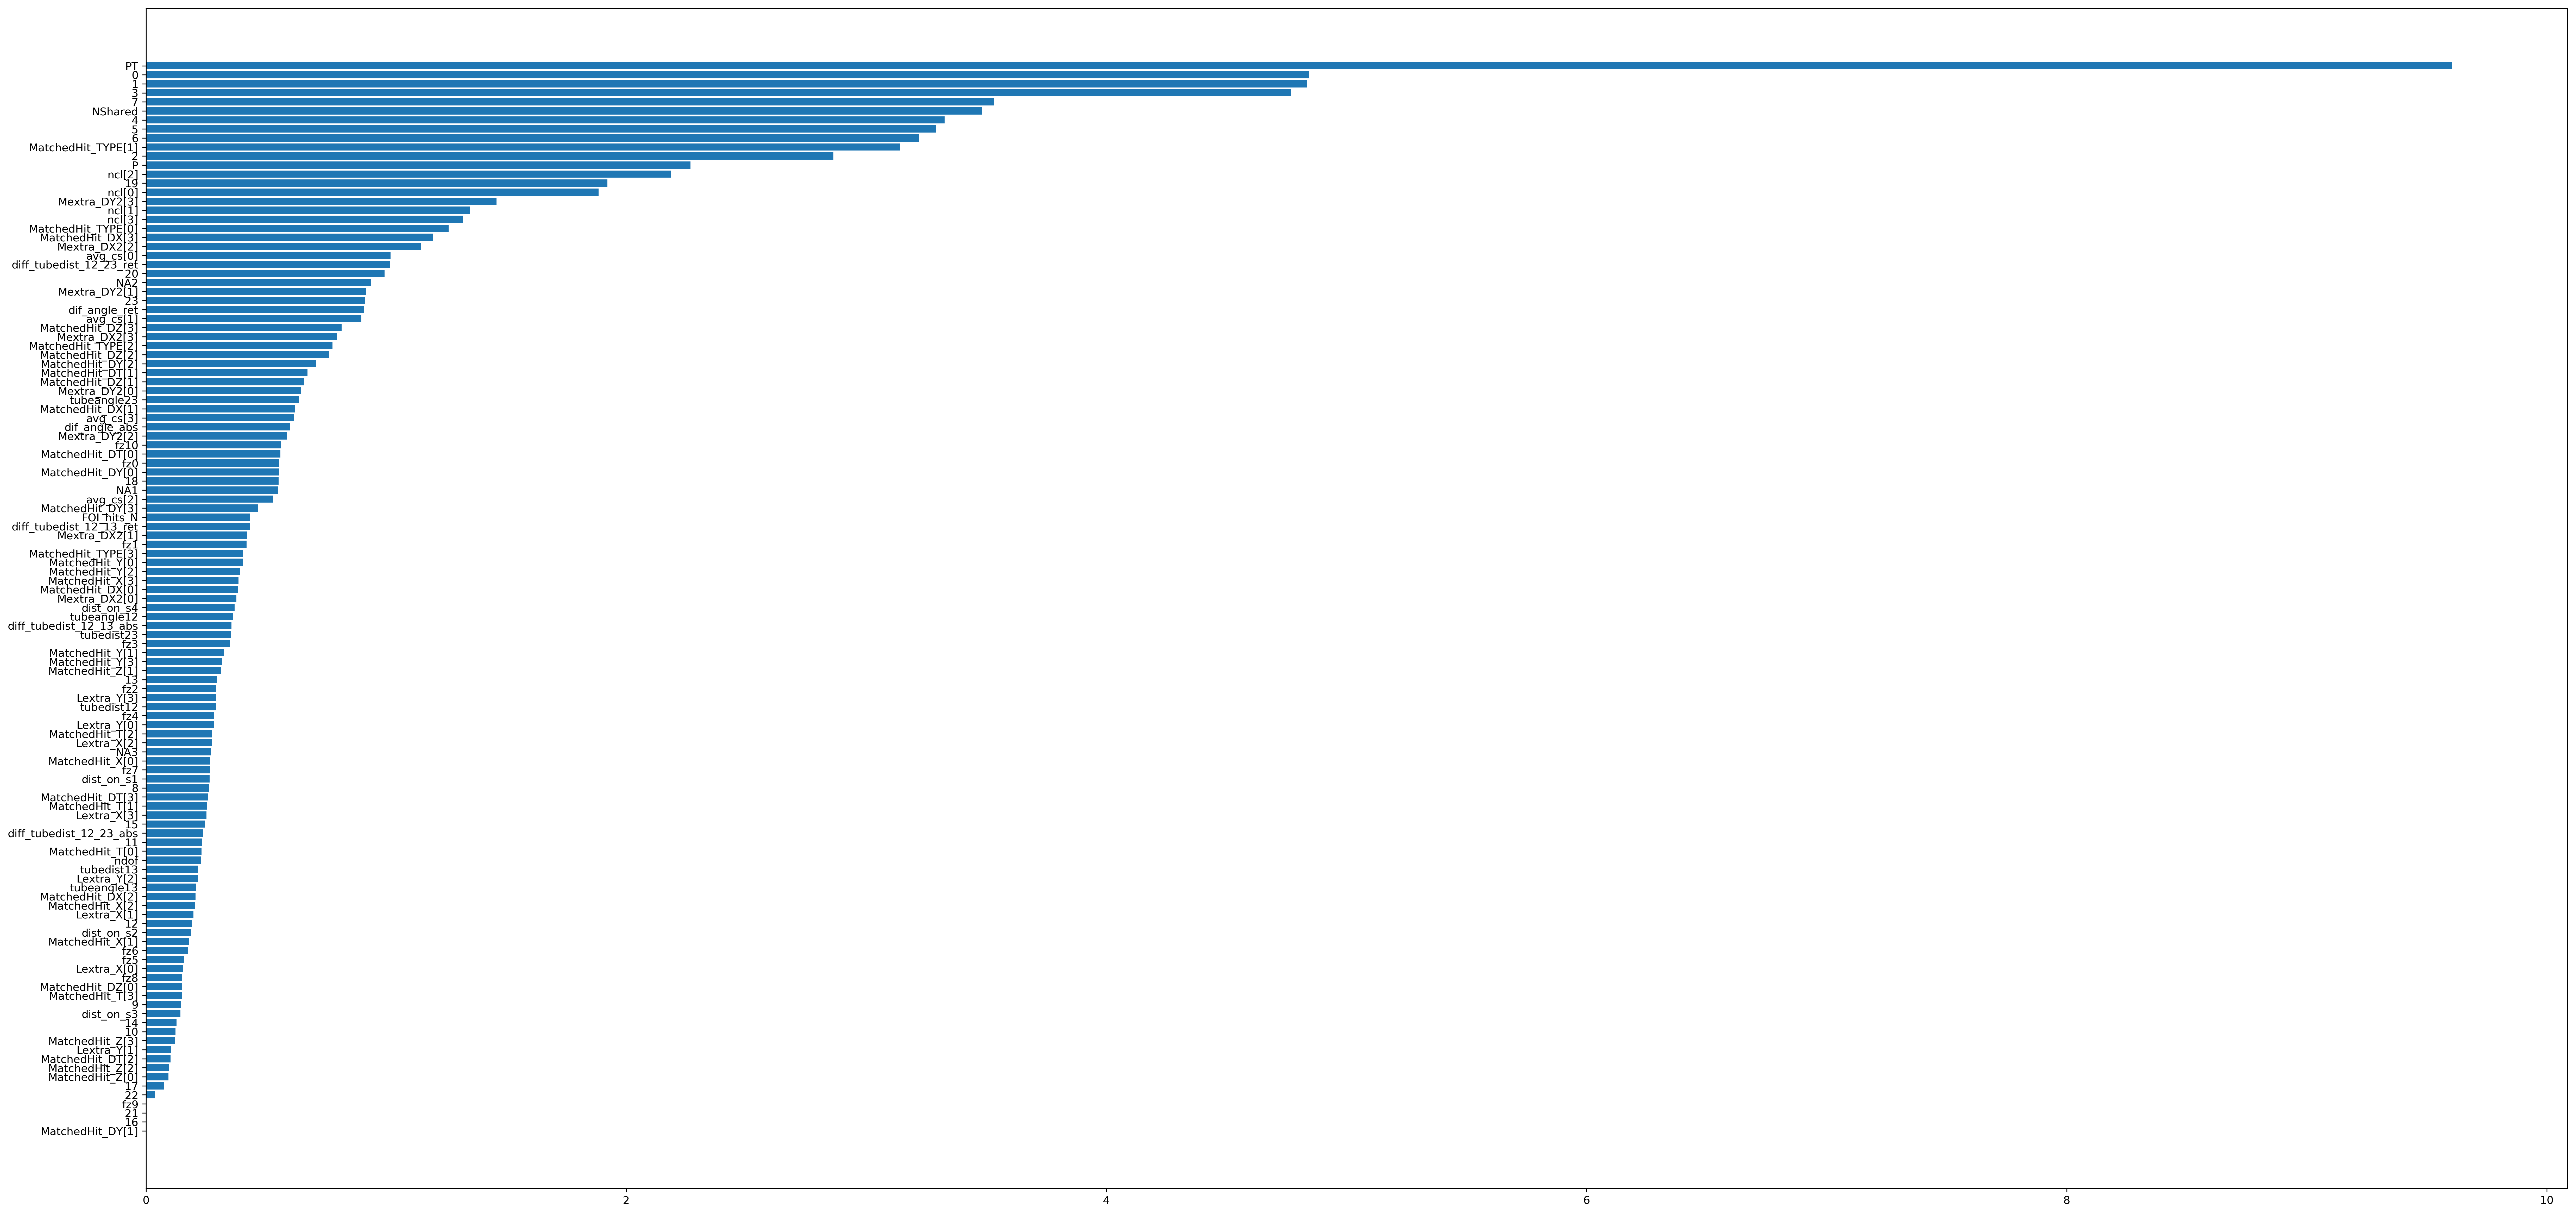

In [99]:
features_dict = plot_importances_pipeline(m)

[('NA1', 0.5494261000994465),
 ('18', 0.5518587083152151),
 ('MatchedHit_DY[0]', 0.5548103914512968),
 ('fz0', 0.5559790832581345),
 ('MatchedHit_DT[0]', 0.5599261479189991),
 ('fz10', 0.5623830411756764),
 ('Mextra_DY2[2]', 0.5866978804866818),
 ('dif_angle_abs', 0.6002497098220906),
 ('avg_cs[3]', 0.6148058981866851),
 ('MatchedHit_DX[1]', 0.6190455116246307),
 ('tubeangle23', 0.6375648644926126),
 ('Mextra_DY2[0]', 0.6452025082146254),
 ('MatchedHit_DZ[1]', 0.6591071053417892),
 ('MatchedHit_DT[1]', 0.6728648991875915),
 ('MatchedHit_DY[2]', 0.7084145221474625),
 ('MatchedHit_DZ[2]', 0.7635658578225876),
 ('MatchedHit_TYPE[2]', 0.7769525107850226),
 ('Mextra_DX2[3]', 0.7964136249859003),
 ('MatchedHit_DZ[3]', 0.8144822283410571),
 ('avg_cs[1]', 0.8968229905559302),
 ('dif_angle_ret', 0.9084458603120633),
 ('23', 0.9127782577568357),
 ('Mextra_DY2[1]', 0.9161438753574863),
 ('NA2', 0.936312113095558),
 ('20', 0.9937258589733396),
 ('diff_tubedist_12_23_ret', 1.0149785117414751),
 ('a

In [105]:
features_dict

OrderedDict([('MatchedHit_DY[1]', 0.0),
             ('16', 0.0),
             ('21', 0.0),
             ('fz9', 0.0),
             ('22', 0.035791508390098856),
             ('17', 0.07651791071402007),
             ('MatchedHit_Z[0]', 0.09378034080839277),
             ('MatchedHit_Z[2]', 0.09604552408063832),
             ('MatchedHit_DT[2]', 0.10202407819605477),
             ('Lextra_Y[1]', 0.10480990649167823),
             ('MatchedHit_Z[3]', 0.122201943095341),
             ('10', 0.12322053615173689),
             ('14', 0.12718137099629434),
             ('dist_on_s3', 0.14375259951076097),
             ('9', 0.1470648760764186),
             ('MatchedHit_T[3]', 0.14929254087674107),
             ('MatchedHit_DZ[0]', 0.14959879527757677),
             ('fz8', 0.15142038367651503),
             ('Lextra_X[0]', 0.15476752689212778),
             ('fz5', 0.1593977088565605),
             ('fz6', 0.17648874348288476),
             ('MatchedHit_X[1]', 0.17772873012137314),
       

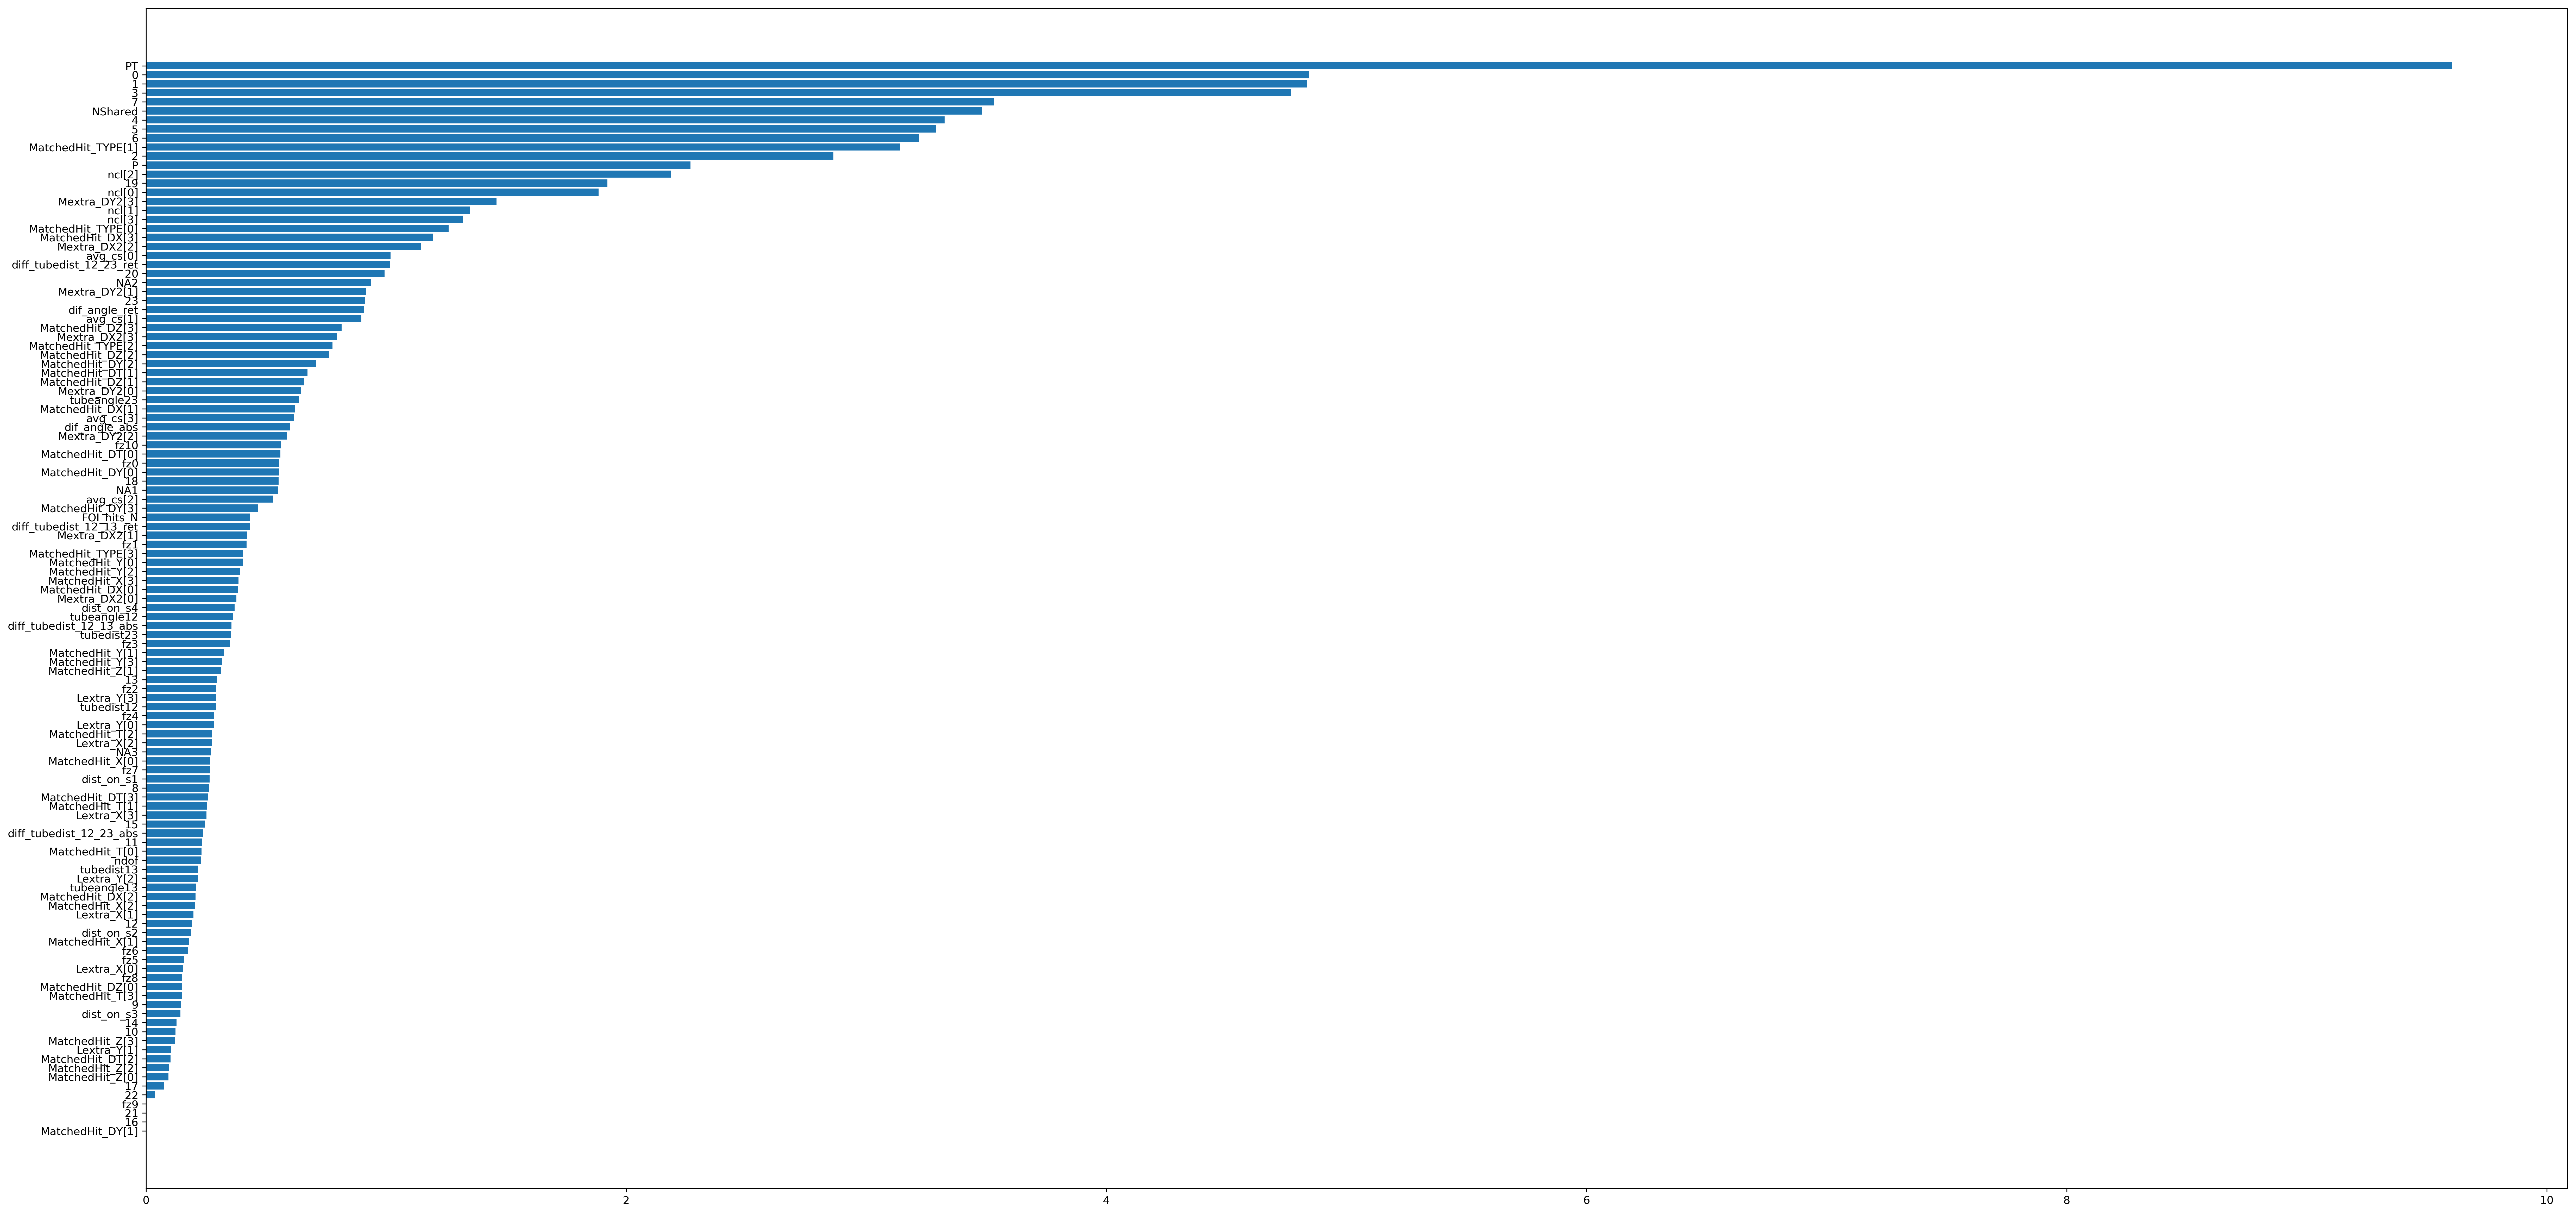

In [85]:
plot_importances_pipeline(m)

In [89]:
list(filter(lambda x:'dif' in x, features))

['diff_tubedist_12_23_abs',
 'diff_tubedist_12_23_ret',
 'diff_tubedist_12_13_abs',
 'diff_tubedist_12_13_ret',
 'dif_angle_abs',
 'dif_angle_ret']

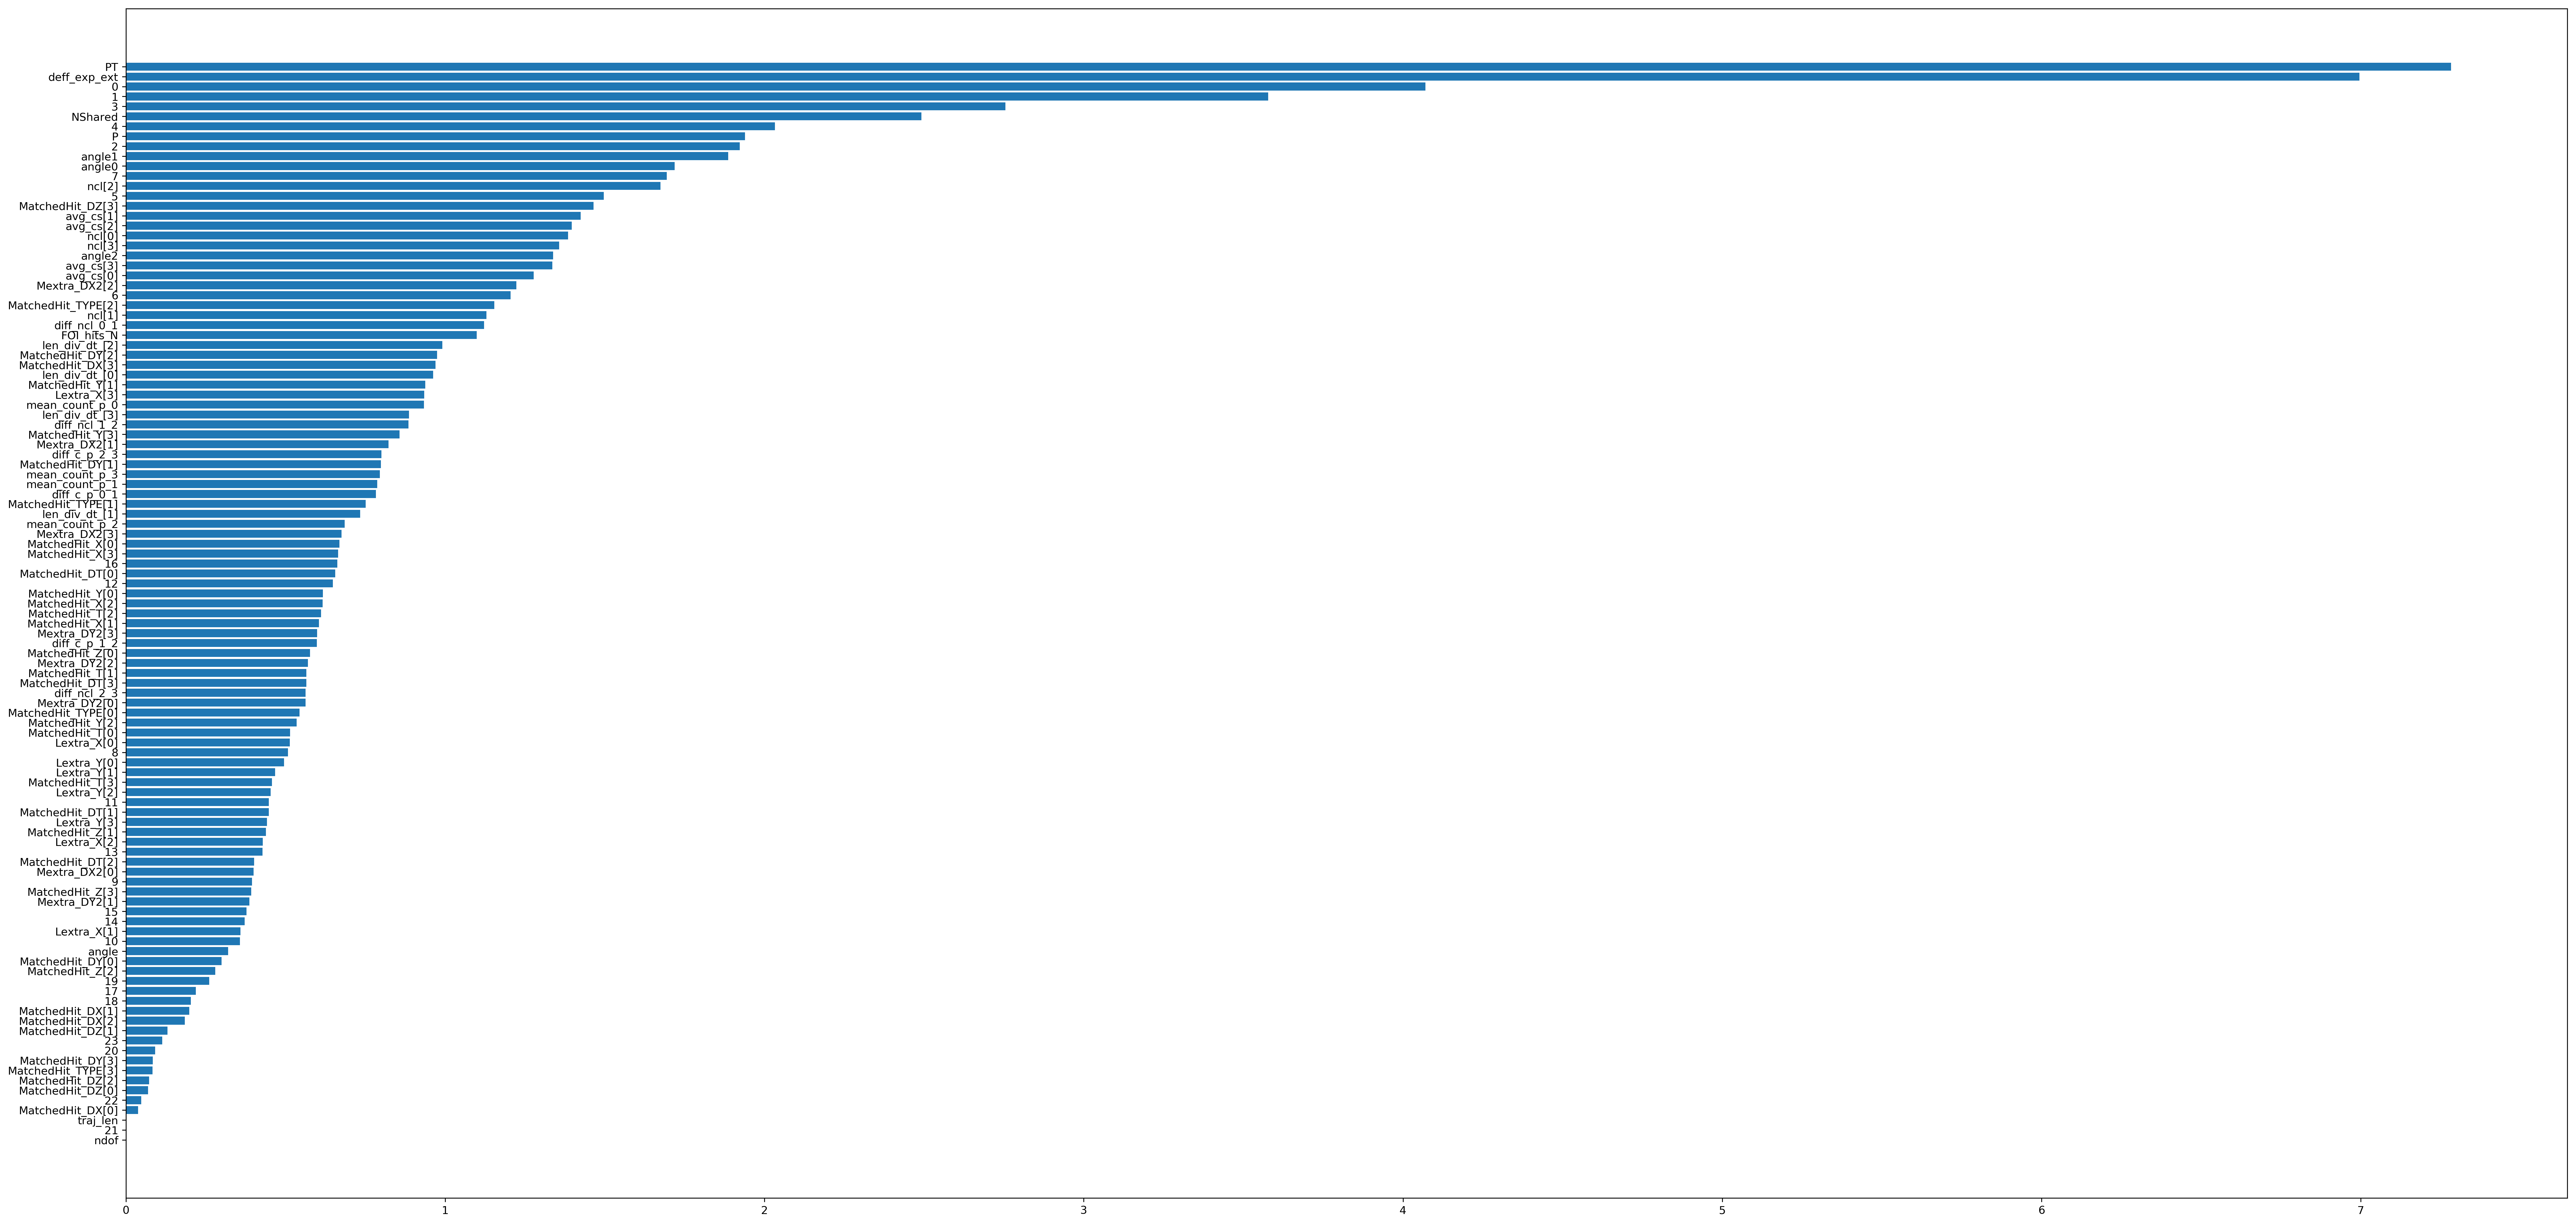

In [83]:
plot_importances_pipeline(model)

In [84]:
# model.steps[1][1].estimator.feature_names_

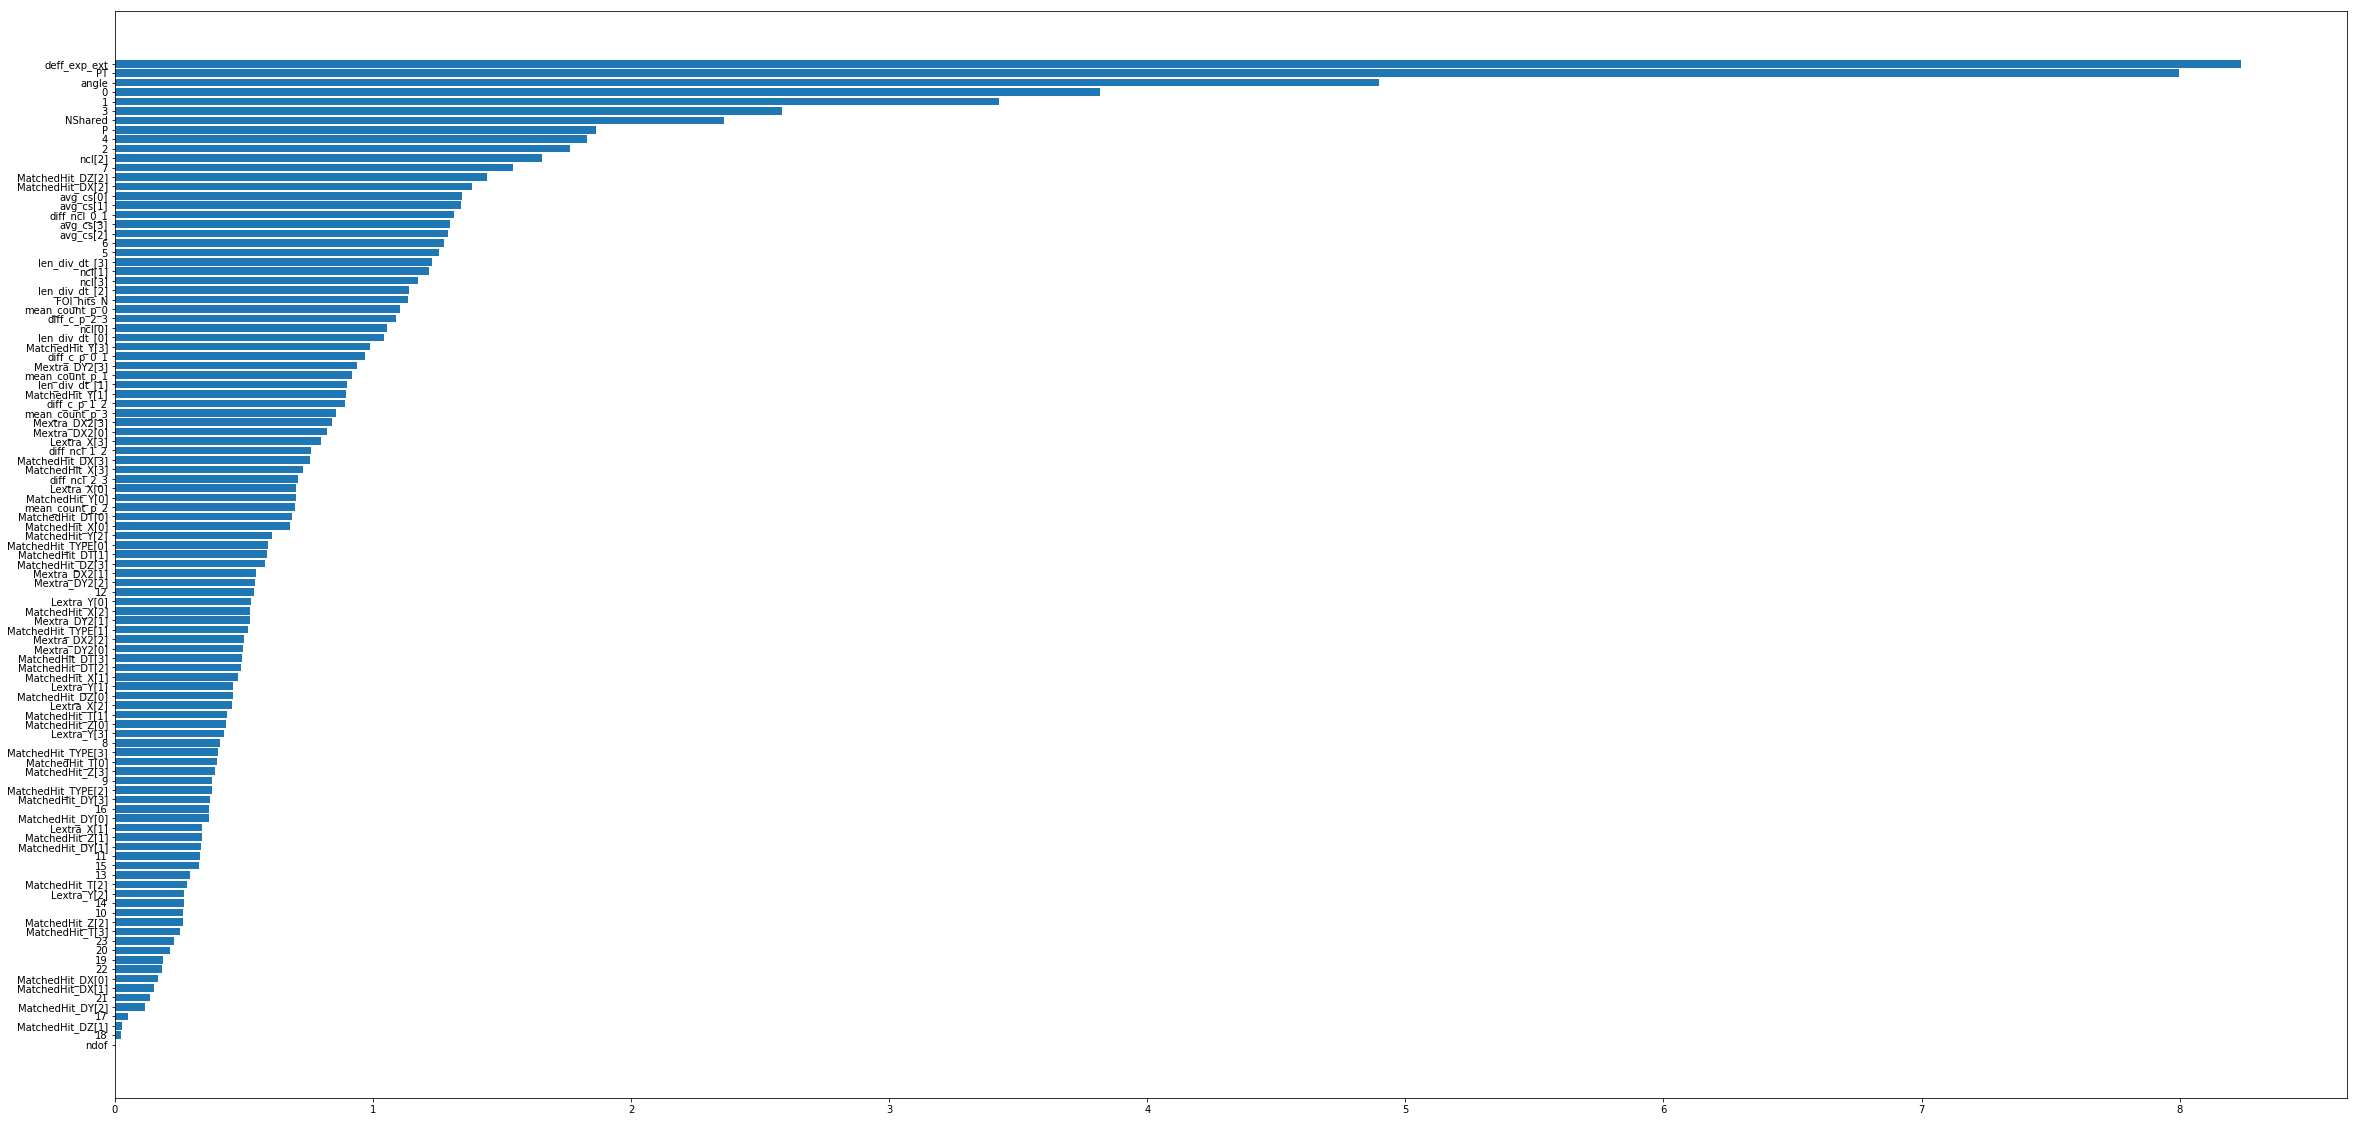

In [256]:
plot_importances_pipeline(model)

In [232]:
model.steps[1][1].estimator.feature_names_

['ncl[0]',
 'ncl[1]',
 'ncl[2]',
 'ncl[3]',
 'avg_cs[0]',
 'avg_cs[1]',
 'avg_cs[2]',
 'avg_cs[3]',
 'ndof',
 'MatchedHit_TYPE[0]',
 'MatchedHit_TYPE[1]',
 'MatchedHit_TYPE[2]',
 'MatchedHit_TYPE[3]',
 'MatchedHit_X[0]',
 'MatchedHit_X[1]',
 'MatchedHit_X[2]',
 'MatchedHit_X[3]',
 'MatchedHit_Y[0]',
 'MatchedHit_Y[1]',
 'MatchedHit_Y[2]',
 'MatchedHit_Y[3]',
 'MatchedHit_Z[0]',
 'MatchedHit_Z[1]',
 'MatchedHit_Z[2]',
 'MatchedHit_Z[3]',
 'MatchedHit_DX[0]',
 'MatchedHit_DX[1]',
 'MatchedHit_DX[2]',
 'MatchedHit_DX[3]',
 'MatchedHit_DY[0]',
 'MatchedHit_DY[1]',
 'MatchedHit_DY[2]',
 'MatchedHit_DY[3]',
 'MatchedHit_DZ[0]',
 'MatchedHit_DZ[1]',
 'MatchedHit_DZ[2]',
 'MatchedHit_DZ[3]',
 'MatchedHit_T[0]',
 'MatchedHit_T[1]',
 'MatchedHit_T[2]',
 'MatchedHit_T[3]',
 'MatchedHit_DT[0]',
 'MatchedHit_DT[1]',
 'MatchedHit_DT[2]',
 'MatchedHit_DT[3]',
 'Lextra_X[0]',
 'Lextra_X[1]',
 'Lextra_X[2]',
 'Lextra_X[3]',
 'Lextra_Y[0]',
 'Lextra_Y[1]',
 'Lextra_Y[2]',
 'Lextra_Y[3]',
 'NShared',
 'M

### FINAL fit-predict,  save submit on all data

In [246]:
%%time

features = list(df_train.keys())
features.remove('label')
# features.remove('weight')
for feat in ['particle_type', 'sWeight', 'kinWeight']:
    if feat in features:
        features.remove(feat)
        
target = ['label']

estimator = catboost.CatBoostClassifier(iterations=2000, max_depth=8, thread_count=32, verbose=True)
clf = ModelClass(estimator = estimator)
transformer = FeatureTransformer()

model = Pipeline([('transformer', transformer),
                  ('clf', clf)])

model.fit(df_train[features], df_train[target])

features.remove('weight')
predictions = model.predict_proba(df_test[features])[:, 1]
pd.DataFrame(data={"prediction": predictions}, index=df_test.index).to_csv(
    "/nis/idao/results/catboost_3_new_features_plus_advanced_baseline_2000iter.csv", index_label='id')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Collision with name angle
Collision with name deff_exp_ext
Collision with name len_div_dt_[0]
Collision with name len_div_dt_[1]
Collision with name len_div_dt_[2]
Collision with name len_div_dt_[3]
Collision with name mean_count_p_0
Collision with name mean_count_p_1
Collision with name mean_count_p_2
Collision with name mean_count_p_3
Collision with name diff_c_p_0_1
Collision with name diff_c_p_1_2
Collision with name diff_c_p_2_3
Collision with name diff_ncl_0_1
Collision with name diff_ncl_1_2
Collision with name diff_ncl_2_3
fitting, using weight


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.103088
0:	learn: 0.6557990	total: 837ms	remaining: 27m 52s
1:	learn: 0.6286513	total: 1.57s	remaining: 26m 13s
2:	learn: 0.6087884	total: 2.27s	remaining: 25m 9s
3:	learn: 0.5909769	total: 3.04s	remaining: 25m 15s
4:	learn: 0.5756416	total: 3.74s	remaining: 24m 51s
5:	learn: 0.5634524	total: 4.41s	remaining: 24m 24s
6:	learn: 0.5538658	total: 5.2s	remaining: 24m 40s
7:	learn: 0.5471332	total: 5.91s	remaining: 24m 32s
8:	learn: 0.5395102	total: 6.6s	remaining: 24m 20s
9:	learn: 0.5336526	total: 7.25s	remaining: 24m 1s
10:	learn: 0.5288643	total: 7.93s	remaining: 23m 54s
11:	learn: 0.5238353	total: 8.69s	remaining: 23m 59s
12:	learn: 0.5201098	total: 9.43s	remaining: 24m 1s
13:	learn: 0.5168593	total: 10.1s	remaining: 23m 50s
14:	learn: 0.5140295	total: 10.7s	remaining: 23m 38s
15:	learn: 0.5114579	total: 11.4s	remaining: 23m 30s
16:	learn: 0.5081142	total: 12.1s	remaining: 23m 30s
17:	learn: 0.5054767	total: 12.8s	remaining: 23m 28s
18:	learn: 0.5032058	total: 13.

153:	learn: 0.4544456	total: 1m 43s	remaining: 20m 43s
154:	learn: 0.4541665	total: 1m 44s	remaining: 20m 43s
155:	learn: 0.4540035	total: 1m 45s	remaining: 20m 42s
156:	learn: 0.4538913	total: 1m 45s	remaining: 20m 40s
157:	learn: 0.4537589	total: 1m 46s	remaining: 20m 39s
158:	learn: 0.4533836	total: 1m 47s	remaining: 20m 39s
159:	learn: 0.4531475	total: 1m 47s	remaining: 20m 38s
160:	learn: 0.4529516	total: 1m 48s	remaining: 20m 39s
161:	learn: 0.4528372	total: 1m 49s	remaining: 20m 37s
162:	learn: 0.4526646	total: 1m 49s	remaining: 20m 36s
163:	learn: 0.4525351	total: 1m 50s	remaining: 20m 35s
164:	learn: 0.4522681	total: 1m 51s	remaining: 20m 35s
165:	learn: 0.4521343	total: 1m 51s	remaining: 20m 34s
166:	learn: 0.4518920	total: 1m 52s	remaining: 20m 33s
167:	learn: 0.4517664	total: 1m 53s	remaining: 20m 34s
168:	learn: 0.4515576	total: 1m 53s	remaining: 20m 34s
169:	learn: 0.4514168	total: 1m 54s	remaining: 20m 34s
170:	learn: 0.4513101	total: 1m 55s	remaining: 20m 33s
171:	learn

304:	learn: 0.4307752	total: 3m 27s	remaining: 19m 15s
305:	learn: 0.4305400	total: 3m 28s	remaining: 19m 14s
306:	learn: 0.4304262	total: 3m 29s	remaining: 19m 14s
307:	learn: 0.4303248	total: 3m 29s	remaining: 19m 13s
308:	learn: 0.4302107	total: 3m 30s	remaining: 19m 12s
309:	learn: 0.4300682	total: 3m 31s	remaining: 19m 12s
310:	learn: 0.4299645	total: 3m 32s	remaining: 19m 11s
311:	learn: 0.4298488	total: 3m 32s	remaining: 19m 10s
312:	learn: 0.4297144	total: 3m 33s	remaining: 19m 10s
313:	learn: 0.4295760	total: 3m 34s	remaining: 19m 10s
314:	learn: 0.4294876	total: 3m 34s	remaining: 19m 9s
315:	learn: 0.4293659	total: 3m 35s	remaining: 19m 8s
316:	learn: 0.4292659	total: 3m 36s	remaining: 19m 7s
317:	learn: 0.4291788	total: 3m 36s	remaining: 19m 6s
318:	learn: 0.4290472	total: 3m 37s	remaining: 19m 6s
319:	learn: 0.4289472	total: 3m 38s	remaining: 19m 5s
320:	learn: 0.4288411	total: 3m 38s	remaining: 19m 4s
321:	learn: 0.4287372	total: 3m 39s	remaining: 19m 4s
322:	learn: 0.4286

455:	learn: 0.4135354	total: 5m 13s	remaining: 17m 40s
456:	learn: 0.4134060	total: 5m 13s	remaining: 17m 39s
457:	learn: 0.4133141	total: 5m 14s	remaining: 17m 38s
458:	learn: 0.4131948	total: 5m 15s	remaining: 17m 38s
459:	learn: 0.4130746	total: 5m 15s	remaining: 17m 37s
460:	learn: 0.4129348	total: 5m 16s	remaining: 17m 36s
461:	learn: 0.4128295	total: 5m 17s	remaining: 17m 36s
462:	learn: 0.4127202	total: 5m 18s	remaining: 17m 35s
463:	learn: 0.4126071	total: 5m 18s	remaining: 17m 35s
464:	learn: 0.4125344	total: 5m 19s	remaining: 17m 34s
465:	learn: 0.4123893	total: 5m 20s	remaining: 17m 33s
466:	learn: 0.4122511	total: 5m 20s	remaining: 17m 33s
467:	learn: 0.4121557	total: 5m 21s	remaining: 17m 32s
468:	learn: 0.4120534	total: 5m 22s	remaining: 17m 32s
469:	learn: 0.4119340	total: 5m 23s	remaining: 17m 31s
470:	learn: 0.4118157	total: 5m 23s	remaining: 17m 30s
471:	learn: 0.4117114	total: 5m 24s	remaining: 17m 30s
472:	learn: 0.4116483	total: 5m 25s	remaining: 17m 29s
473:	learn

605:	learn: 0.3989038	total: 6m 58s	remaining: 16m 3s
606:	learn: 0.3987964	total: 6m 59s	remaining: 16m 3s
607:	learn: 0.3986844	total: 7m	remaining: 16m 2s
608:	learn: 0.3986219	total: 7m 1s	remaining: 16m 1s
609:	learn: 0.3985456	total: 7m 2s	remaining: 16m 1s
610:	learn: 0.3984696	total: 7m 2s	remaining: 16m
611:	learn: 0.3984028	total: 7m 3s	remaining: 16m
612:	learn: 0.3983574	total: 7m 3s	remaining: 15m 59s
613:	learn: 0.3982943	total: 7m 4s	remaining: 15m 58s
614:	learn: 0.3982177	total: 7m 5s	remaining: 15m 57s
615:	learn: 0.3981313	total: 7m 5s	remaining: 15m 56s
616:	learn: 0.3980399	total: 7m 6s	remaining: 15m 56s
617:	learn: 0.3979422	total: 7m 7s	remaining: 15m 55s
618:	learn: 0.3978282	total: 7m 8s	remaining: 15m 55s
619:	learn: 0.3977338	total: 7m 8s	remaining: 15m 54s
620:	learn: 0.3976489	total: 7m 9s	remaining: 15m 53s
621:	learn: 0.3975417	total: 7m 10s	remaining: 15m 53s
622:	learn: 0.3974717	total: 7m 11s	remaining: 15m 52s
623:	learn: 0.3973924	total: 7m 11s	rema

756:	learn: 0.3861637	total: 8m 46s	remaining: 14m 25s
757:	learn: 0.3860887	total: 8m 47s	remaining: 14m 24s
758:	learn: 0.3860266	total: 8m 48s	remaining: 14m 23s
759:	learn: 0.3859764	total: 8m 49s	remaining: 14m 23s
760:	learn: 0.3858824	total: 8m 49s	remaining: 14m 22s
761:	learn: 0.3858246	total: 8m 50s	remaining: 14m 21s
762:	learn: 0.3857273	total: 8m 51s	remaining: 14m 21s
763:	learn: 0.3856864	total: 8m 51s	remaining: 14m 20s
764:	learn: 0.3856120	total: 8m 52s	remaining: 14m 19s
765:	learn: 0.3855666	total: 8m 53s	remaining: 14m 19s
766:	learn: 0.3855071	total: 8m 53s	remaining: 14m 18s
767:	learn: 0.3854262	total: 8m 54s	remaining: 14m 17s
768:	learn: 0.3853522	total: 8m 55s	remaining: 14m 16s
769:	learn: 0.3852572	total: 8m 56s	remaining: 14m 16s
770:	learn: 0.3851865	total: 8m 56s	remaining: 14m 15s
771:	learn: 0.3850672	total: 8m 57s	remaining: 14m 15s
772:	learn: 0.3849368	total: 8m 58s	remaining: 14m 14s
773:	learn: 0.3848568	total: 8m 59s	remaining: 14m 13s
774:	learn

906:	learn: 0.3749559	total: 10m 36s	remaining: 12m 46s
907:	learn: 0.3748816	total: 10m 36s	remaining: 12m 45s
908:	learn: 0.3747980	total: 10m 37s	remaining: 12m 45s
909:	learn: 0.3747212	total: 10m 38s	remaining: 12m 44s
910:	learn: 0.3746444	total: 10m 39s	remaining: 12m 44s
911:	learn: 0.3745578	total: 10m 40s	remaining: 12m 43s
912:	learn: 0.3745056	total: 10m 40s	remaining: 12m 42s
913:	learn: 0.3744310	total: 10m 41s	remaining: 12m 42s
914:	learn: 0.3743958	total: 10m 42s	remaining: 12m 41s
915:	learn: 0.3743259	total: 10m 42s	remaining: 12m 40s
916:	learn: 0.3742545	total: 10m 43s	remaining: 12m 40s
917:	learn: 0.3741625	total: 10m 44s	remaining: 12m 39s
918:	learn: 0.3740712	total: 10m 45s	remaining: 12m 38s
919:	learn: 0.3740006	total: 10m 46s	remaining: 12m 38s
920:	learn: 0.3739306	total: 10m 46s	remaining: 12m 37s
921:	learn: 0.3738561	total: 10m 47s	remaining: 12m 37s
922:	learn: 0.3738051	total: 10m 48s	remaining: 12m 36s
923:	learn: 0.3737243	total: 10m 49s	remaining: 

1053:	learn: 0.3646960	total: 12m 26s	remaining: 11m 9s
1054:	learn: 0.3646457	total: 12m 26s	remaining: 11m 8s
1055:	learn: 0.3645870	total: 12m 27s	remaining: 11m 8s
1056:	learn: 0.3645193	total: 12m 28s	remaining: 11m 7s
1057:	learn: 0.3644681	total: 12m 28s	remaining: 11m 6s
1058:	learn: 0.3644042	total: 12m 29s	remaining: 11m 6s
1059:	learn: 0.3643493	total: 12m 30s	remaining: 11m 5s
1060:	learn: 0.3642678	total: 12m 31s	remaining: 11m 4s
1061:	learn: 0.3641940	total: 12m 32s	remaining: 11m 4s
1062:	learn: 0.3641117	total: 12m 32s	remaining: 11m 3s
1063:	learn: 0.3640416	total: 12m 33s	remaining: 11m 2s
1064:	learn: 0.3639809	total: 12m 34s	remaining: 11m 2s
1065:	learn: 0.3639107	total: 12m 35s	remaining: 11m 1s
1066:	learn: 0.3638537	total: 12m 35s	remaining: 11m
1067:	learn: 0.3637906	total: 12m 36s	remaining: 11m
1068:	learn: 0.3637347	total: 12m 37s	remaining: 10m 59s
1069:	learn: 0.3636827	total: 12m 37s	remaining: 10m 58s
1070:	learn: 0.3636268	total: 12m 38s	remaining: 10m

1199:	learn: 0.3556844	total: 14m 15s	remaining: 9m 30s
1200:	learn: 0.3556443	total: 14m 16s	remaining: 9m 29s
1201:	learn: 0.3555674	total: 14m 16s	remaining: 9m 28s
1202:	learn: 0.3555036	total: 14m 17s	remaining: 9m 28s
1203:	learn: 0.3554375	total: 14m 18s	remaining: 9m 27s
1204:	learn: 0.3553796	total: 14m 19s	remaining: 9m 26s
1205:	learn: 0.3553190	total: 14m 19s	remaining: 9m 26s
1206:	learn: 0.3552291	total: 14m 20s	remaining: 9m 25s
1207:	learn: 0.3551680	total: 14m 21s	remaining: 9m 24s
1208:	learn: 0.3550948	total: 14m 22s	remaining: 9m 24s
1209:	learn: 0.3550326	total: 14m 22s	remaining: 9m 23s
1210:	learn: 0.3549790	total: 14m 23s	remaining: 9m 22s
1211:	learn: 0.3549116	total: 14m 24s	remaining: 9m 21s
1212:	learn: 0.3548582	total: 14m 25s	remaining: 9m 21s
1213:	learn: 0.3547946	total: 14m 25s	remaining: 9m 20s
1214:	learn: 0.3547467	total: 14m 26s	remaining: 9m 19s
1215:	learn: 0.3547051	total: 14m 27s	remaining: 9m 19s
1216:	learn: 0.3546506	total: 14m 27s	remaining:

1347:	learn: 0.3474045	total: 16m 2s	remaining: 7m 45s
1348:	learn: 0.3473419	total: 16m 3s	remaining: 7m 44s
1349:	learn: 0.3472942	total: 16m 4s	remaining: 7m 44s
1350:	learn: 0.3472593	total: 16m 4s	remaining: 7m 43s
1351:	learn: 0.3472123	total: 16m 5s	remaining: 7m 42s
1352:	learn: 0.3471485	total: 16m 6s	remaining: 7m 42s
1353:	learn: 0.3470807	total: 16m 7s	remaining: 7m 41s
1354:	learn: 0.3470353	total: 16m 8s	remaining: 7m 40s
1355:	learn: 0.3470023	total: 16m 8s	remaining: 7m 40s
1356:	learn: 0.3469301	total: 16m 9s	remaining: 7m 39s
1357:	learn: 0.3468760	total: 16m 10s	remaining: 7m 38s
1358:	learn: 0.3468285	total: 16m 10s	remaining: 7m 37s
1359:	learn: 0.3467742	total: 16m 11s	remaining: 7m 37s
1360:	learn: 0.3467368	total: 16m 12s	remaining: 7m 36s
1361:	learn: 0.3466735	total: 16m 12s	remaining: 7m 35s
1362:	learn: 0.3466001	total: 16m 13s	remaining: 7m 35s
1363:	learn: 0.3465277	total: 16m 14s	remaining: 7m 34s
1364:	learn: 0.3464710	total: 16m 15s	remaining: 7m 33s
13

1495:	learn: 0.3395167	total: 17m 51s	remaining: 6m
1496:	learn: 0.3394483	total: 17m 52s	remaining: 6m
1497:	learn: 0.3394045	total: 17m 52s	remaining: 5m 59s
1498:	learn: 0.3393607	total: 17m 53s	remaining: 5m 58s
1499:	learn: 0.3393129	total: 17m 54s	remaining: 5m 58s
1500:	learn: 0.3392702	total: 17m 55s	remaining: 5m 57s
1501:	learn: 0.3392143	total: 17m 55s	remaining: 5m 56s
1502:	learn: 0.3391574	total: 17m 56s	remaining: 5m 56s
1503:	learn: 0.3391147	total: 17m 57s	remaining: 5m 55s
1504:	learn: 0.3390496	total: 17m 58s	remaining: 5m 54s
1505:	learn: 0.3389828	total: 17m 58s	remaining: 5m 53s
1506:	learn: 0.3389326	total: 17m 59s	remaining: 5m 53s
1507:	learn: 0.3388834	total: 18m	remaining: 5m 52s
1508:	learn: 0.3388487	total: 18m 1s	remaining: 5m 51s
1509:	learn: 0.3388178	total: 18m 1s	remaining: 5m 51s
1510:	learn: 0.3387806	total: 18m 2s	remaining: 5m 50s
1511:	learn: 0.3387333	total: 18m 3s	remaining: 5m 49s
1512:	learn: 0.3386811	total: 18m 3s	remaining: 5m 48s
1513:	lea

1643:	learn: 0.3322389	total: 19m 39s	remaining: 4m 15s
1644:	learn: 0.3321985	total: 19m 40s	remaining: 4m 14s
1645:	learn: 0.3321468	total: 19m 41s	remaining: 4m 14s
1646:	learn: 0.3321142	total: 19m 41s	remaining: 4m 13s
1647:	learn: 0.3320665	total: 19m 42s	remaining: 4m 12s
1648:	learn: 0.3320097	total: 19m 43s	remaining: 4m 11s
1649:	learn: 0.3319602	total: 19m 44s	remaining: 4m 11s
1650:	learn: 0.3319314	total: 19m 44s	remaining: 4m 10s
1651:	learn: 0.3318897	total: 19m 45s	remaining: 4m 9s
1652:	learn: 0.3318514	total: 19m 46s	remaining: 4m 9s
1653:	learn: 0.3317868	total: 19m 46s	remaining: 4m 8s
1654:	learn: 0.3317320	total: 19m 47s	remaining: 4m 7s
1655:	learn: 0.3316891	total: 19m 48s	remaining: 4m 6s
1656:	learn: 0.3316411	total: 19m 49s	remaining: 4m 6s
1657:	learn: 0.3315896	total: 19m 50s	remaining: 4m 5s
1658:	learn: 0.3315539	total: 19m 50s	remaining: 4m 4s
1659:	learn: 0.3315049	total: 19m 51s	remaining: 4m 4s
1660:	learn: 0.3314550	total: 19m 52s	remaining: 4m 3s
16

1791:	learn: 0.3253753	total: 21m 28s	remaining: 2m 29s
1792:	learn: 0.3253141	total: 21m 29s	remaining: 2m 28s
1793:	learn: 0.3252798	total: 21m 30s	remaining: 2m 28s
1794:	learn: 0.3252385	total: 21m 30s	remaining: 2m 27s
1795:	learn: 0.3251949	total: 21m 31s	remaining: 2m 26s
1796:	learn: 0.3251476	total: 21m 32s	remaining: 2m 25s
1797:	learn: 0.3251047	total: 21m 33s	remaining: 2m 25s
1798:	learn: 0.3250559	total: 21m 33s	remaining: 2m 24s
1799:	learn: 0.3250209	total: 21m 34s	remaining: 2m 23s
1800:	learn: 0.3249731	total: 21m 35s	remaining: 2m 23s
1801:	learn: 0.3249018	total: 21m 36s	remaining: 2m 22s
1802:	learn: 0.3248504	total: 21m 36s	remaining: 2m 21s
1803:	learn: 0.3248115	total: 21m 37s	remaining: 2m 20s
1804:	learn: 0.3247556	total: 21m 38s	remaining: 2m 20s
1805:	learn: 0.3247226	total: 21m 39s	remaining: 2m 19s
1806:	learn: 0.3246713	total: 21m 39s	remaining: 2m 18s
1807:	learn: 0.3246486	total: 21m 40s	remaining: 2m 18s
1808:	learn: 0.3246077	total: 21m 41s	remaining:

1940:	learn: 0.3188999	total: 23m 18s	remaining: 42.5s
1941:	learn: 0.3188534	total: 23m 19s	remaining: 41.8s
1942:	learn: 0.3188098	total: 23m 20s	remaining: 41.1s
1943:	learn: 0.3187582	total: 23m 20s	remaining: 40.4s
1944:	learn: 0.3187207	total: 23m 21s	remaining: 39.6s
1945:	learn: 0.3186839	total: 23m 22s	remaining: 38.9s
1946:	learn: 0.3186366	total: 23m 23s	remaining: 38.2s
1947:	learn: 0.3185894	total: 23m 24s	remaining: 37.5s
1948:	learn: 0.3185525	total: 23m 24s	remaining: 36.8s
1949:	learn: 0.3185006	total: 23m 25s	remaining: 36s
1950:	learn: 0.3184508	total: 23m 26s	remaining: 35.3s
1951:	learn: 0.3184085	total: 23m 27s	remaining: 34.6s
1952:	learn: 0.3183780	total: 23m 27s	remaining: 33.9s
1953:	learn: 0.3183395	total: 23m 28s	remaining: 33.2s
1954:	learn: 0.3183061	total: 23m 29s	remaining: 32.4s
1955:	learn: 0.3182669	total: 23m 29s	remaining: 31.7s
1956:	learn: 0.3182218	total: 23m 30s	remaining: 31s
1957:	learn: 0.3181912	total: 23m 31s	remaining: 30.3s
1958:	learn: 0

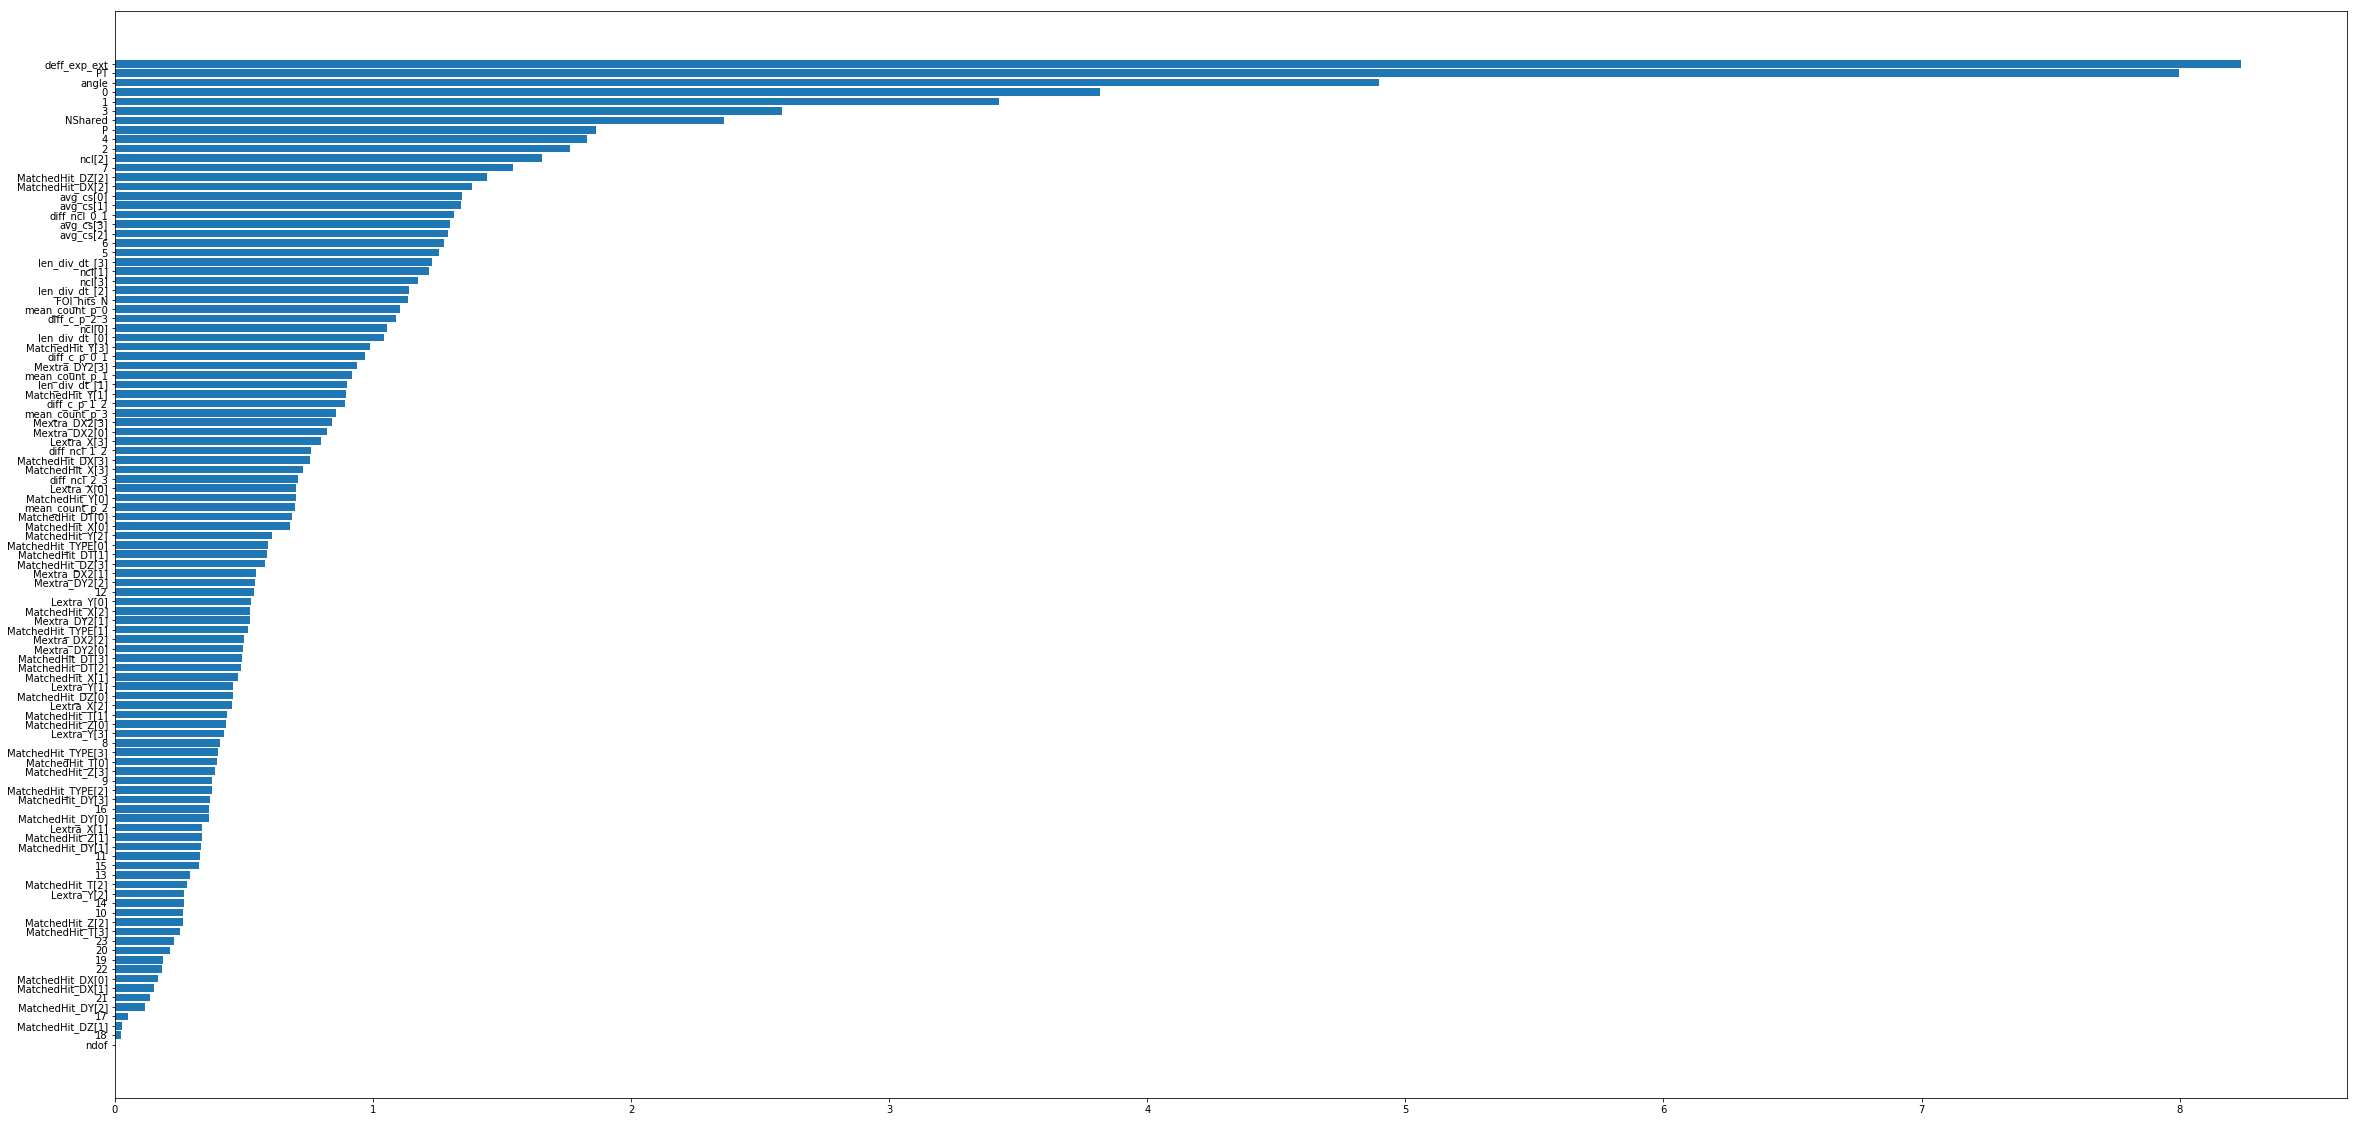

In [251]:
plot_importances_pipeline(model)

In [252]:
def features_by_importances_pipeline(model, thr=1):
    return [k for k, v in zip(model.steps[1][1].estimator.feature_names_,
                                     model.steps[1][1].estimator.feature_importances_) if v > thr]

leave_features = features_by_importances_pipeline(model)
print(leave_features, len(leave_features))

['ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'avg_cs[0]', 'avg_cs[1]', 'avg_cs[2]', 'avg_cs[3]', 'MatchedHit_DX[2]', 'MatchedHit_DZ[2]', 'NShared', 'FOI_hits_N', 'PT', 'P', '0', '1', '2', '3', '4', '5', '6', '7', 'angle', 'deff_exp_ext', 'len_div_dt_[0]', 'len_div_dt_[2]', 'len_div_dt_[3]', 'mean_count_p_0', 'diff_c_p_2_3', 'diff_ncl_0_1'] 30


In [ ]:
# features.remove('weight')
# features.remove('kinWeight')

In [63]:
predictions = model.predict_proba(df_test[features])[:, 1]
pd.DataFrame(data={"prediction": predictions}, index=df_test.index).to_csv(
    "/nis/idao/results/catboost_all_features_5feb.csv", index_label='id')

In [248]:
### local not correct validation ###
y_predict_proba = model.predict_proba(df_validation[features])[:, 1]
y_predict = model.predict(df_validation[features])

print(classification_report(y_predict, df_validation.label.values))
print('rejection90:\t', str(scoring.rejection90(df_validation.label.values, 
                                                y_predict_proba, 
                                                sample_weight=df_validation.weight.values)))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Collision with name angle
Collision with name deff_exp_ext
Collision with name len_div_dt_[0]
Collision with name len_div_dt_[1]
Collision with name len_div_dt_[2]
Collision with name len_div_dt_[3]
Collision with name mean_count_p_0
Collision with name mean_count_p_1
Collision with name mean_count_p_2
Collision with name mean_count_p_3
Collision with name diff_c_p_0_1
Collision with name diff_c_p_1_2
Collision with name diff_c_p_2_3
Collision with name diff_ncl_0_1
Collision with name diff_ncl_1_2
Collision with name diff_ncl_2_3
Collision with name angle
Collision with name deff_exp_ext
Collision with name len_div_dt_[0]
Collision with name len_div_dt_[1]
Collision with name len_div_dt_[2]
Collision with name len_div_dt_[3]
Collision with name mean_count_p_0
Collision with name mean_count_p_1
Collision with name mean_count_p_2
Collision with name mean_count_p_3
Collision with name diff_c_p_0_1
Collision with name diff_c_p_1_2
Collision with name diff_c_p_2_3
Collision with name diff_

In [236]:
# features

In [237]:
# model.steps[1][1].estimator.feature_names_

In [128]:
### local not correct validation ###
y_predict_proba = model.predict_proba(df_validation[features])[:, 1]
y_predict = model.predict(df_validation[features])

print(classification_report(y_predict, df_validation.label.values))
print('rejection90:\t', str(scoring.rejection90(df_validation.label.values, 
                                                y_predict_proba, 
                                                sample_weight=df_validation.weight.values)))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


             precision    recall  f1-score   support

        0.0       0.76      0.29      0.42    273374
        1.0       0.85      0.98      0.91   1088053

avg / total       0.83      0.84      0.81   1361427

rejection90:	 0.9151348841119508


In [32]:
# # model.steps[0][1].SIMPLE_FEATURES.remove('weight')
# predictions = model.predict_proba(df_test)[:, 1]
# pd.DataFrame(data={"prediction": predictions}, index=df_test.index).to_csv(
#     "/nis/idao/results/xgb_3_new_features_plus_advanced_baseline.csv", index_label='id')

In [57]:
print('FINISH')

FINISH


In [ ]:
# scoring.rejection90(df_validation.label.values, y_predicted, sample_weight=df_validation.weight.values)

#### RESULTS:
    ====[  2  ]=============================================================
    all numeric features + 3 feature + xgb with our metric  [03.02.18 21:39]


         precision    recall  f1-score   support

              0       0.72      0.19      0.30    408686
              1       0.74      0.97      0.84    952741

    avg / total       0.73      0.73      0.67   1361427

    rejection90:	 0.7001187352573887
    ====[  1  ]=============================================================
    all numeric features + xgb with out weights  [03.02.18 20:35]
                   precision    recall  f1-score   support

              0       0.28      0.70      0.40     42814
              1       0.99      0.94      0.97   1318613

    avg / total       0.97      0.94      0.95   1361427

    rejection90:	 0.47724133495185816
    ====[  0  ]==============================================================
    all numeric features + xgb with weights  [03.02.18 20:30]

               precision    recall  f1-score   support

          0       0.71      0.13      0.22    567329
          1       0.61      0.96      0.74    794098

    avg / total       0.65      0.62      0.53   1361427

    rejection90:	 0.5487125090232358
    

## FEATURE IMPORTANCE

In [30]:
features = list(df_train.keys())
features.remove('label')
# features.remove('weight')
features.remove('particle_type')
target = ['label']

Index(['id', 'ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'avg_cs[0]', 'avg_cs[1]',
       'avg_cs[2]', 'avg_cs[3]', 'ndof', 'MatchedHit_TYPE[0]',
       'MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]',
       'MatchedHit_X[0]', 'MatchedHit_X[1]', 'MatchedHit_X[2]',
       'MatchedHit_X[3]', 'MatchedHit_Y[0]', 'MatchedHit_Y[1]',
       'MatchedHit_Y[2]', 'MatchedHit_Y[3]', 'MatchedHit_Z[0]',
       'MatchedHit_Z[1]', 'MatchedHit_Z[2]', 'MatchedHit_Z[3]',
       'MatchedHit_DX[0]', 'MatchedHit_DX[1]', 'MatchedHit_DX[2]',
       'MatchedHit_DX[3]', 'MatchedHit_DY[0]', 'MatchedHit_DY[1]',
       'MatchedHit_DY[2]', 'MatchedHit_DY[3]', 'MatchedHit_DZ[0]',
       'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]',
       'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_T[2]',
       'MatchedHit_T[3]', 'MatchedHit_DT[0]', 'MatchedHit_DT[1]',
       'MatchedHit_DT[2]', 'MatchedHit_DT[3]', 'Lextra_X[0]', 'Lextra_X[1]',
       'Lextra_X[2]', 'Lextra_X[3]', 'Lextra_Y[0]', 'L

In [48]:
import pickle
pickle.dump(model, open('../results/model3feature.pickle', 'wb'))

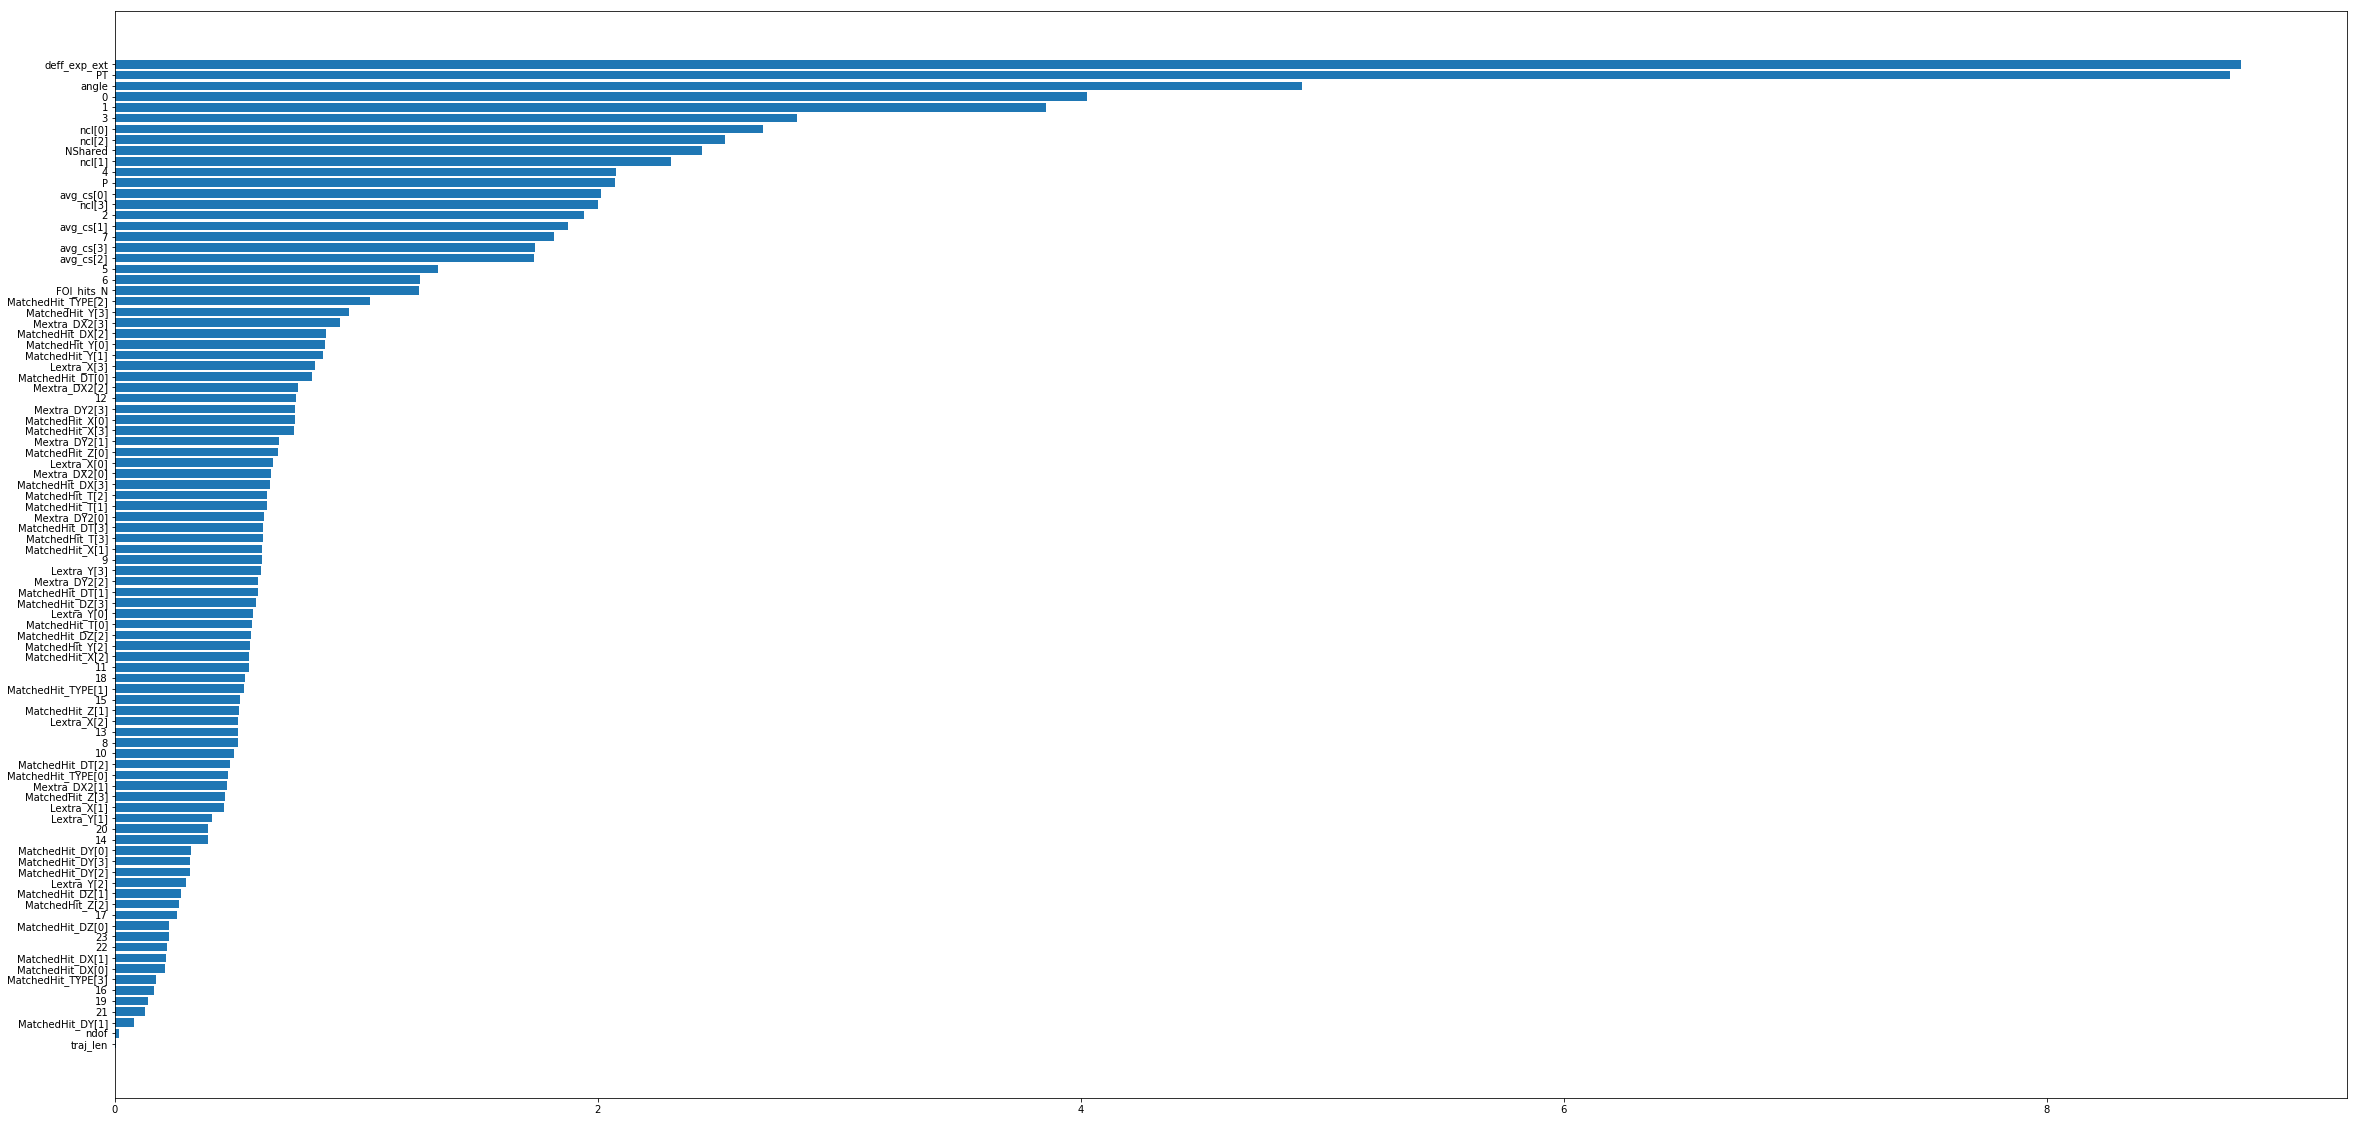

In [75]:
from collections import OrderedDict
from matplotlib import pyplot as plt
%matplotlib inline
feature_dict = {k:v for k,v in zip(model.steps[1][1].estimator.feature_names_, 
                                   model.steps[1][1].estimator.feature_importances_)}
feature_dict = OrderedDict(sorted(feature_dict.items(), key = lambda x:x[1]))

plt.figure(figsize = (40, 20))
plt.barh(list(range(len(feature_dict))), list(feature_dict.values()))
plt.yticks(range(len(feature_dict)), list(feature_dict.keys()))
plt.show()

### Отбор топ признаков по feature importance
Берем все, выкидываем по одной, меряем результат 

In [107]:
from collections import OrderedDict
OrderedDict(sorted(feature_dict.items(), key = lambda x:-x[1])[:23])

OrderedDict([('deff_exp_ext', 8.804120174319149),
             ('PT', 8.758313099910206),
             ('angle', 4.918251243418498),
             ('0', 4.024152886514487),
             ('1', 3.8553065192247695),
             ('3', 2.825593699667395),
             ('ncl[0]', 2.6860491510293927),
             ('ncl[2]', 2.527150024358813),
             ('NShared', 2.430836060615589),
             ('ncl[1]', 2.303511369556742),
             ('4', 2.0741098104085127),
             ('P', 2.072738604259885),
             ('avg_cs[0]', 2.012199735115815),
             ('ncl[3]', 1.9998863180379158),
             ('2', 1.9433636153717195),
             ('avg_cs[1]', 1.877148863683655),
             ('7', 1.8188042272937226),
             ('avg_cs[3]', 1.740507522041244),
             ('avg_cs[2]', 1.7367453465346825),
             ('5', 1.3395454355727452),
             ('6', 1.2654366185778345),
             ('FOI_hits_N', 1.2573693271668087),
             ('MatchedHit_TYPE[2]', 1.05576056905

In [234]:
new_features = [i[0] for i in (sorted(feature_dict.items(), key = lambda x:-x[1])[:23])]
for i in range(24):
    if str(i) not in new_features:
        new_features.append(str(i))

In [235]:
new_features

['deff_exp_ext',
 'PT',
 'angle',
 '0',
 '1',
 '3',
 'ncl[0]',
 'ncl[2]',
 'NShared',
 'ncl[1]',
 '4',
 'P',
 'avg_cs[0]',
 'ncl[3]',
 '2',
 'avg_cs[1]',
 '7',
 'avg_cs[3]',
 'avg_cs[2]',
 '5',
 '6',
 'FOI_hits_N',
 'MatchedHit_TYPE[2]',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23']

In [127]:
%%time

features = list(df_train.keys())
features.remove('label')
# features.remove('weight')
for feat in ['particle_type', 'sWeight', 'kinWeight']:
    if feat in features:
        features.remove(feat)
        
if 'weight' not in new_features:
    new_features = new_features+['weight']  

target = ['label']

estimator = catboost.CatBoostClassifier(iterations=2000, max_depth=8, thread_count=32, verbose=True)
clf = ModelClass(estimator = estimator, features = new_features)
transformer = FeatureTransformer()

model = Pipeline([('transformer', transformer),
                  ('clf', clf)])

model.fit(df_train[features], df_train[target])

features.remove('weight')
predictions = model.predict_proba(df_test[features])[:, 1]
pd.DataFrame(data={"prediction": predictions}, index=df_test.index).to_csv(
    "/nis/idao/results/catboost_3_new_features_plus_advanced_baseline_2000iter_only47_features.csv", index_label='id')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


fitting, using weight


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.103088
0:	learn: 0.6532984	total: 744ms	remaining: 24m 47s
1:	learn: 0.6251580	total: 1.38s	remaining: 22m 59s
2:	learn: 0.6040420	total: 2.03s	remaining: 22m 33s
3:	learn: 0.5866740	total: 2.69s	remaining: 22m 24s
4:	learn: 0.5732421	total: 3.36s	remaining: 22m 22s
5:	learn: 0.5631843	total: 4.12s	remaining: 22m 50s
6:	learn: 0.5527629	total: 4.82s	remaining: 22m 53s
7:	learn: 0.5461536	total: 5.4s	remaining: 22m 23s
8:	learn: 0.5387807	total: 6.06s	remaining: 22m 20s
9:	learn: 0.5338043	total: 6.68s	remaining: 22m 8s
10:	learn: 0.5289516	total: 7.31s	remaining: 22m 1s
11:	learn: 0.5247453	total: 8.03s	remaining: 22m 10s
12:	learn: 0.5206777	total: 8.67s	remaining: 22m 5s
13:	learn: 0.5175835	total: 9.32s	remaining: 22m 2s
14:	learn: 0.5141687	total: 9.94s	remaining: 21m 54s
15:	learn: 0.5109536	total: 10.6s	remaining: 21m 51s
16:	learn: 0.5087384	total: 11.2s	remaining: 21m 45s
17:	learn: 0.5065802	total: 11.8s	remaining: 21m 37s
18:	learn: 0.5040554	total: 12.

154:	learn: 0.4539635	total: 1m 36s	remaining: 19m 13s
155:	learn: 0.4538422	total: 1m 37s	remaining: 19m 13s
156:	learn: 0.4535461	total: 1m 38s	remaining: 19m 13s
157:	learn: 0.4534195	total: 1m 38s	remaining: 19m 12s
158:	learn: 0.4533122	total: 1m 39s	remaining: 19m 12s
159:	learn: 0.4531739	total: 1m 40s	remaining: 19m 11s
160:	learn: 0.4529525	total: 1m 40s	remaining: 19m 12s
161:	learn: 0.4527699	total: 1m 41s	remaining: 19m 10s
162:	learn: 0.4526451	total: 1m 41s	remaining: 19m 8s
163:	learn: 0.4524452	total: 1m 42s	remaining: 19m 7s
164:	learn: 0.4522119	total: 1m 43s	remaining: 19m 7s
165:	learn: 0.4520314	total: 1m 43s	remaining: 19m 7s
166:	learn: 0.4518290	total: 1m 44s	remaining: 19m 7s
167:	learn: 0.4517061	total: 1m 45s	remaining: 19m 6s
168:	learn: 0.4514819	total: 1m 45s	remaining: 19m 6s
169:	learn: 0.4513469	total: 1m 46s	remaining: 19m 5s
170:	learn: 0.4511521	total: 1m 47s	remaining: 19m 4s
171:	learn: 0.4509710	total: 1m 47s	remaining: 19m 4s
172:	learn: 0.450826

305:	learn: 0.4309978	total: 3m 12s	remaining: 17m 46s
306:	learn: 0.4308489	total: 3m 13s	remaining: 17m 46s
307:	learn: 0.4307857	total: 3m 14s	remaining: 17m 45s
308:	learn: 0.4306715	total: 3m 14s	remaining: 17m 44s
309:	learn: 0.4305833	total: 3m 15s	remaining: 17m 44s
310:	learn: 0.4304203	total: 3m 15s	remaining: 17m 43s
311:	learn: 0.4302769	total: 3m 16s	remaining: 17m 42s
312:	learn: 0.4301428	total: 3m 17s	remaining: 17m 42s
313:	learn: 0.4300480	total: 3m 17s	remaining: 17m 42s
314:	learn: 0.4299101	total: 3m 18s	remaining: 17m 41s
315:	learn: 0.4298221	total: 3m 19s	remaining: 17m 41s
316:	learn: 0.4296867	total: 3m 19s	remaining: 17m 40s
317:	learn: 0.4295997	total: 3m 20s	remaining: 17m 39s
318:	learn: 0.4294672	total: 3m 20s	remaining: 17m 38s
319:	learn: 0.4293742	total: 3m 21s	remaining: 17m 38s
320:	learn: 0.4292097	total: 3m 22s	remaining: 17m 38s
321:	learn: 0.4291005	total: 3m 23s	remaining: 17m 38s
322:	learn: 0.4290123	total: 3m 23s	remaining: 17m 37s
323:	learn

455:	learn: 0.4141793	total: 4m 50s	remaining: 16m 22s
456:	learn: 0.4140910	total: 4m 50s	remaining: 16m 21s
457:	learn: 0.4139543	total: 4m 51s	remaining: 16m 21s
458:	learn: 0.4138440	total: 4m 52s	remaining: 16m 20s
459:	learn: 0.4137531	total: 4m 52s	remaining: 16m 19s
460:	learn: 0.4136247	total: 4m 53s	remaining: 16m 19s
461:	learn: 0.4135123	total: 4m 53s	remaining: 16m 18s
462:	learn: 0.4134351	total: 4m 54s	remaining: 16m 18s
463:	learn: 0.4133312	total: 4m 55s	remaining: 16m 17s
464:	learn: 0.4132481	total: 4m 56s	remaining: 16m 17s
465:	learn: 0.4131269	total: 4m 56s	remaining: 16m 16s
466:	learn: 0.4130393	total: 4m 57s	remaining: 16m 15s
467:	learn: 0.4129173	total: 4m 57s	remaining: 16m 15s
468:	learn: 0.4127866	total: 4m 58s	remaining: 16m 15s
469:	learn: 0.4126694	total: 4m 59s	remaining: 16m 14s
470:	learn: 0.4126007	total: 5m	remaining: 16m 14s
471:	learn: 0.4125285	total: 5m	remaining: 16m 13s
472:	learn: 0.4124142	total: 5m 1s	remaining: 16m 12s
473:	learn: 0.41228

606:	learn: 0.3993379	total: 6m 30s	remaining: 14m 55s
607:	learn: 0.3992048	total: 6m 30s	remaining: 14m 54s
608:	learn: 0.3991131	total: 6m 31s	remaining: 14m 53s
609:	learn: 0.3990240	total: 6m 32s	remaining: 14m 53s
610:	learn: 0.3989498	total: 6m 32s	remaining: 14m 52s
611:	learn: 0.3988579	total: 6m 33s	remaining: 14m 51s
612:	learn: 0.3988078	total: 6m 33s	remaining: 14m 51s
613:	learn: 0.3987280	total: 6m 34s	remaining: 14m 50s
614:	learn: 0.3986019	total: 6m 35s	remaining: 14m 50s
615:	learn: 0.3985433	total: 6m 35s	remaining: 14m 49s
616:	learn: 0.3984417	total: 6m 36s	remaining: 14m 48s
617:	learn: 0.3983610	total: 6m 37s	remaining: 14m 48s
618:	learn: 0.3982624	total: 6m 37s	remaining: 14m 47s
619:	learn: 0.3981962	total: 6m 38s	remaining: 14m 46s
620:	learn: 0.3981088	total: 6m 39s	remaining: 14m 46s
621:	learn: 0.3980199	total: 6m 39s	remaining: 14m 45s
622:	learn: 0.3979651	total: 6m 40s	remaining: 14m 45s
623:	learn: 0.3978983	total: 6m 41s	remaining: 14m 44s
624:	learn

756:	learn: 0.3869487	total: 8m 9s	remaining: 13m 24s
757:	learn: 0.3868696	total: 8m 10s	remaining: 13m 23s
758:	learn: 0.3867846	total: 8m 11s	remaining: 13m 23s
759:	learn: 0.3867069	total: 8m 11s	remaining: 13m 22s
760:	learn: 0.3866249	total: 8m 12s	remaining: 13m 21s
761:	learn: 0.3865388	total: 8m 13s	remaining: 13m 21s
762:	learn: 0.3864448	total: 8m 14s	remaining: 13m 20s
763:	learn: 0.3863786	total: 8m 14s	remaining: 13m 20s
764:	learn: 0.3862886	total: 8m 15s	remaining: 13m 19s
765:	learn: 0.3861943	total: 8m 16s	remaining: 13m 19s
766:	learn: 0.3861369	total: 8m 16s	remaining: 13m 18s
767:	learn: 0.3860943	total: 8m 17s	remaining: 13m 17s
768:	learn: 0.3860134	total: 8m 17s	remaining: 13m 17s
769:	learn: 0.3859241	total: 8m 18s	remaining: 13m 16s
770:	learn: 0.3858519	total: 8m 19s	remaining: 13m 15s
771:	learn: 0.3857710	total: 8m 20s	remaining: 13m 15s
772:	learn: 0.3856775	total: 8m 20s	remaining: 13m 14s
773:	learn: 0.3856346	total: 8m 21s	remaining: 13m 14s
774:	learn:

907:	learn: 0.3760451	total: 9m 50s	remaining: 11m 49s
908:	learn: 0.3759721	total: 9m 50s	remaining: 11m 49s
909:	learn: 0.3758825	total: 9m 51s	remaining: 11m 48s
910:	learn: 0.3757896	total: 9m 52s	remaining: 11m 47s
911:	learn: 0.3757184	total: 9m 52s	remaining: 11m 47s
912:	learn: 0.3756522	total: 9m 53s	remaining: 11m 46s
913:	learn: 0.3755841	total: 9m 54s	remaining: 11m 45s
914:	learn: 0.3755186	total: 9m 54s	remaining: 11m 45s
915:	learn: 0.3754576	total: 9m 55s	remaining: 11m 44s
916:	learn: 0.3753690	total: 9m 56s	remaining: 11m 44s
917:	learn: 0.3753025	total: 9m 56s	remaining: 11m 43s
918:	learn: 0.3752371	total: 9m 57s	remaining: 11m 42s
919:	learn: 0.3751759	total: 9m 58s	remaining: 11m 42s
920:	learn: 0.3751231	total: 9m 58s	remaining: 11m 41s
921:	learn: 0.3750432	total: 9m 59s	remaining: 11m 40s
922:	learn: 0.3749829	total: 10m	remaining: 11m 40s
923:	learn: 0.3748920	total: 10m	remaining: 11m 39s
924:	learn: 0.3748269	total: 10m 1s	remaining: 11m 39s
925:	learn: 0.37

1054:	learn: 0.3661364	total: 11m 27s	remaining: 10m 16s
1055:	learn: 0.3660637	total: 11m 28s	remaining: 10m 15s
1056:	learn: 0.3659869	total: 11m 29s	remaining: 10m 14s
1057:	learn: 0.3659088	total: 11m 29s	remaining: 10m 14s
1058:	learn: 0.3658532	total: 11m 30s	remaining: 10m 13s
1059:	learn: 0.3657868	total: 11m 31s	remaining: 10m 13s
1060:	learn: 0.3657430	total: 11m 31s	remaining: 10m 12s
1061:	learn: 0.3656805	total: 11m 32s	remaining: 10m 11s
1062:	learn: 0.3656065	total: 11m 33s	remaining: 10m 11s
1063:	learn: 0.3655264	total: 11m 34s	remaining: 10m 10s
1064:	learn: 0.3654498	total: 11m 34s	remaining: 10m 10s
1065:	learn: 0.3653839	total: 11m 35s	remaining: 10m 9s
1066:	learn: 0.3653273	total: 11m 36s	remaining: 10m 8s
1067:	learn: 0.3652772	total: 11m 36s	remaining: 10m 8s
1068:	learn: 0.3652054	total: 11m 37s	remaining: 10m 7s
1069:	learn: 0.3651612	total: 11m 38s	remaining: 10m 6s
1070:	learn: 0.3651115	total: 11m 38s	remaining: 10m 6s
1071:	learn: 0.3650474	total: 11m 39s

1202:	learn: 0.3570289	total: 13m 7s	remaining: 8m 41s
1203:	learn: 0.3569624	total: 13m 8s	remaining: 8m 41s
1204:	learn: 0.3569026	total: 13m 9s	remaining: 8m 40s
1205:	learn: 0.3568618	total: 13m 9s	remaining: 8m 39s
1206:	learn: 0.3567806	total: 13m 10s	remaining: 8m 39s
1207:	learn: 0.3567062	total: 13m 11s	remaining: 8m 38s
1208:	learn: 0.3566539	total: 13m 11s	remaining: 8m 38s
1209:	learn: 0.3566002	total: 13m 12s	remaining: 8m 37s
1210:	learn: 0.3565288	total: 13m 13s	remaining: 8m 36s
1211:	learn: 0.3564930	total: 13m 13s	remaining: 8m 36s
1212:	learn: 0.3564209	total: 13m 14s	remaining: 8m 35s
1213:	learn: 0.3563728	total: 13m 15s	remaining: 8m 34s
1214:	learn: 0.3563166	total: 13m 15s	remaining: 8m 34s
1215:	learn: 0.3562518	total: 13m 16s	remaining: 8m 33s
1216:	learn: 0.3561952	total: 13m 17s	remaining: 8m 32s
1217:	learn: 0.3561308	total: 13m 17s	remaining: 8m 32s
1218:	learn: 0.3560706	total: 13m 18s	remaining: 8m 31s
1219:	learn: 0.3560085	total: 13m 19s	remaining: 8m 

1350:	learn: 0.3486133	total: 14m 47s	remaining: 7m 6s
1351:	learn: 0.3485629	total: 14m 48s	remaining: 7m 5s
1352:	learn: 0.3485175	total: 14m 48s	remaining: 7m 5s
1353:	learn: 0.3484556	total: 14m 49s	remaining: 7m 4s
1354:	learn: 0.3484050	total: 14m 50s	remaining: 7m 3s
1355:	learn: 0.3483505	total: 14m 51s	remaining: 7m 3s
1356:	learn: 0.3483010	total: 14m 51s	remaining: 7m 2s
1357:	learn: 0.3482614	total: 14m 52s	remaining: 7m 1s
1358:	learn: 0.3481907	total: 14m 53s	remaining: 7m 1s
1359:	learn: 0.3481396	total: 14m 53s	remaining: 7m
1360:	learn: 0.3481125	total: 14m 54s	remaining: 6m 59s
1361:	learn: 0.3480673	total: 14m 55s	remaining: 6m 59s
1362:	learn: 0.3480207	total: 14m 55s	remaining: 6m 58s
1363:	learn: 0.3479638	total: 14m 56s	remaining: 6m 58s
1364:	learn: 0.3479112	total: 14m 57s	remaining: 6m 57s
1365:	learn: 0.3478603	total: 14m 57s	remaining: 6m 56s
1366:	learn: 0.3478070	total: 14m 58s	remaining: 6m 56s
1367:	learn: 0.3477740	total: 14m 59s	remaining: 6m 55s
1368:

1498:	learn: 0.3409438	total: 16m 27s	remaining: 5m 30s
1499:	learn: 0.3409110	total: 16m 28s	remaining: 5m 29s
1500:	learn: 0.3408632	total: 16m 29s	remaining: 5m 28s
1501:	learn: 0.3408200	total: 16m 29s	remaining: 5m 28s
1502:	learn: 0.3407805	total: 16m 30s	remaining: 5m 27s
1503:	learn: 0.3407338	total: 16m 31s	remaining: 5m 26s
1504:	learn: 0.3406873	total: 16m 31s	remaining: 5m 26s
1505:	learn: 0.3406243	total: 16m 32s	remaining: 5m 25s
1506:	learn: 0.3405749	total: 16m 33s	remaining: 5m 24s
1507:	learn: 0.3405417	total: 16m 33s	remaining: 5m 24s
1508:	learn: 0.3404912	total: 16m 34s	remaining: 5m 23s
1509:	learn: 0.3404320	total: 16m 35s	remaining: 5m 22s
1510:	learn: 0.3403946	total: 16m 35s	remaining: 5m 22s
1511:	learn: 0.3403376	total: 16m 36s	remaining: 5m 21s
1512:	learn: 0.3402772	total: 16m 37s	remaining: 5m 20s
1513:	learn: 0.3402145	total: 16m 37s	remaining: 5m 20s
1514:	learn: 0.3401626	total: 16m 38s	remaining: 5m 19s
1515:	learn: 0.3401042	total: 16m 39s	remaining:

1646:	learn: 0.3337797	total: 18m 7s	remaining: 3m 53s
1647:	learn: 0.3337565	total: 18m 8s	remaining: 3m 52s
1648:	learn: 0.3337216	total: 18m 9s	remaining: 3m 51s
1649:	learn: 0.3336653	total: 18m 9s	remaining: 3m 51s
1650:	learn: 0.3336098	total: 18m 10s	remaining: 3m 50s
1651:	learn: 0.3335763	total: 18m 11s	remaining: 3m 49s
1652:	learn: 0.3335326	total: 18m 11s	remaining: 3m 49s
1653:	learn: 0.3334841	total: 18m 12s	remaining: 3m 48s
1654:	learn: 0.3334285	total: 18m 13s	remaining: 3m 47s
1655:	learn: 0.3333762	total: 18m 13s	remaining: 3m 47s
1656:	learn: 0.3333453	total: 18m 14s	remaining: 3m 46s
1657:	learn: 0.3333055	total: 18m 15s	remaining: 3m 45s
1658:	learn: 0.3332488	total: 18m 15s	remaining: 3m 45s
1659:	learn: 0.3331964	total: 18m 16s	remaining: 3m 44s
1660:	learn: 0.3331410	total: 18m 17s	remaining: 3m 43s
1661:	learn: 0.3330919	total: 18m 17s	remaining: 3m 43s
1662:	learn: 0.3330420	total: 18m 18s	remaining: 3m 42s
1663:	learn: 0.3329744	total: 18m 19s	remaining: 3m 

1793:	learn: 0.3272457	total: 19m 48s	remaining: 2m 16s
1794:	learn: 0.3272095	total: 19m 48s	remaining: 2m 15s
1795:	learn: 0.3271706	total: 19m 49s	remaining: 2m 15s
1796:	learn: 0.3271190	total: 19m 50s	remaining: 2m 14s
1797:	learn: 0.3270751	total: 19m 50s	remaining: 2m 13s
1798:	learn: 0.3270206	total: 19m 51s	remaining: 2m 13s
1799:	learn: 0.3269678	total: 19m 52s	remaining: 2m 12s
1800:	learn: 0.3269283	total: 19m 52s	remaining: 2m 11s
1801:	learn: 0.3268976	total: 19m 53s	remaining: 2m 11s
1802:	learn: 0.3268542	total: 19m 54s	remaining: 2m 10s
1803:	learn: 0.3268021	total: 19m 54s	remaining: 2m 9s
1804:	learn: 0.3267607	total: 19m 55s	remaining: 2m 9s
1805:	learn: 0.3267194	total: 19m 56s	remaining: 2m 8s
1806:	learn: 0.3266655	total: 19m 56s	remaining: 2m 7s
1807:	learn: 0.3266202	total: 19m 57s	remaining: 2m 7s
1808:	learn: 0.3265754	total: 19m 58s	remaining: 2m 6s
1809:	learn: 0.3265253	total: 19m 59s	remaining: 2m 5s
1810:	learn: 0.3264882	total: 19m 59s	remaining: 2m 5s


1942:	learn: 0.3208613	total: 21m 30s	remaining: 37.9s
1943:	learn: 0.3208258	total: 21m 31s	remaining: 37.2s
1944:	learn: 0.3207896	total: 21m 31s	remaining: 36.5s
1945:	learn: 0.3207437	total: 21m 32s	remaining: 35.9s
1946:	learn: 0.3207072	total: 21m 33s	remaining: 35.2s
1947:	learn: 0.3206580	total: 21m 34s	remaining: 34.5s
1948:	learn: 0.3206243	total: 21m 34s	remaining: 33.9s
1949:	learn: 0.3205835	total: 21m 35s	remaining: 33.2s
1950:	learn: 0.3205346	total: 21m 36s	remaining: 32.6s
1951:	learn: 0.3204895	total: 21m 36s	remaining: 31.9s
1952:	learn: 0.3204645	total: 21m 37s	remaining: 31.2s
1953:	learn: 0.3204095	total: 21m 38s	remaining: 30.6s
1954:	learn: 0.3203747	total: 21m 38s	remaining: 29.9s
1955:	learn: 0.3203223	total: 21m 39s	remaining: 29.2s
1956:	learn: 0.3202833	total: 21m 40s	remaining: 28.6s
1957:	learn: 0.3202455	total: 21m 40s	remaining: 27.9s
1958:	learn: 0.3202005	total: 21m 41s	remaining: 27.2s
1959:	learn: 0.3201677	total: 21m 42s	remaining: 26.6s
1960:	lear

In [116]:
predictions = model.predict_proba(df_test[new_features])[:, 1]



[8.804120174319149,
 8.758313099910206,
 4.918251243418498,
 4.024152886514487,
 3.8553065192247695,
 2.825593699667395,
 2.6860491510293927,
 2.527150024358813,
 2.430836060615589,
 2.303511369556742,
 2.0741098104085127,
 2.072738604259885,
 2.012199735115815,
 1.9998863180379158,
 1.9433636153717195,
 1.877148863683655,
 1.8188042272937226,
 1.740507522041244,
 1.7367453465346825,
 1.3395454355727452,
 1.2654366185778345,
 1.2573693271668087,
 1.055760569052657,
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23']

In [39]:
len(model.steps[0][1].SIMPLE_FEATURES)

68

In [108]:
features

['ncl[0]',
 'ncl[1]',
 'ncl[2]',
 'ncl[3]',
 'avg_cs[0]',
 'avg_cs[1]',
 'avg_cs[2]',
 'avg_cs[3]',
 'ndof',
 'MatchedHit_TYPE[0]',
 'MatchedHit_TYPE[1]',
 'MatchedHit_TYPE[2]',
 'MatchedHit_TYPE[3]',
 'MatchedHit_X[0]',
 'MatchedHit_X[1]',
 'MatchedHit_X[2]',
 'MatchedHit_X[3]',
 'MatchedHit_Y[0]',
 'MatchedHit_Y[1]',
 'MatchedHit_Y[2]',
 'MatchedHit_Y[3]',
 'MatchedHit_Z[0]',
 'MatchedHit_Z[1]',
 'MatchedHit_Z[2]',
 'MatchedHit_Z[3]',
 'MatchedHit_DX[0]',
 'MatchedHit_DX[1]',
 'MatchedHit_DX[2]',
 'MatchedHit_DX[3]',
 'MatchedHit_DY[0]',
 'MatchedHit_DY[1]',
 'MatchedHit_DY[2]',
 'MatchedHit_DY[3]',
 'MatchedHit_DZ[0]',
 'MatchedHit_DZ[1]',
 'MatchedHit_DZ[2]',
 'MatchedHit_DZ[3]',
 'MatchedHit_T[0]',
 'MatchedHit_T[1]',
 'MatchedHit_T[2]',
 'MatchedHit_T[3]',
 'MatchedHit_DT[0]',
 'MatchedHit_DT[1]',
 'MatchedHit_DT[2]',
 'MatchedHit_DT[3]',
 'Lextra_X[0]',
 'Lextra_X[1]',
 'Lextra_X[2]',
 'Lextra_X[3]',
 'Lextra_Y[0]',
 'Lextra_Y[1]',
 'Lextra_Y[2]',
 'Lextra_Y[3]',
 'NShared',
 'M